In [ ]:
from pipeline.DBHandler import DBHandler
import cohere
import google.generativeai as genai
from sentence_transformers import SentenceTransformer

# semantic chunking imports
from semantic_router.splitters import RollingWindowSplitter
from semantic_router.encoders import CohereEncoder, OpenAIEncoder
from semantic_router.utils.logger import logger

logger.setLevel("WARNING")  # reduce logs from splitter
import warnings
warnings.filterwarnings("ignore")

from typing import Union

import os
from dotenv import load_dotenv
load_dotenv()

co = cohere.Client(api_key=os.getenv('COHERE_API_KEY'))
handler = DBHandler(org_id='maccabi_emb2', user_id='evaluator')


In [ ]:
def semantic_chunking(encoder: Union[type(CohereEncoder), type(OpenAIEncoder())], directory_path: str, score_threshold: float = 0.4) -> list:
	"""
    Use the semantic chunking to split the documents into semantic chunks
    Args:
        encoder: an embedding model to use for the semantic chunking
        directory_path (str): path to the directory containing the documents
        score_threshold (float): the score threshold for the encoder below which the split is made, between 0 and 1
    Returns:
        splits (list): list of the semantic chunks
    """
	encoder.score_threshold = score_threshold
	splitter = RollingWindowSplitter(
		# Todo: adjust the parameters according to the dataset
		encoder=encoder,
		dynamic_threshold=False,
		min_split_tokens=200,
		max_split_tokens=400,
		window_size=5,
		plot_splits=True,
		enable_statistics=True
	)

	splits = []
	for file_name in os.listdir(directory_path):
		print(file_name)
		file = open(f'{directory_path}/{file_name}', "r")
		example_faq = file.read()
		file.close()

		current_splits = splitter([example_faq])
		complete_current_splits = []

		for i in range(len(current_splits)-1):
			# for more context, add 200 chars from the previous and next splits
			if i == 0:
				complete_current_splits.append(' '.join(current_splits[i].docs + current_splits[i + 1].docs[:200]))
			elif i + 1 == len(current_splits):
				complete_current_splits.append(' '.join(current_splits[i - 1].docs[-200:] + current_splits[i].docs))
			else:
				complete_current_splits.append(' '.join(
					current_splits[i - 1].docs[-200:] + current_splits[i].docs + current_splits[i + 1].docs[:200]))

		splits.extend(complete_current_splits)
	return splits

def create_chunks(encoder: Union[type(CohereEncoder), type(OpenAIEncoder())], directory_path: str, score_threshold: float = 0.5) -> list:
	"""
	Create the chunks of the documents and embed them
	Args:
		encoder: an embedding model to use for the semantic chunking
		directory_path (str): path to the directory containing the documents
		score_threshold (float): the score threshold for the encoder below which the split is made, between 0 and 1
		model (str): the name of the model to use for the embedding, either 'models/text-embedding-004' or 'models/embedding-001'
	Returns:
		chunks (list): list of the chunks with their embeddings
	"""
	splits = semantic_chunking(encoder, directory_path, score_threshold)
	model = SentenceTransformer('all-MiniLM-L6-v2')
	chunks = []
	for split in splits:
		embedding = list(cohere_embedding(split, model))
		embedding = [float(num) for num in embedding]
		chunk = {
			'text': split,
			'embedding': embedding
		}
		chunks.append(chunk)
		
	return chunks

def cohere_embedding(text: str, model) -> list:
	"""
	Use the Google Embedding API to embed the text
	Args:
		text (str): the text to embed
		model (str): the name of the model to use for the embedding
	Returns:
		embedding (list): the embedding vector of the text
	Raises:
		Exception: if there is an error in embedding the text
	"""
	try:
		embedding = model.encode(text)
	except Exception as e:
		raise Exception(f'Error in embedding the text: {e}')
		
	return embedding

In [ ]:
chunks = create_chunks(CohereEncoder(), 'data/docs', 0.5)
handler.update('embeddings', chunks)

In [49]:

def google_embedding(text: str, model: str = 'models/text-embedding-004') -> list:
	"""
	Use the Google Embedding API to embed the text
	Args:
		text (str): the text to embed
		model (str): the name of the model to use for the embedding, either 'models/text-embedding-004' or 'models/embedding-001'
	Returns:
		embedding (list): the embedding vector of the text
	Raises:
		Exception: if there is an error in embedding the text
	"""
	try:
		embedding = genai.embed_content(model=model, content=text, task_type='retrieval_document')
	except Exception as e:
		raise Exception(f'Error in embedding the text: {e}')
		
	return embedding['embedding']


def create_chunks(encoder: Union[type(CohereEncoder), type(OpenAIEncoder())], directory_path: str, score_threshold: float = 0.5, model: str = 'models/text-embedding-004') -> list:
	"""
	Create the chunks of the documents and embed them
	Args:
		encoder: an embedding model to use for the semantic chunking
		directory_path (str): path to the directory containing the documents
		score_threshold (float): the score threshold for the encoder below which the split is made, between 0 and 1
		model (str): the name of the model to use for the embedding, either 'models/text-embedding-004' or 'models/embedding-001'
	Returns:
		chunks (list): list of the chunks with their embeddings
	"""
	splits = semantic_chunking(encoder, directory_path, score_threshold)
	
	chunks = []
	for split in splits:
		embedding = google_embedding(split, model)
		
		chunk = {
			'text': split,
			'embedding': embedding
		}
		chunks.append(chunk)		
	return chunks

section_12.txt


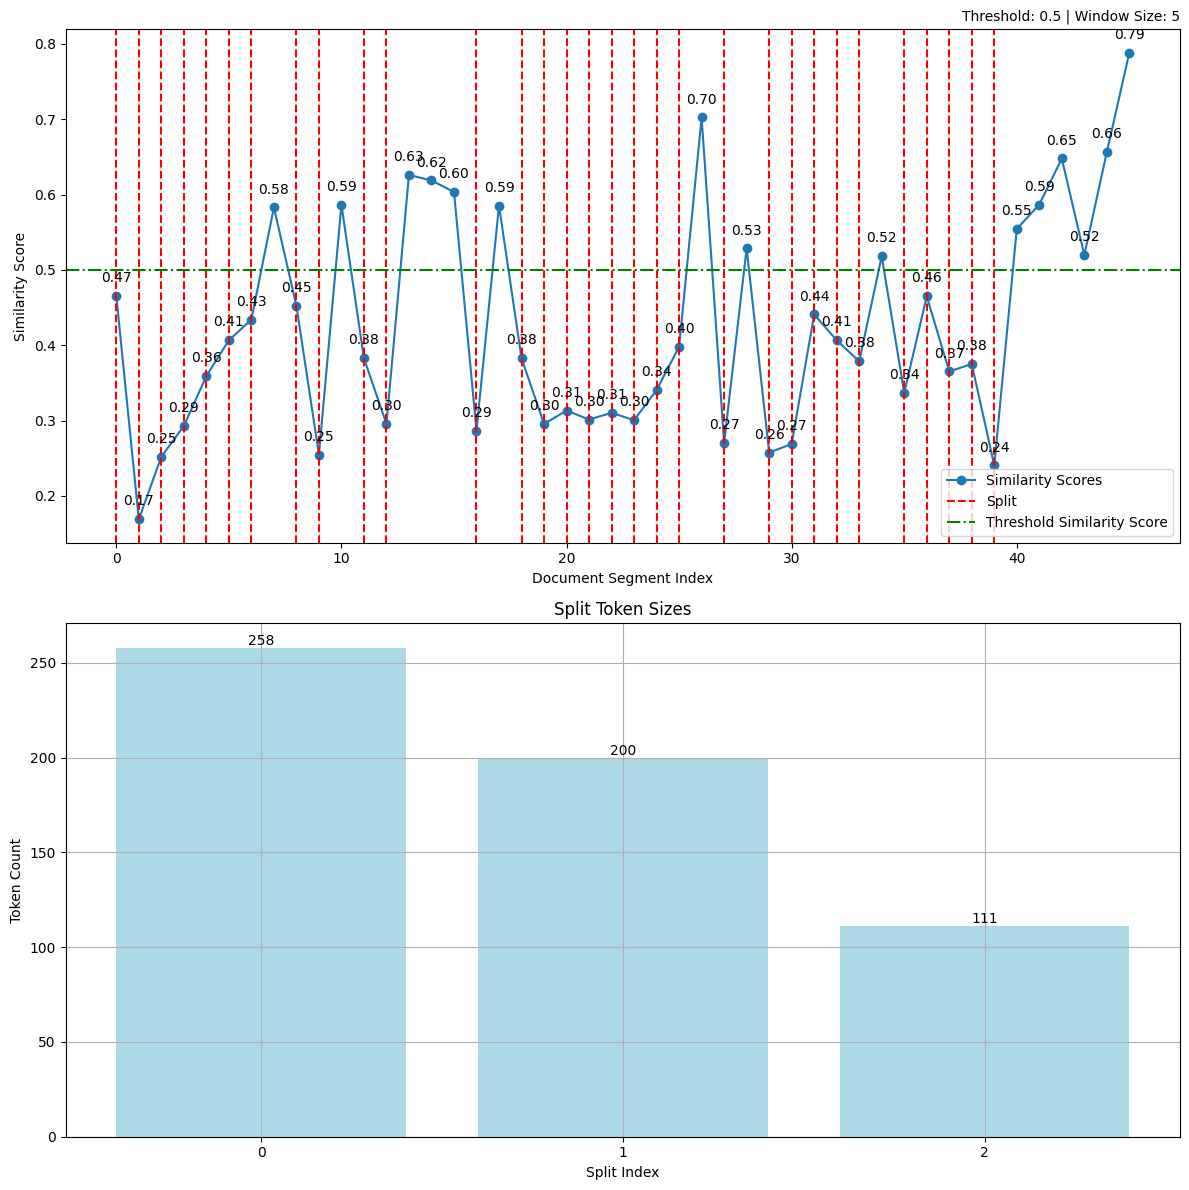

Splitting Statistics:
  - Total Documents: 47
  - Total Splits: 3
  - Splits by Threshold: 2
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 111
  - Maximum Token Size of Split: 258
  - Similarity Split Ratio: 0.67
section_26.txt


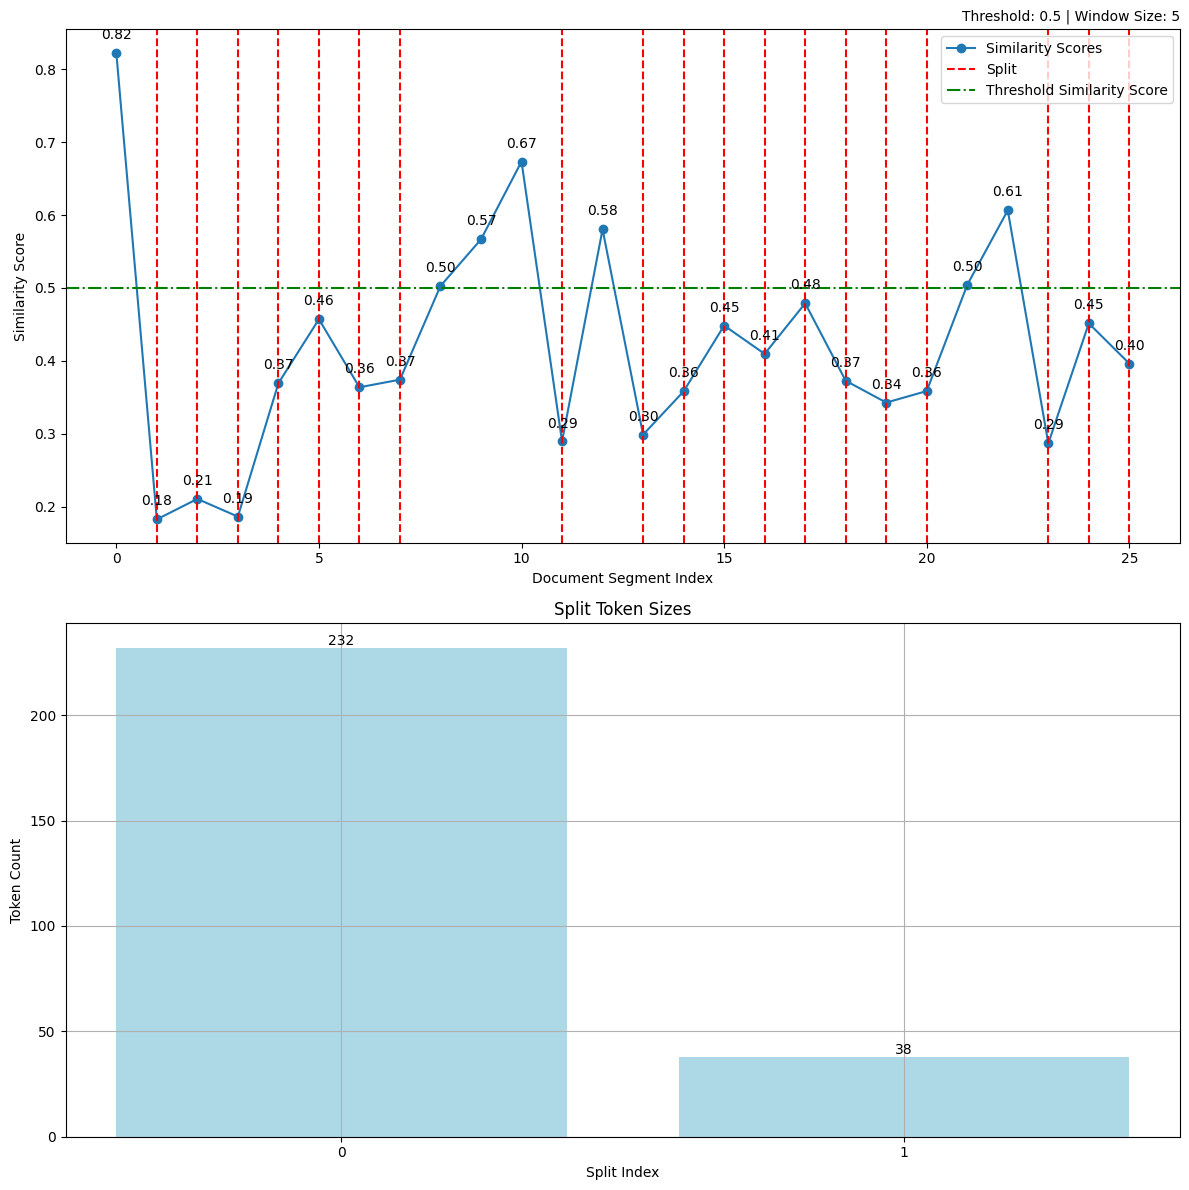

Splitting Statistics:
  - Total Documents: 27
  - Total Splits: 2
  - Splits by Threshold: 1
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 38
  - Maximum Token Size of Split: 232
  - Similarity Split Ratio: 0.50
section_4.txt


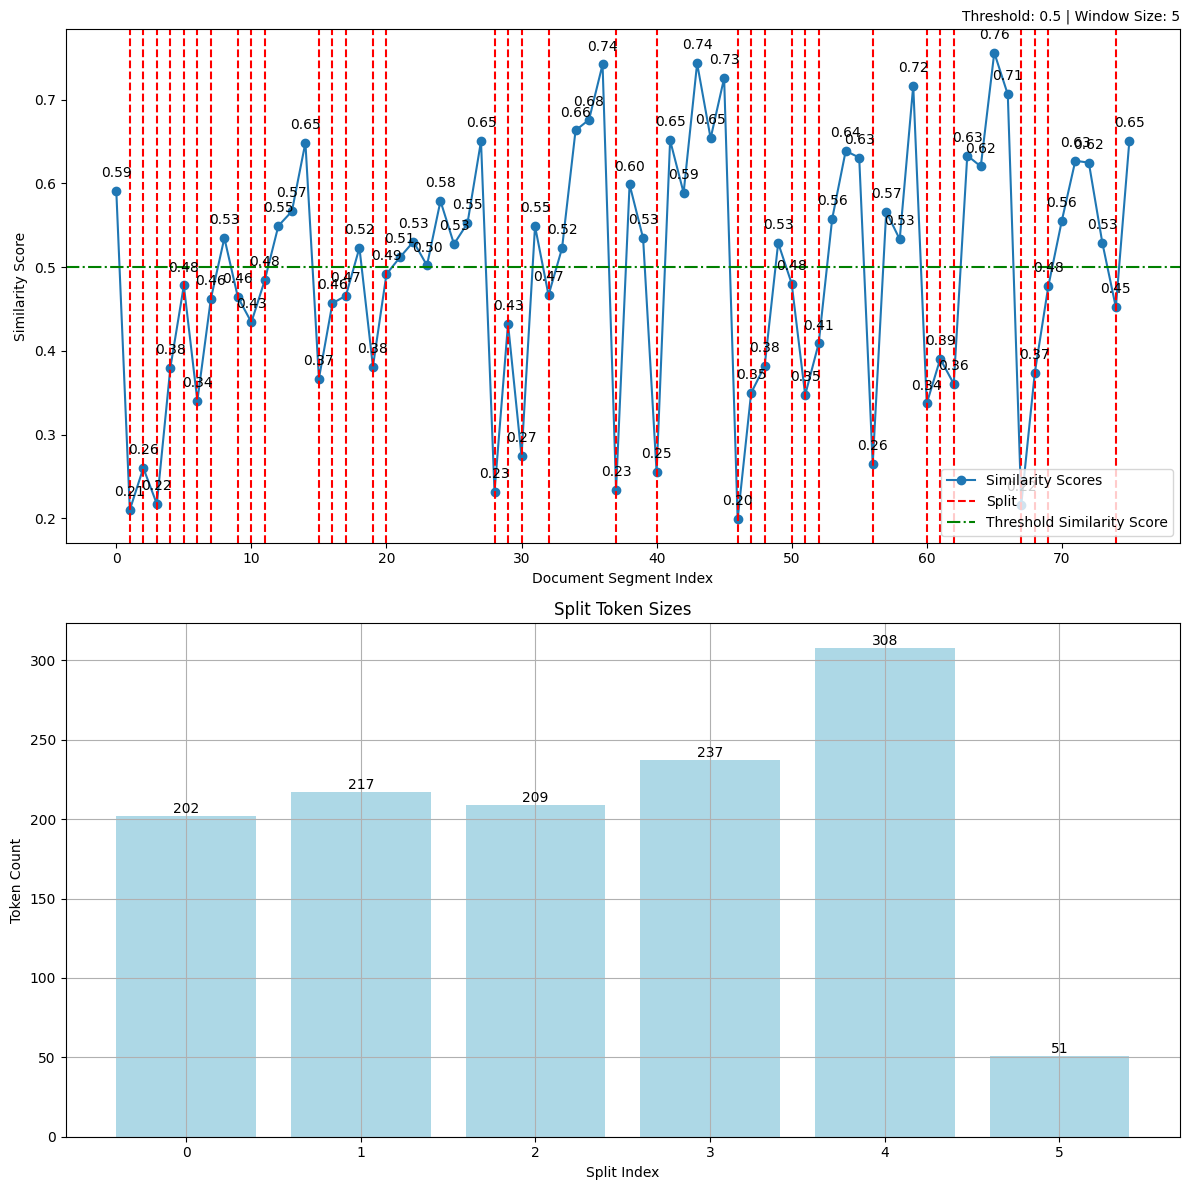

Splitting Statistics:
  - Total Documents: 77
  - Total Splits: 6
  - Splits by Threshold: 5
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 51
  - Maximum Token Size of Split: 308
  - Similarity Split Ratio: 0.83
section_25.txt


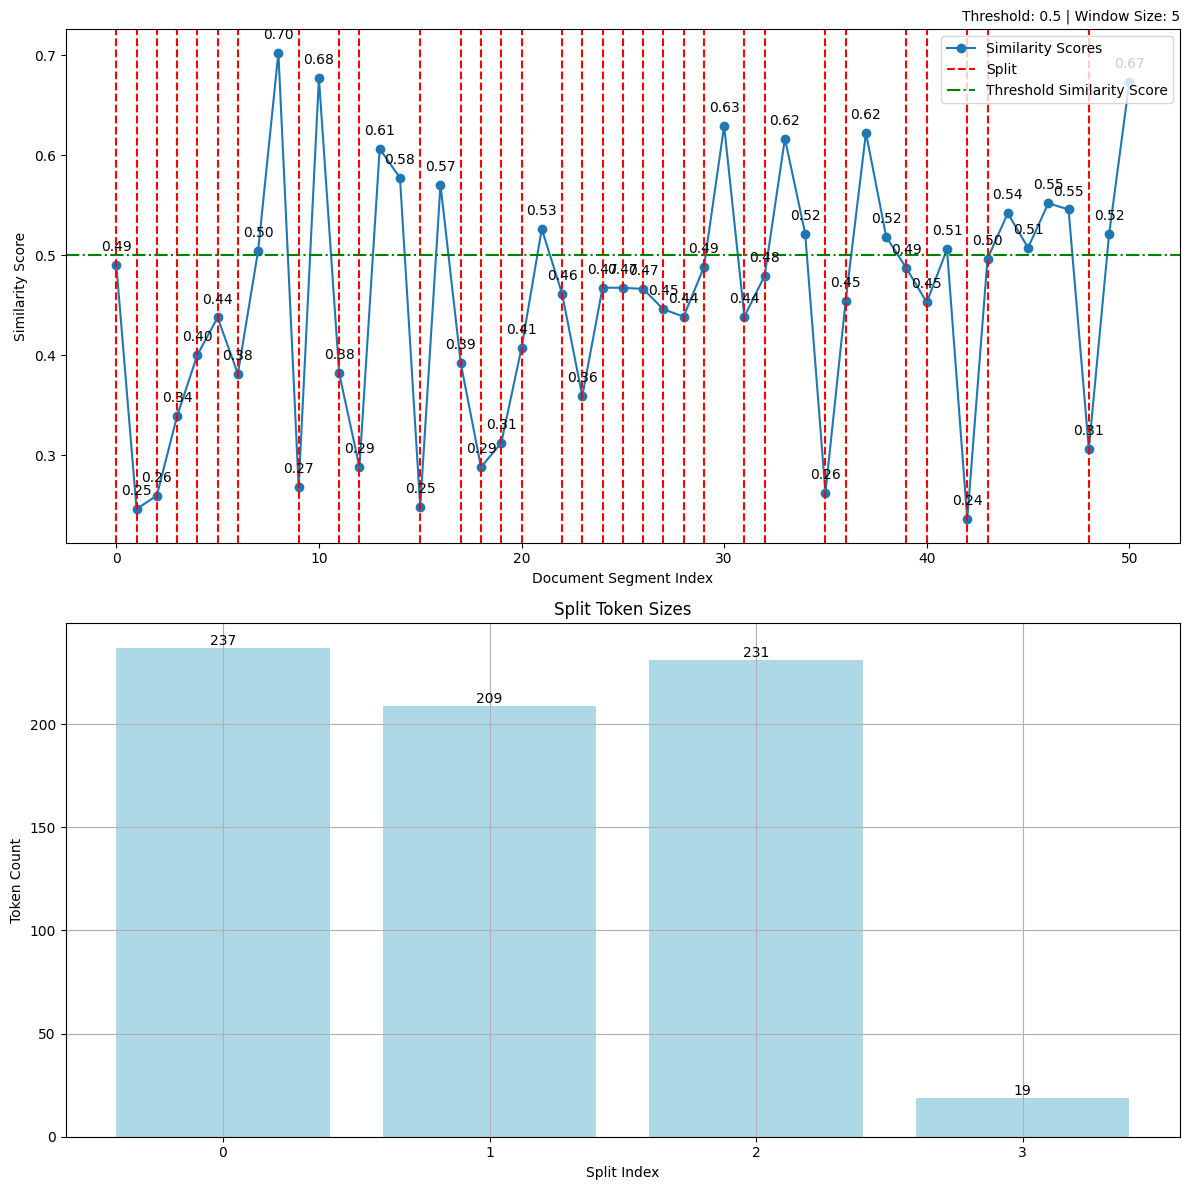

Splitting Statistics:
  - Total Documents: 52
  - Total Splits: 4
  - Splits by Threshold: 3
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 19
  - Maximum Token Size of Split: 237
  - Similarity Split Ratio: 0.75
section_6.txt


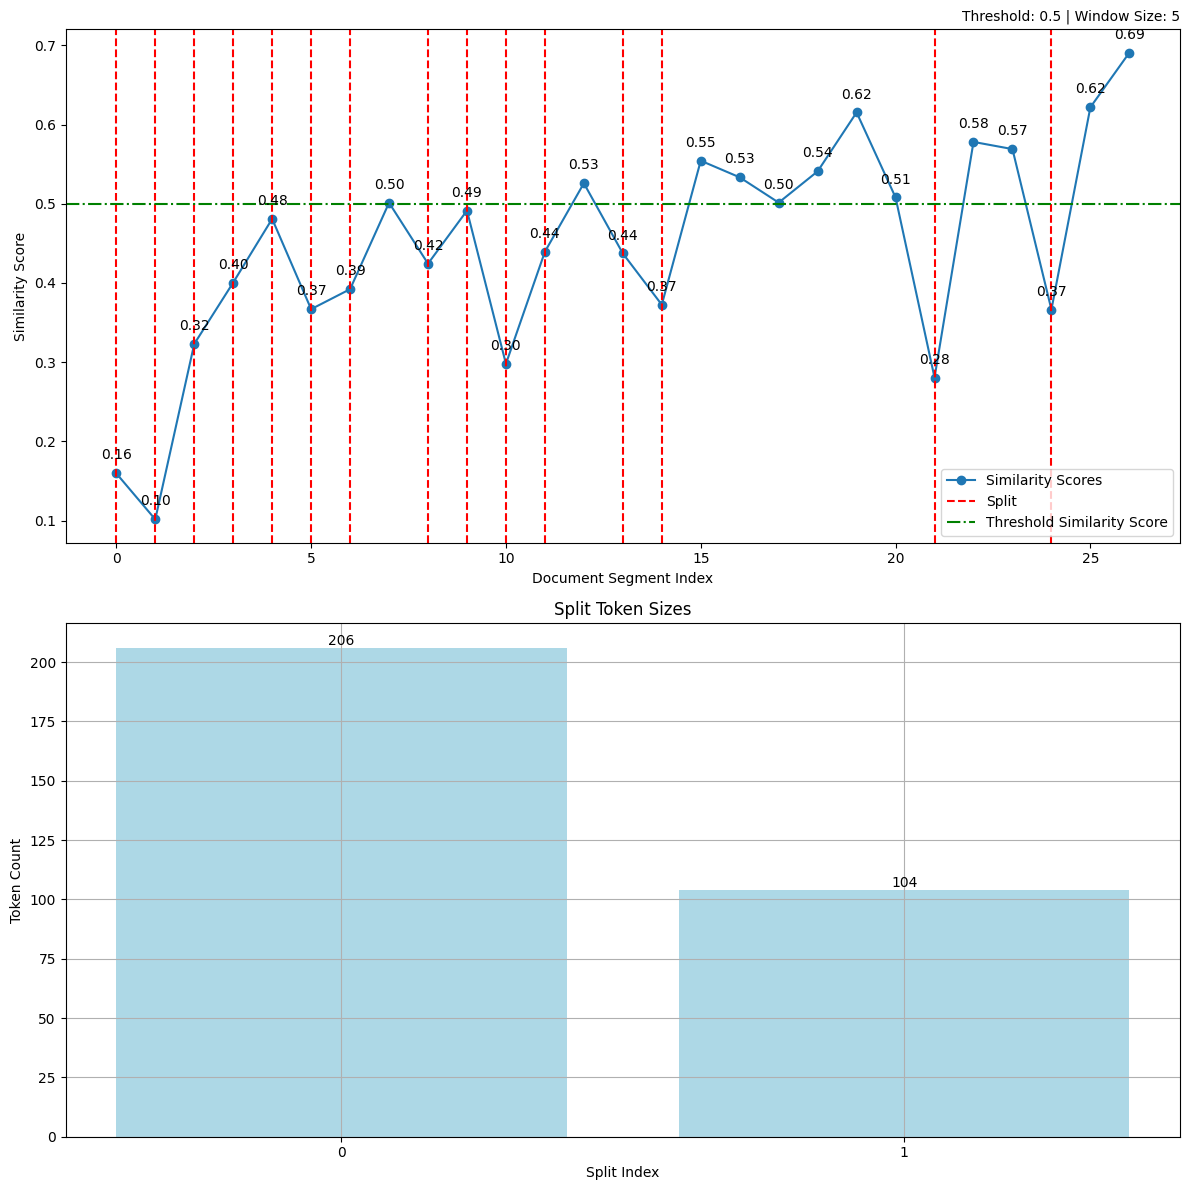

Splitting Statistics:
  - Total Documents: 28
  - Total Splits: 2
  - Splits by Threshold: 1
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 104
  - Maximum Token Size of Split: 206
  - Similarity Split Ratio: 0.50
section_161.txt


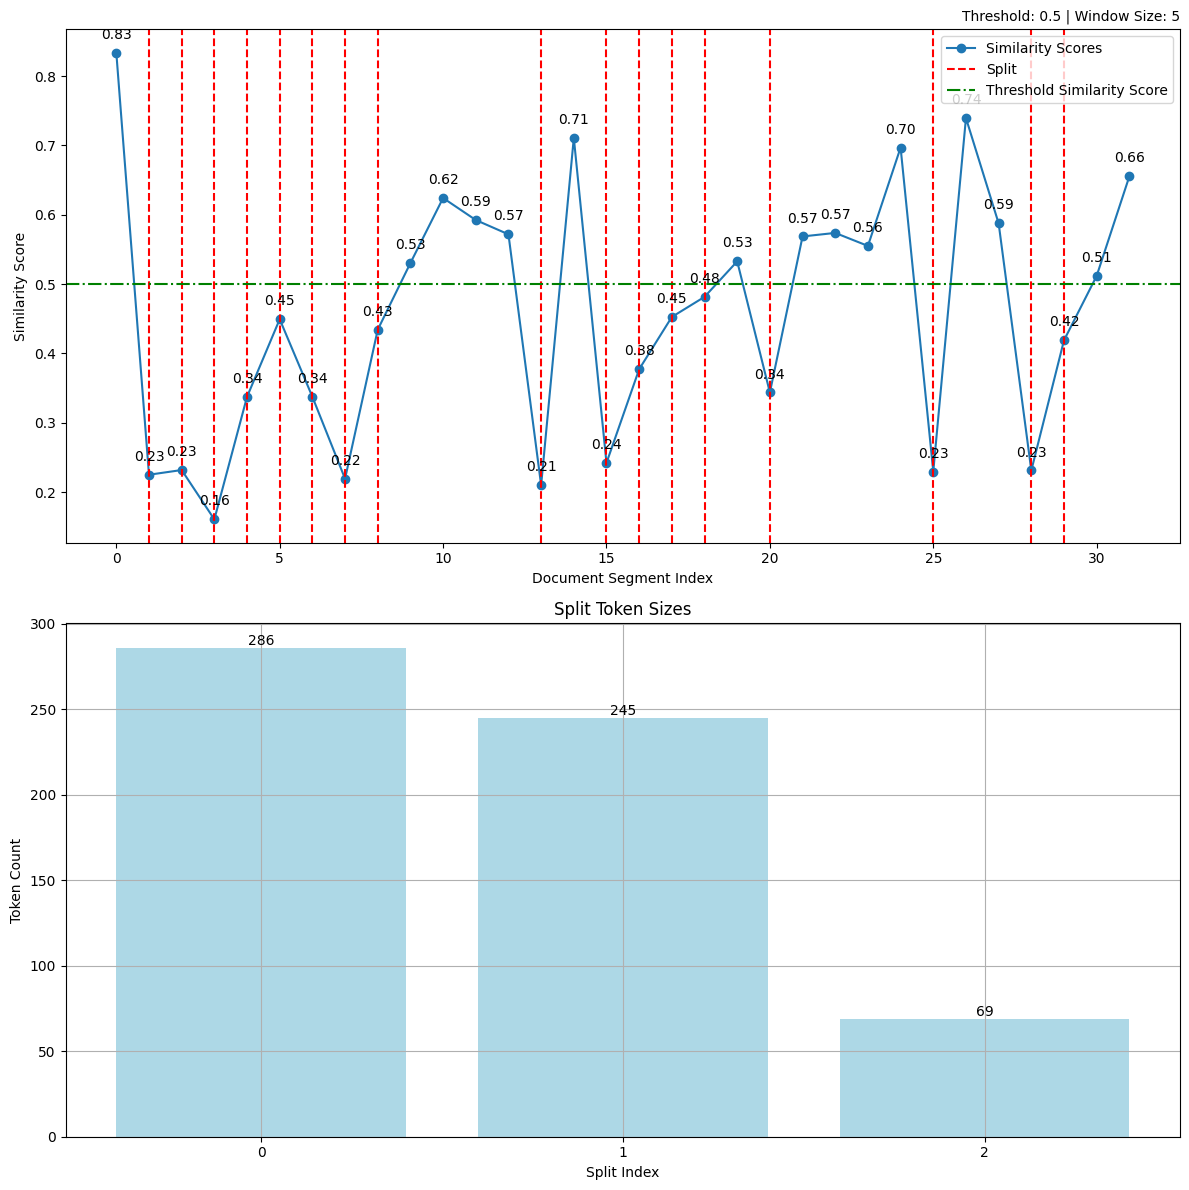

Splitting Statistics:
  - Total Documents: 33
  - Total Splits: 3
  - Splits by Threshold: 2
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 69
  - Maximum Token Size of Split: 286
  - Similarity Split Ratio: 0.67
section_35.txt


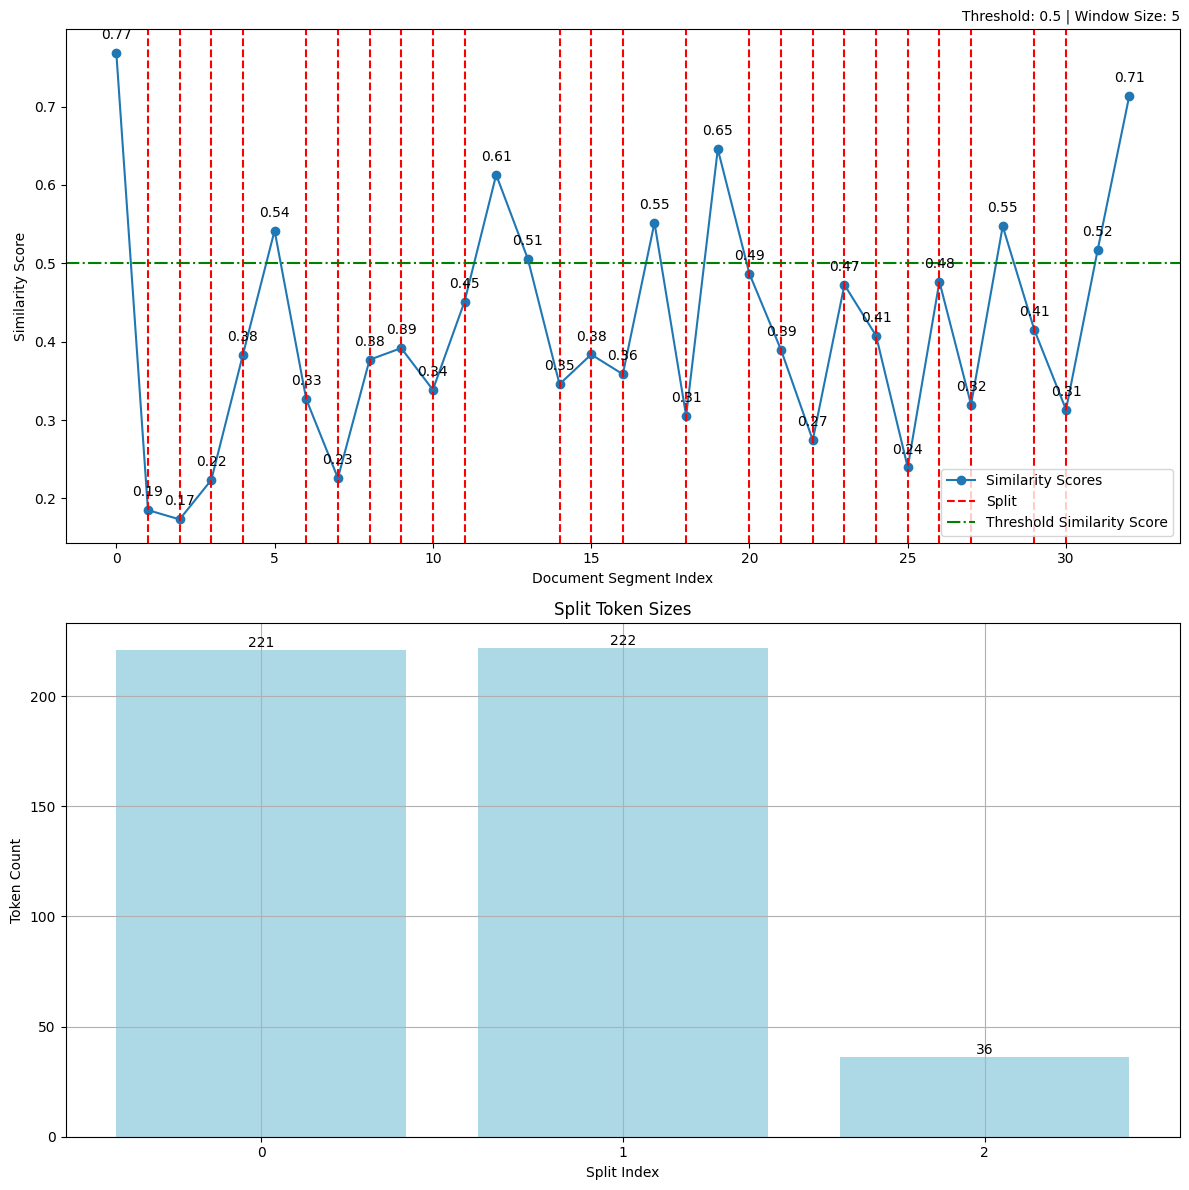

Splitting Statistics:
  - Total Documents: 34
  - Total Splits: 3
  - Splits by Threshold: 2
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 36
  - Maximum Token Size of Split: 222
  - Similarity Split Ratio: 0.67
section_24.txt


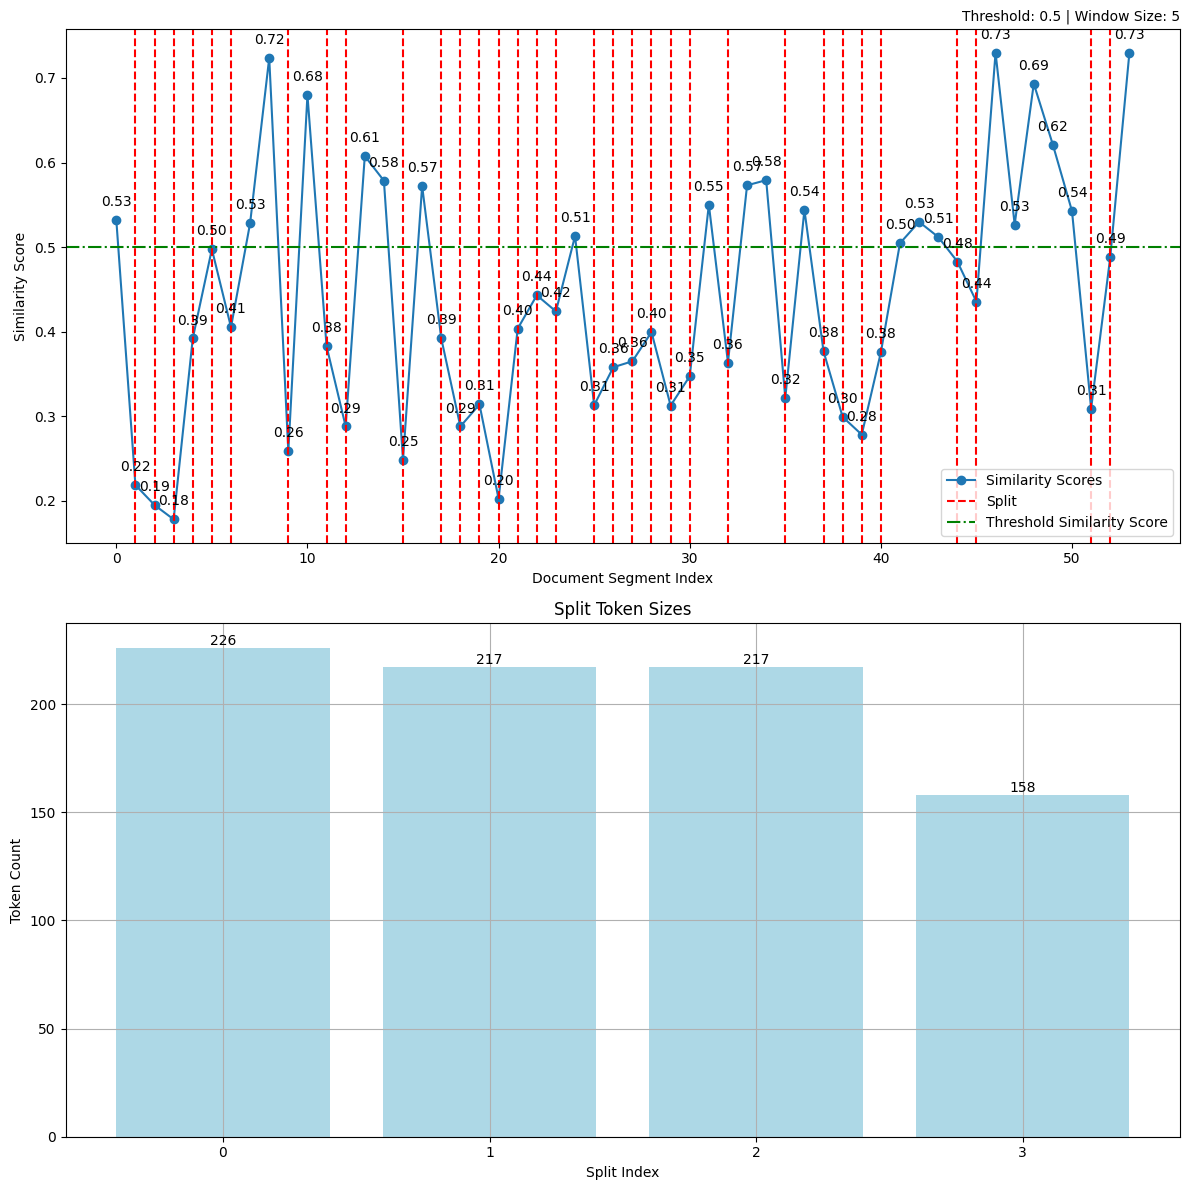

Splitting Statistics:
  - Total Documents: 55
  - Total Splits: 4
  - Splits by Threshold: 3
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 158
  - Maximum Token Size of Split: 226
  - Similarity Split Ratio: 0.75
section_42.txt


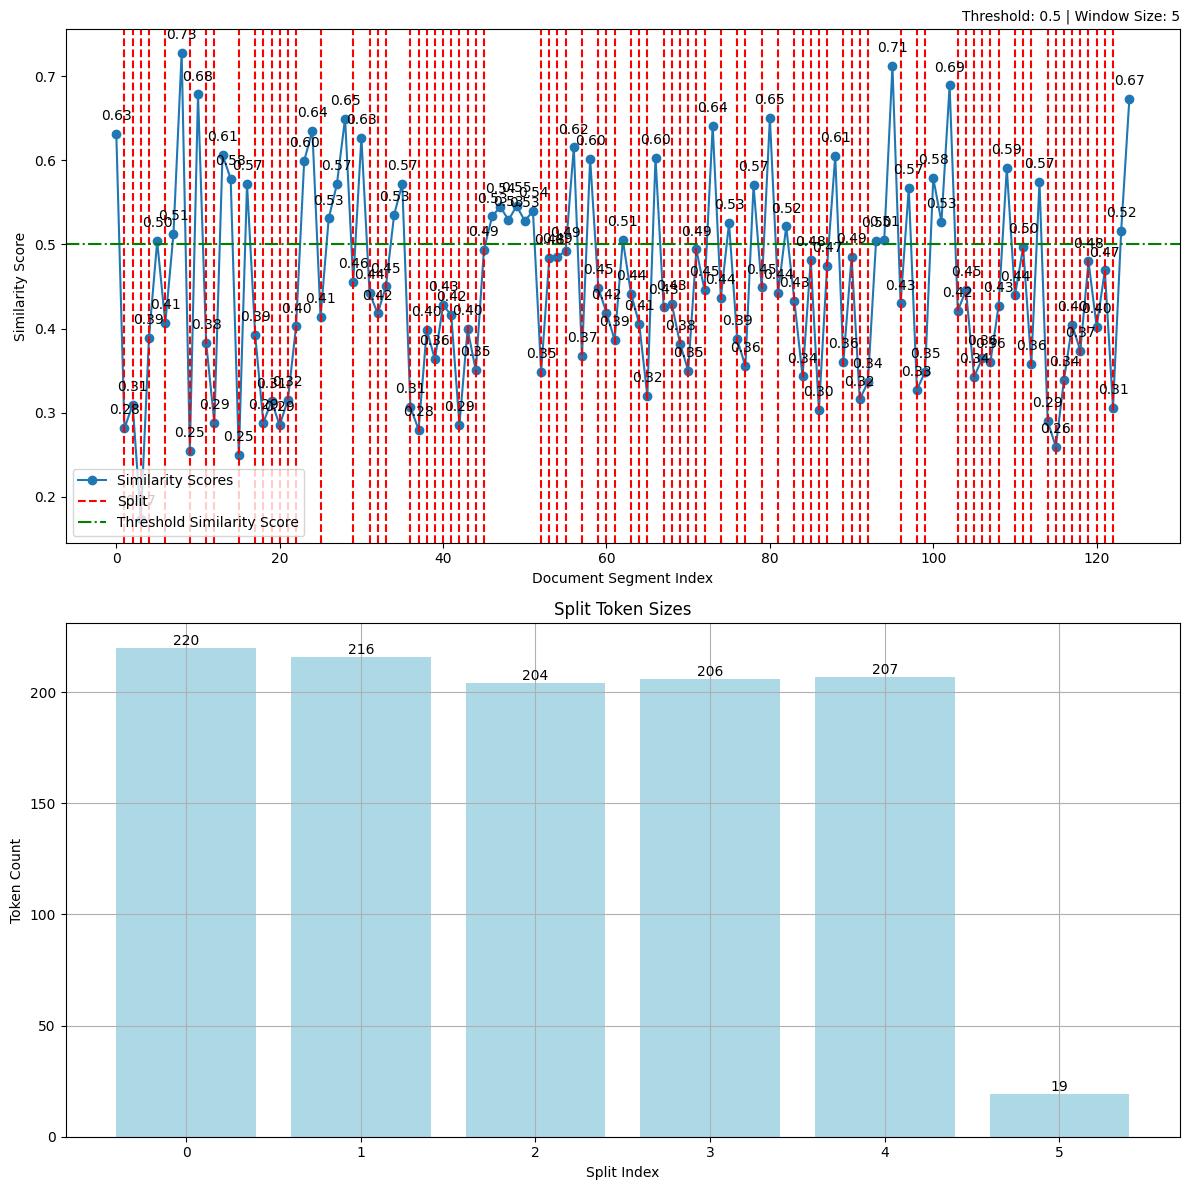

Splitting Statistics:
  - Total Documents: 126
  - Total Splits: 6
  - Splits by Threshold: 5
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 19
  - Maximum Token Size of Split: 220
  - Similarity Split Ratio: 0.83
section_41.txt


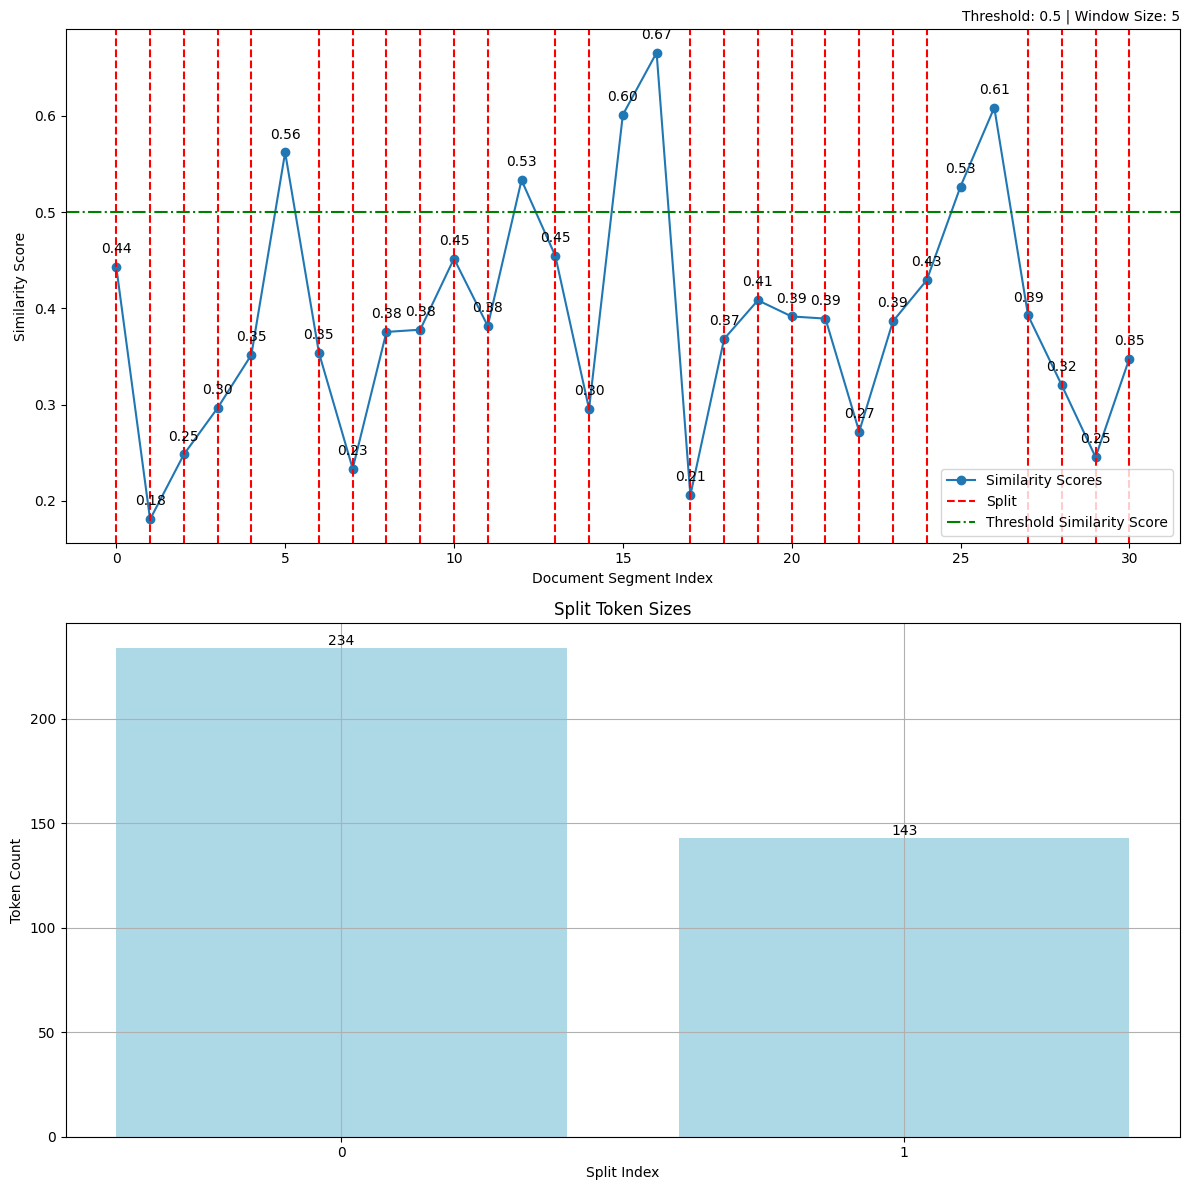

Splitting Statistics:
  - Total Documents: 32
  - Total Splits: 2
  - Splits by Threshold: 1
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 143
  - Maximum Token Size of Split: 234
  - Similarity Split Ratio: 0.50
section_14.txt


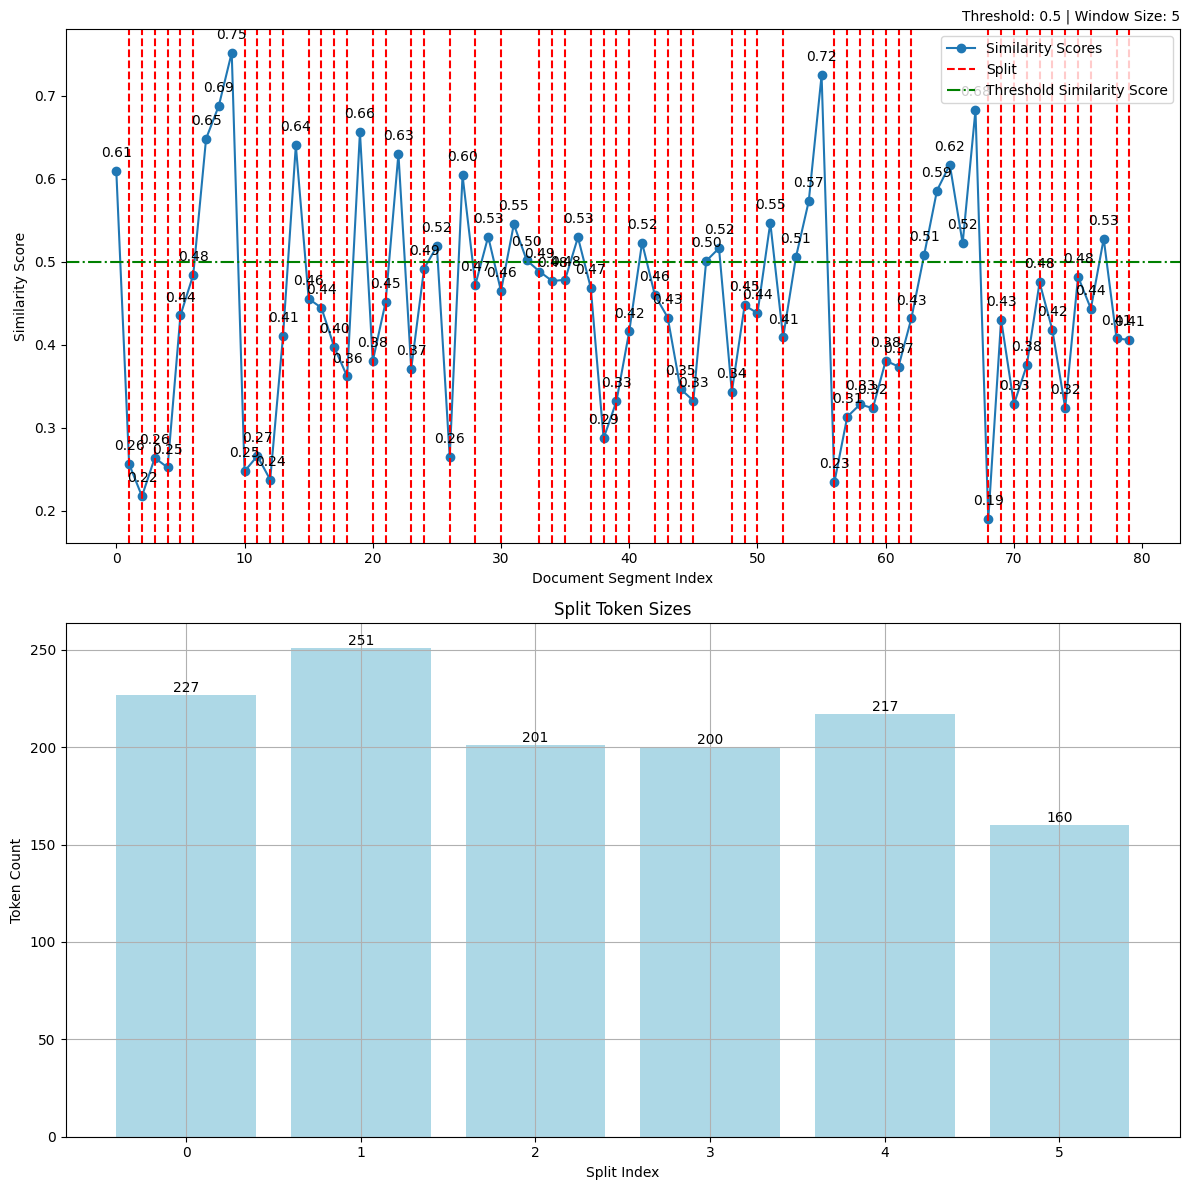

Splitting Statistics:
  - Total Documents: 81
  - Total Splits: 6
  - Splits by Threshold: 5
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 160
  - Maximum Token Size of Split: 251
  - Similarity Split Ratio: 0.83
section_20.txt


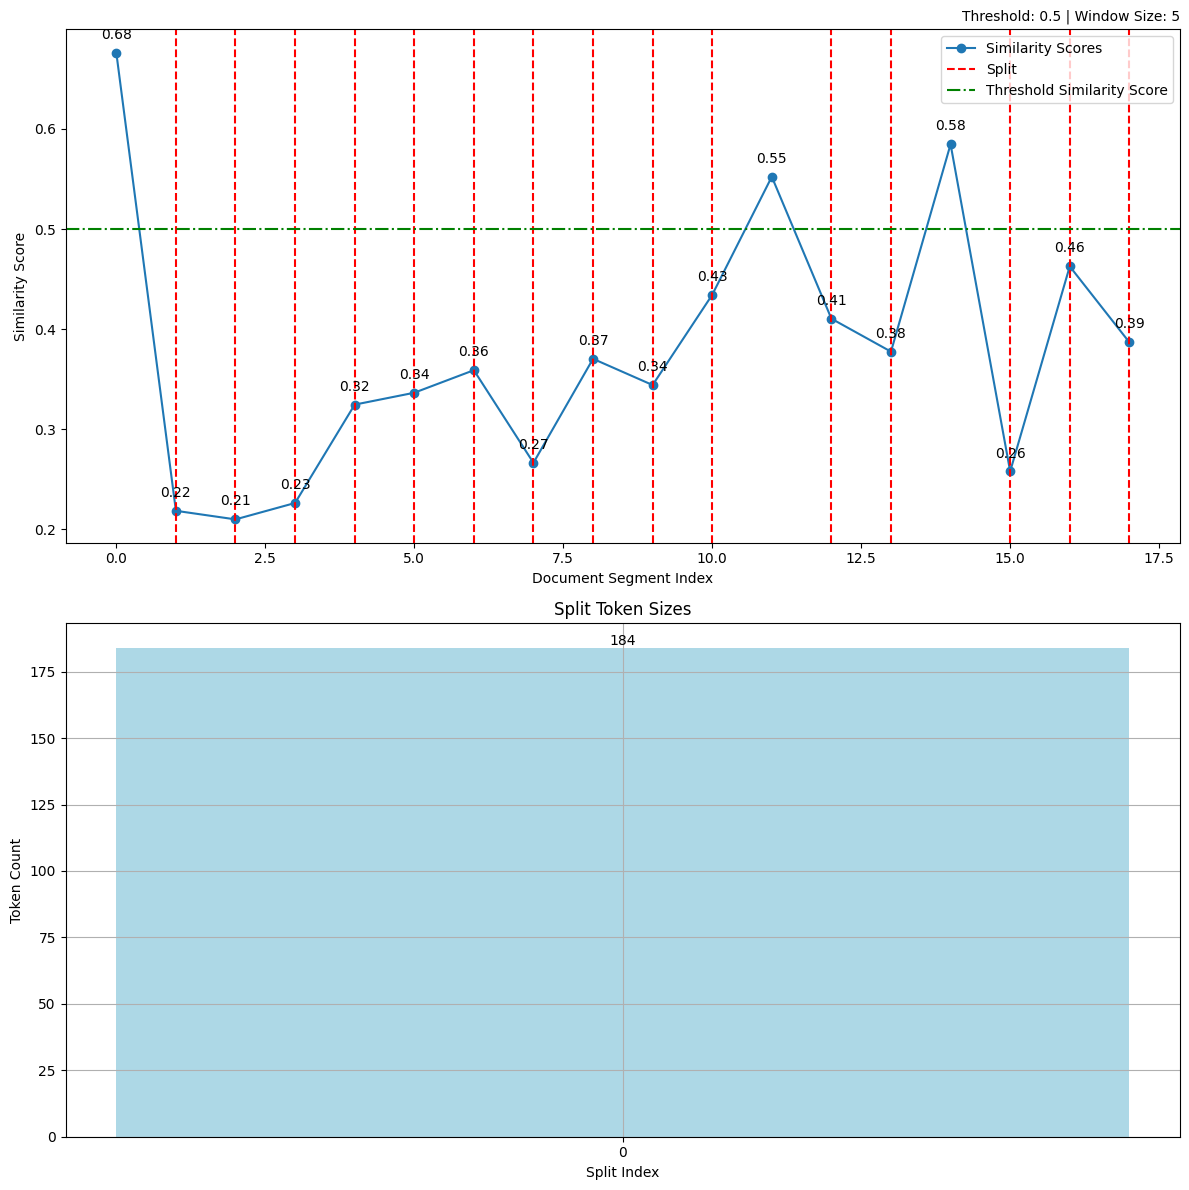

Splitting Statistics:
  - Total Documents: 19
  - Total Splits: 1
  - Splits by Threshold: 0
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 184
  - Maximum Token Size of Split: 184
  - Similarity Split Ratio: 0.00
section_13.txt


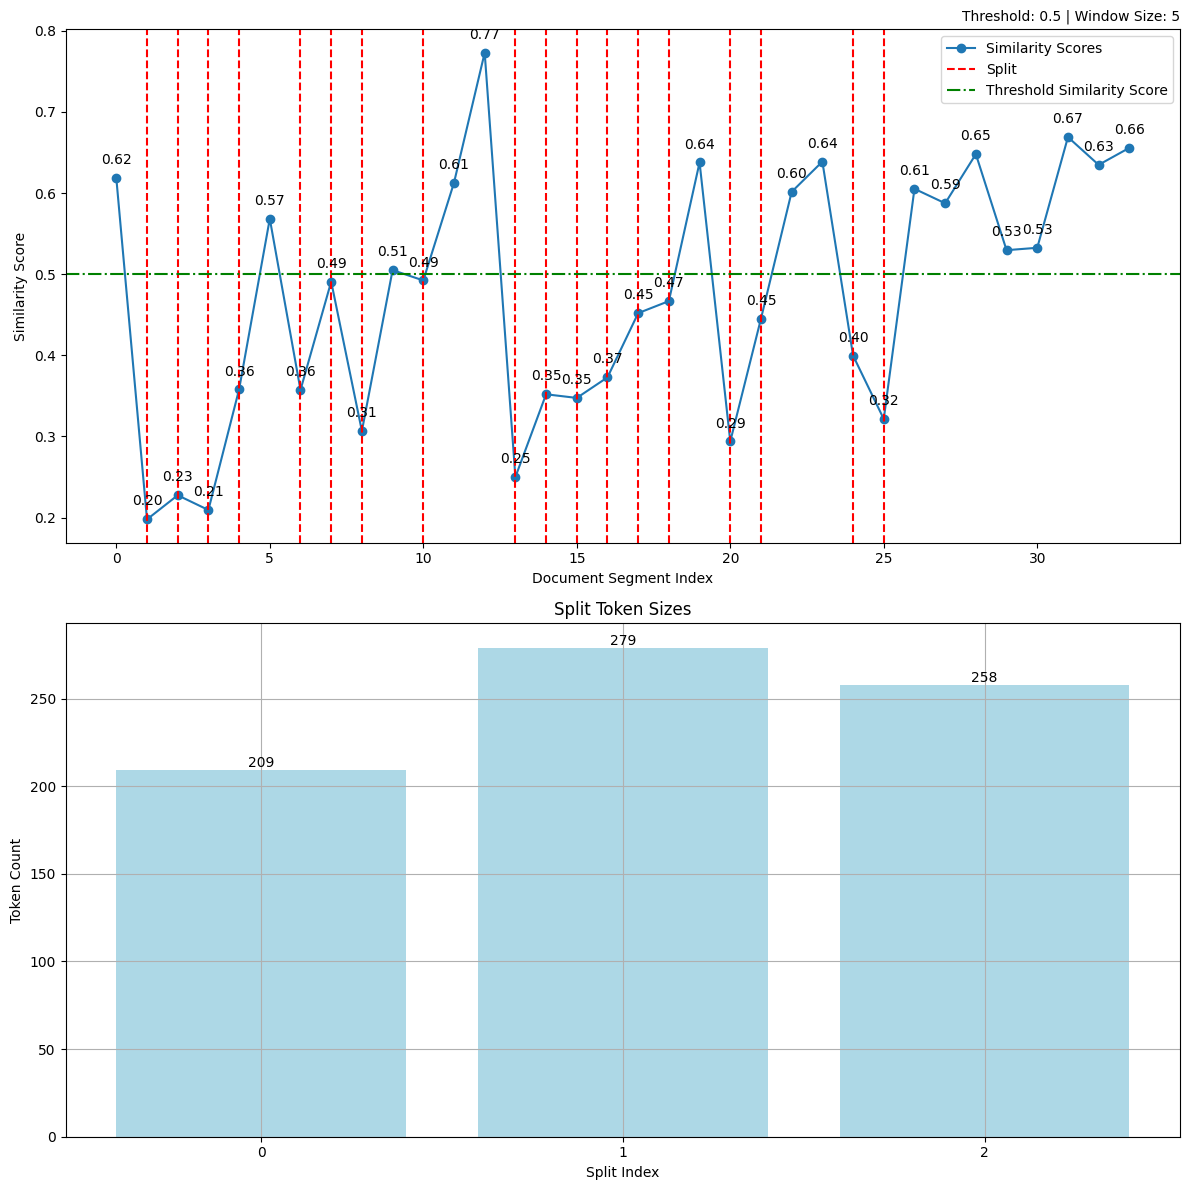

Splitting Statistics:
  - Total Documents: 35
  - Total Splits: 3
  - Splits by Threshold: 2
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 209
  - Maximum Token Size of Split: 279
  - Similarity Split Ratio: 0.67
section_171.txt


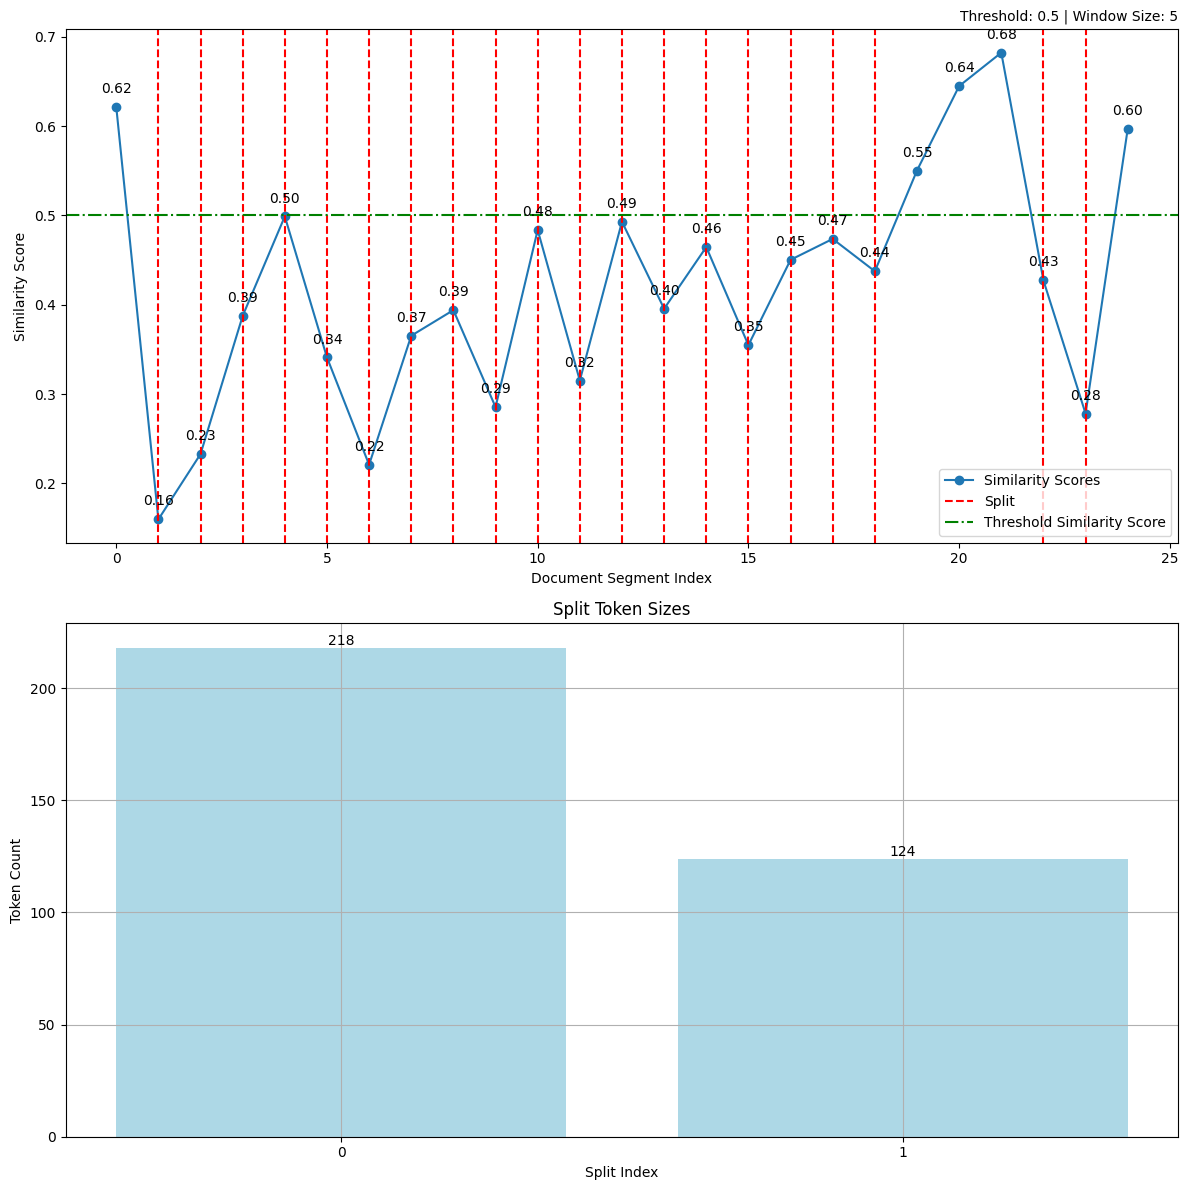

Splitting Statistics:
  - Total Documents: 26
  - Total Splits: 2
  - Splits by Threshold: 1
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 124
  - Maximum Token Size of Split: 218
  - Similarity Split Ratio: 0.50
section_10.txt


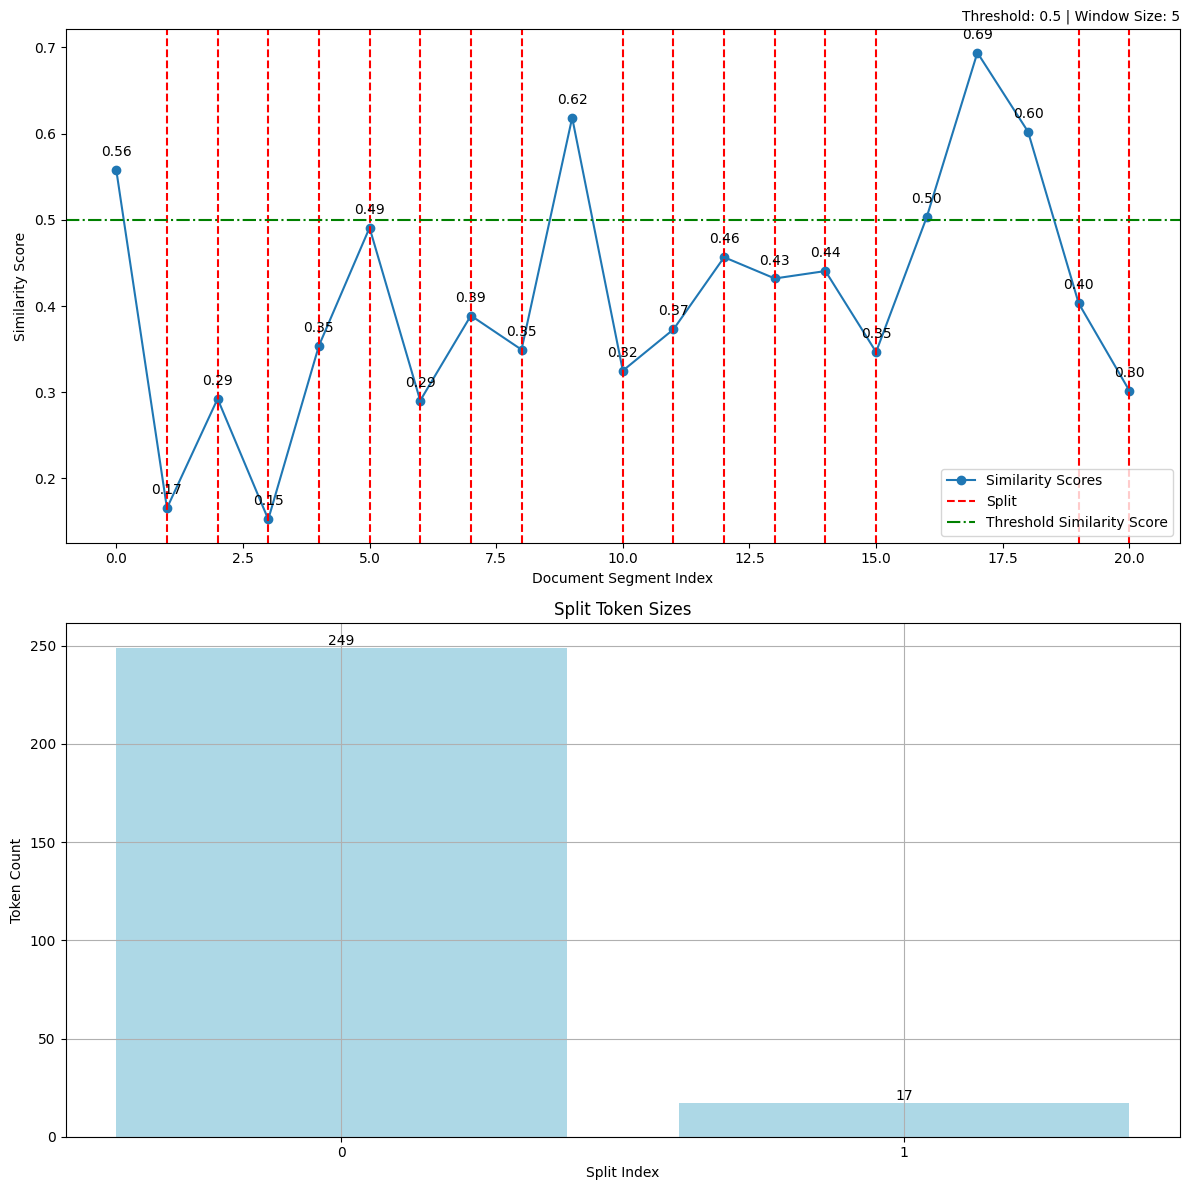

Splitting Statistics:
  - Total Documents: 22
  - Total Splits: 2
  - Splits by Threshold: 1
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 17
  - Maximum Token Size of Split: 249
  - Similarity Split Ratio: 0.50
section_36.txt


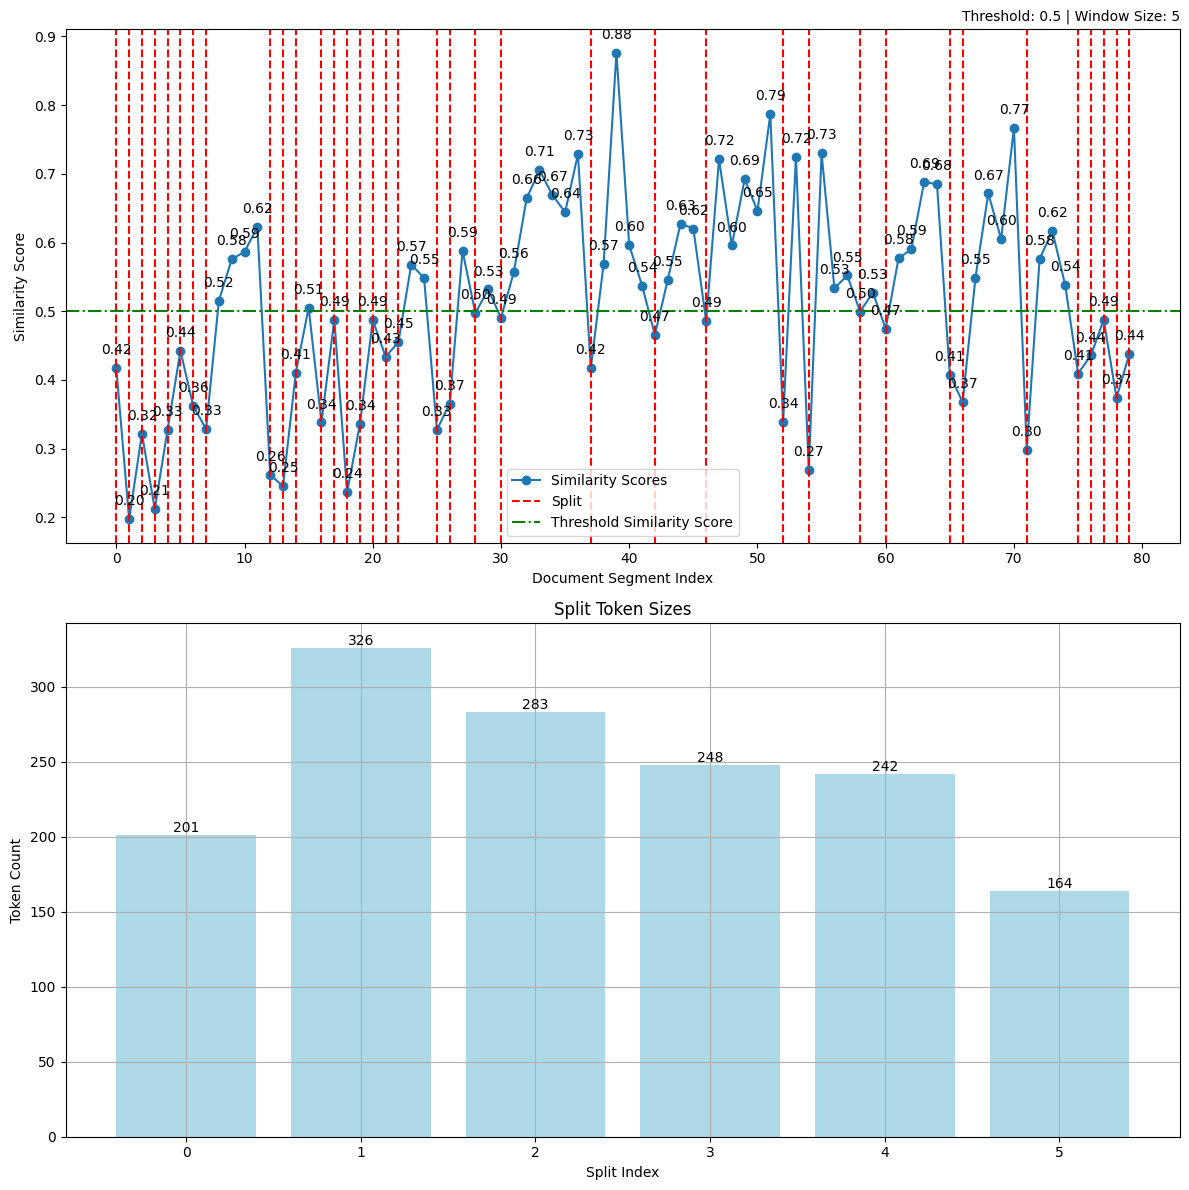

Splitting Statistics:
  - Total Documents: 81
  - Total Splits: 6
  - Splits by Threshold: 5
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 164
  - Maximum Token Size of Split: 326
  - Similarity Split Ratio: 0.83
section_40.txt


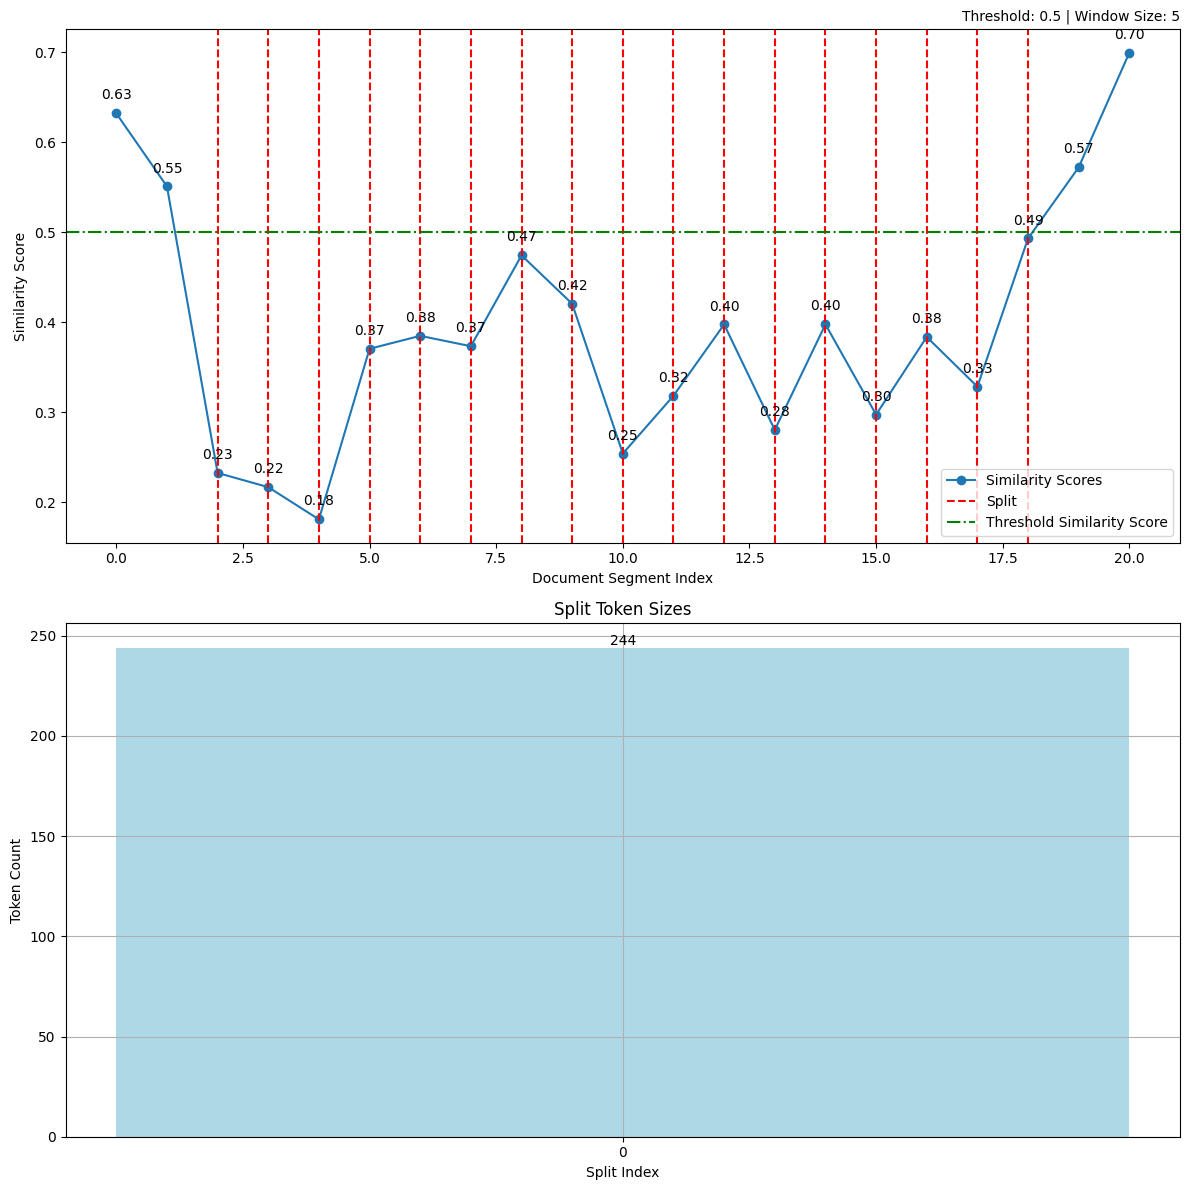

Splitting Statistics:
  - Total Documents: 22
  - Total Splits: 1
  - Splits by Threshold: 0
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 244
  - Maximum Token Size of Split: 244
  - Similarity Split Ratio: 0.00
section_37.txt


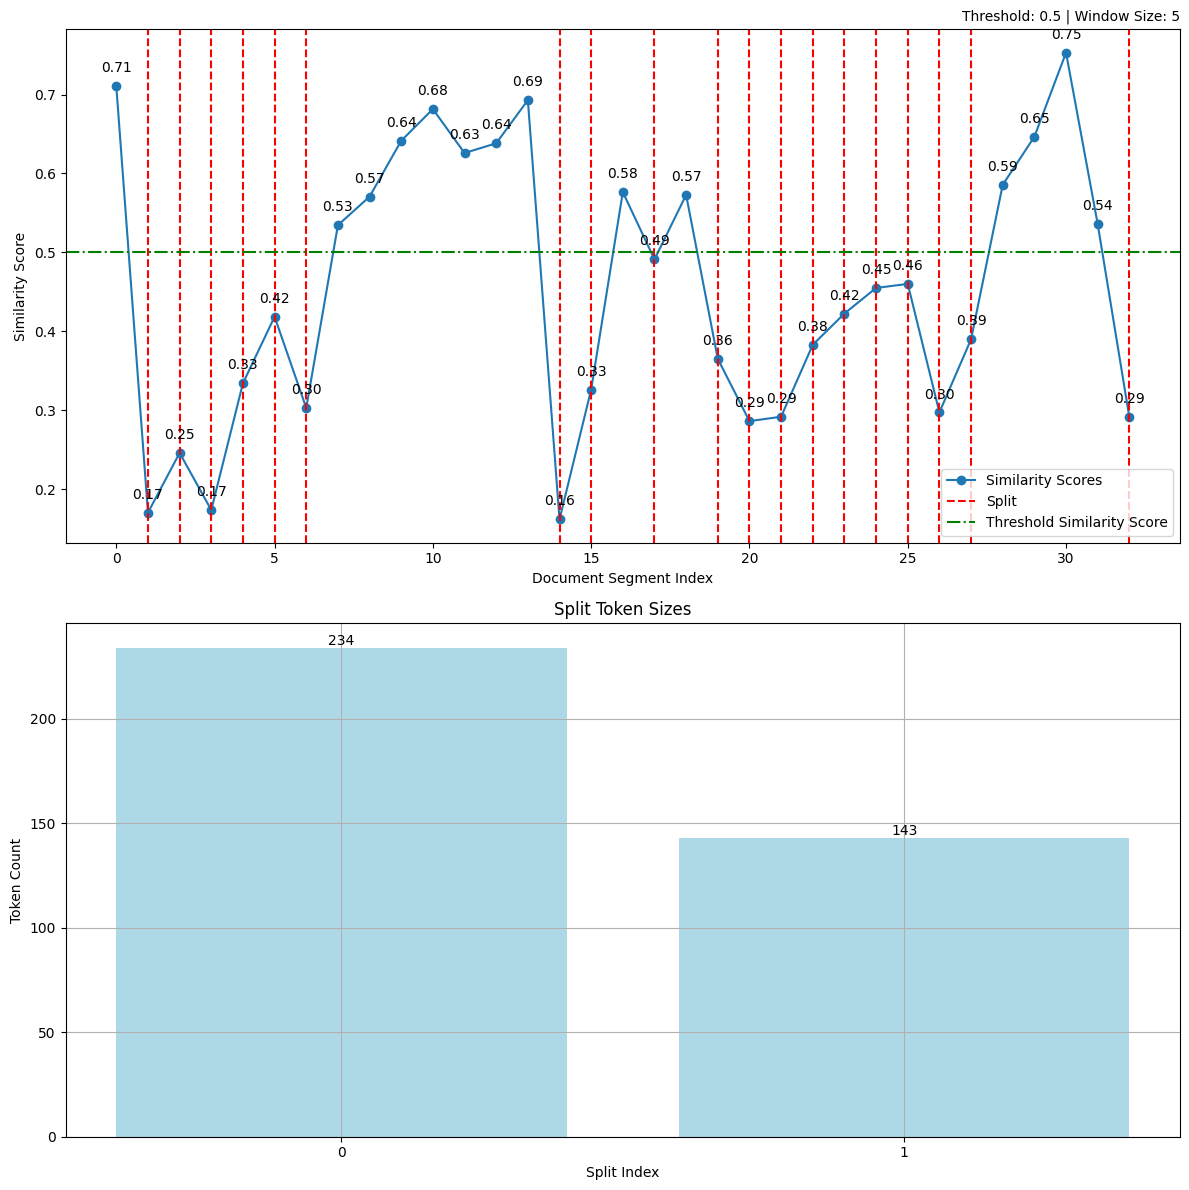

Splitting Statistics:
  - Total Documents: 34
  - Total Splits: 2
  - Splits by Threshold: 1
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 143
  - Maximum Token Size of Split: 234
  - Similarity Split Ratio: 0.50
section_7.txt


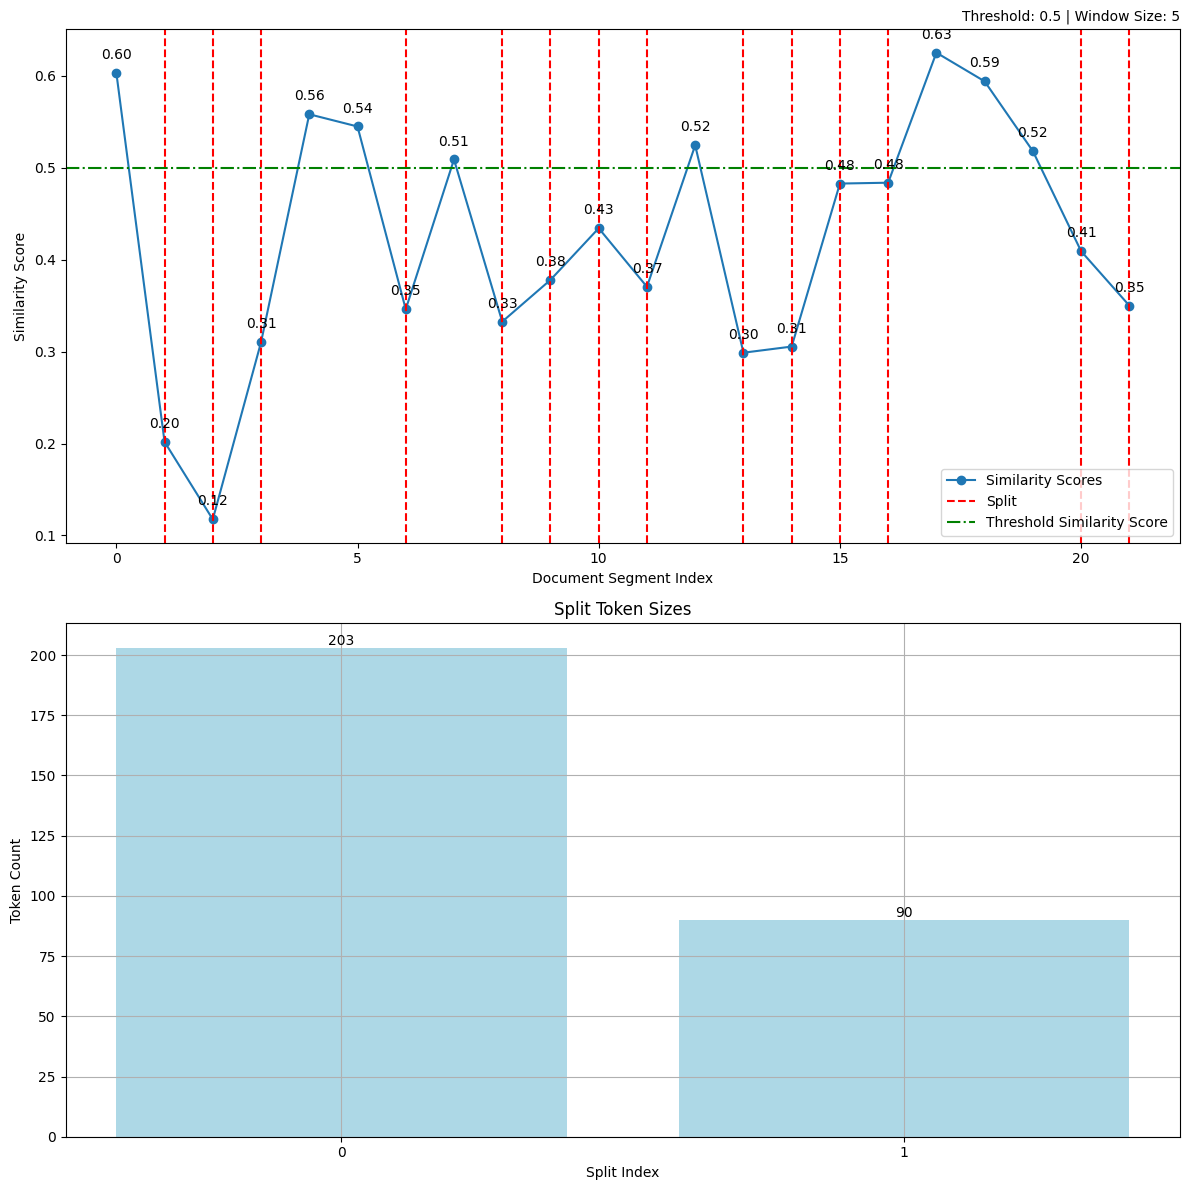

Splitting Statistics:
  - Total Documents: 23
  - Total Splits: 2
  - Splits by Threshold: 1
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 90
  - Maximum Token Size of Split: 203
  - Similarity Split Ratio: 0.50
section_2.txt


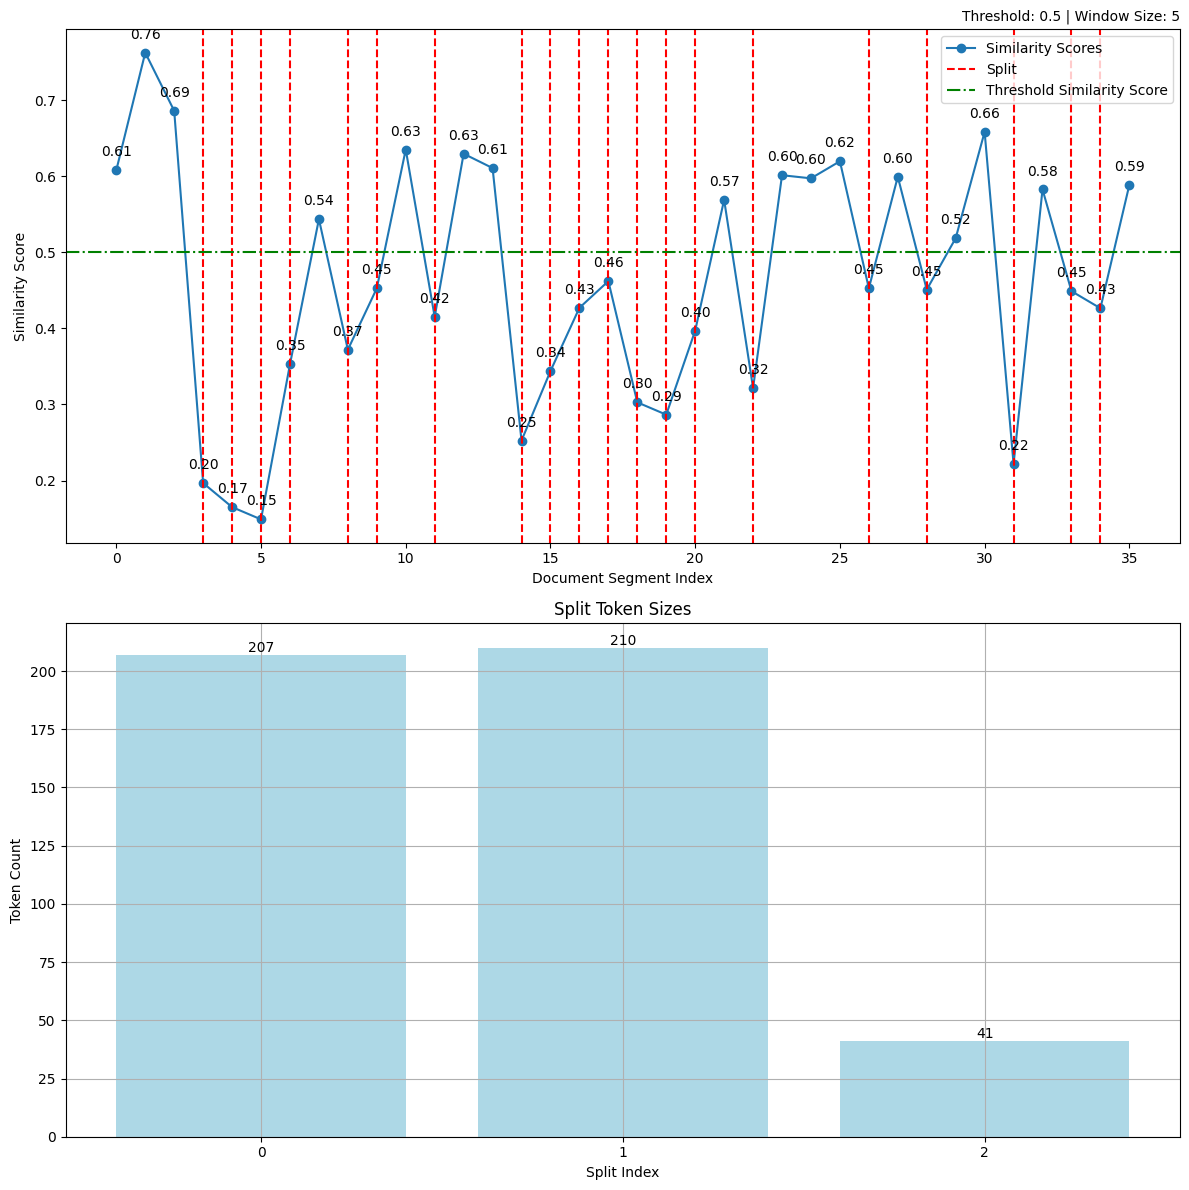

Splitting Statistics:
  - Total Documents: 37
  - Total Splits: 3
  - Splits by Threshold: 2
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 41
  - Maximum Token Size of Split: 210
  - Similarity Split Ratio: 0.67
section_22.txt


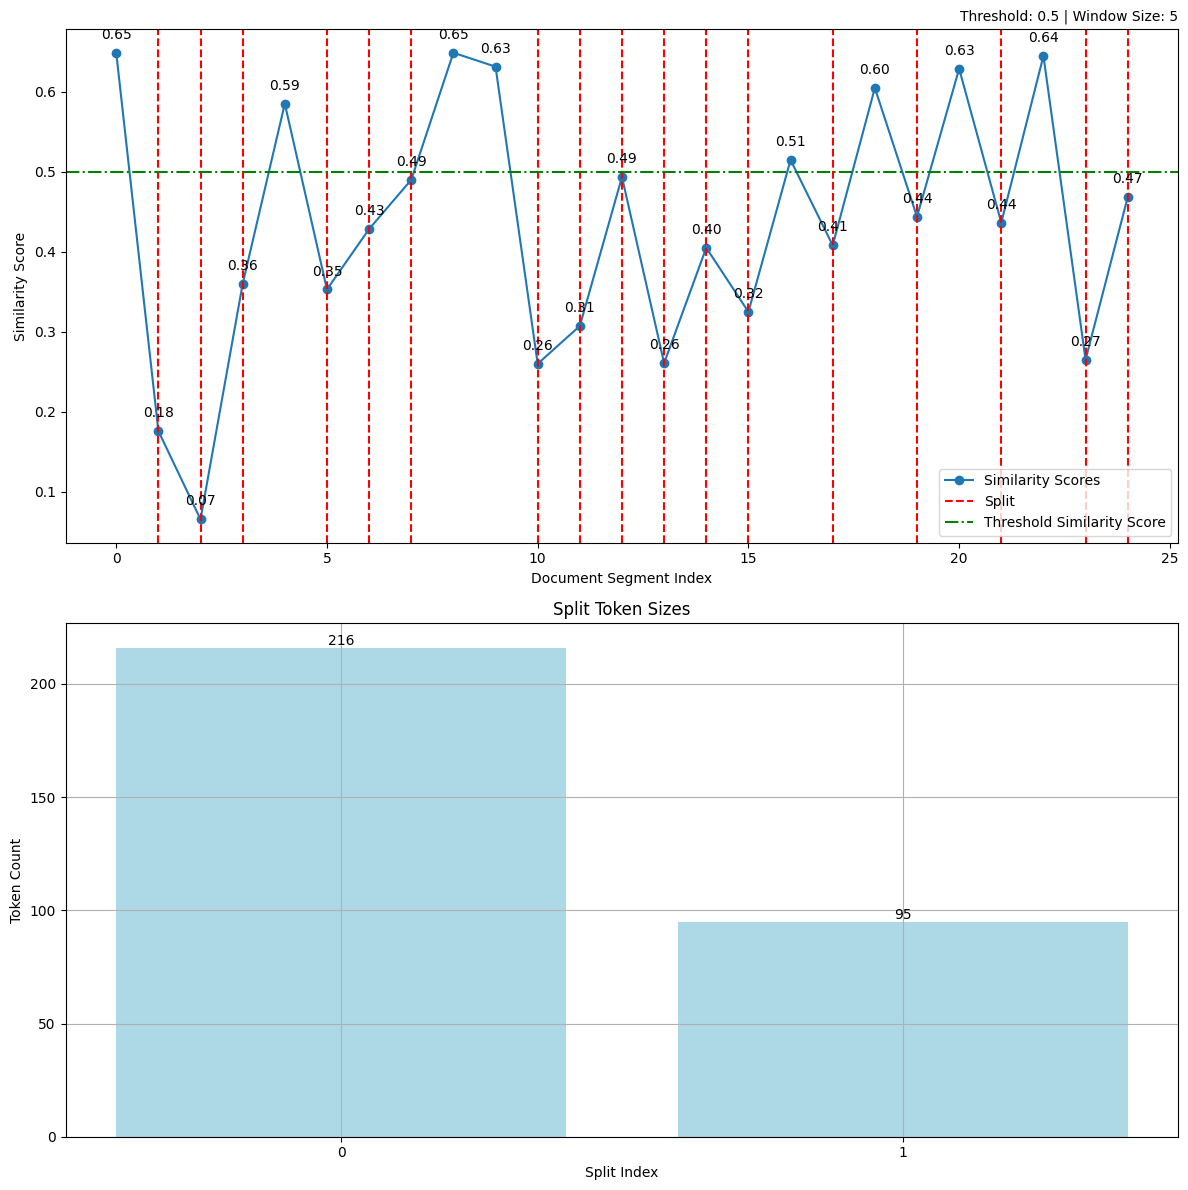

Splitting Statistics:
  - Total Documents: 26
  - Total Splits: 2
  - Splits by Threshold: 1
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 95
  - Maximum Token Size of Split: 216
  - Similarity Split Ratio: 0.50
section_27.txt


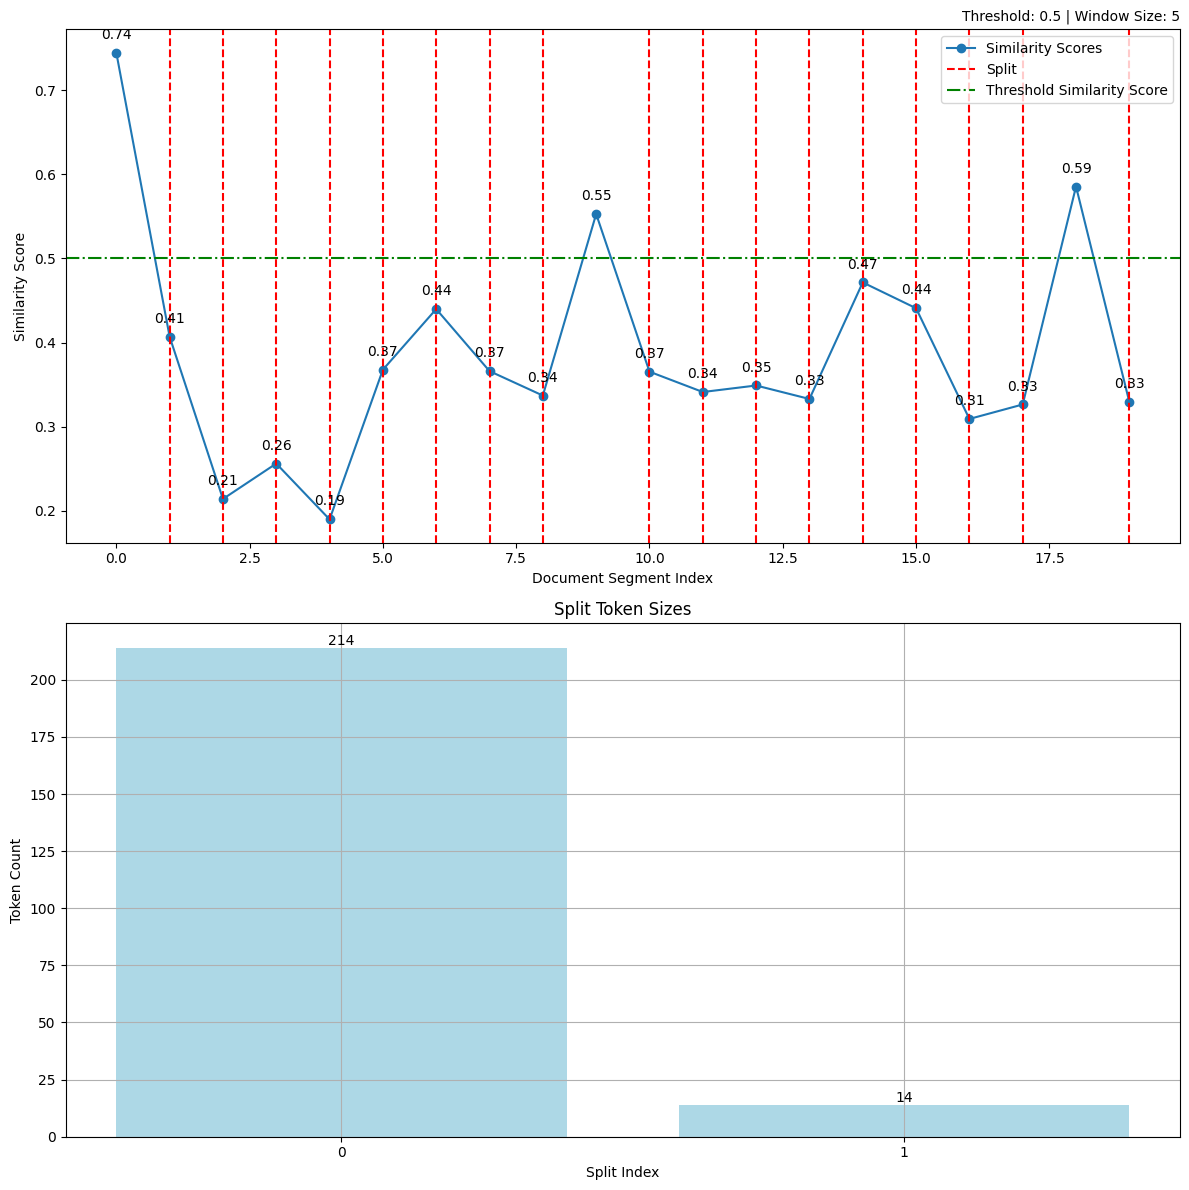

Splitting Statistics:
  - Total Documents: 21
  - Total Splits: 2
  - Splits by Threshold: 1
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 14
  - Maximum Token Size of Split: 214
  - Similarity Split Ratio: 0.50
section_30.txt


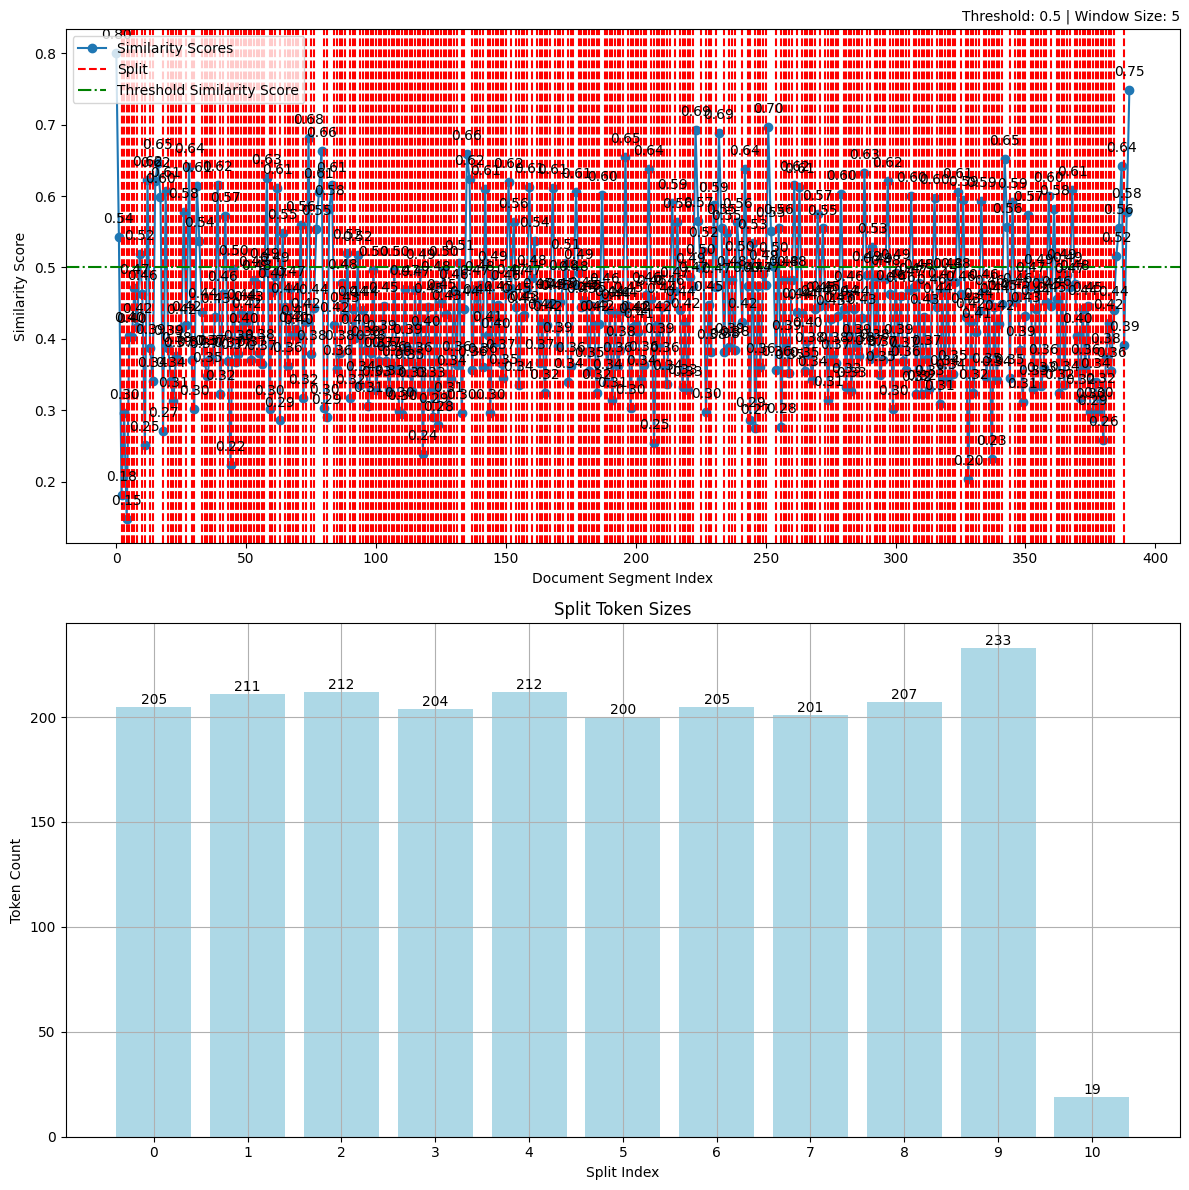

Splitting Statistics:
  - Total Documents: 392
  - Total Splits: 11
  - Splits by Threshold: 10
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 19
  - Maximum Token Size of Split: 233
  - Similarity Split Ratio: 0.91
section_44.txt


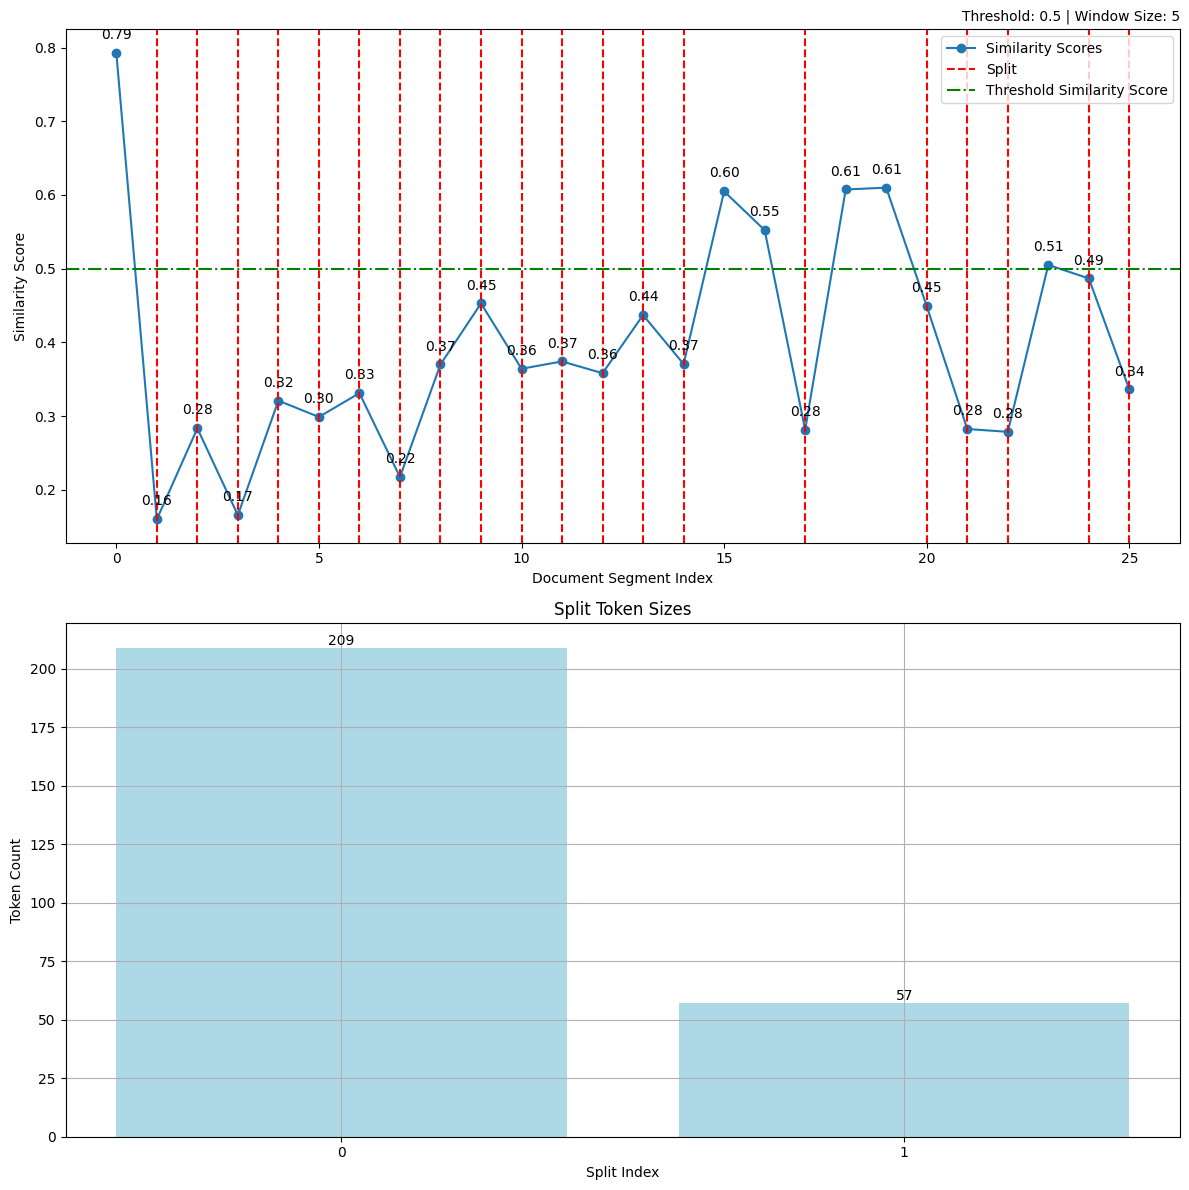

Splitting Statistics:
  - Total Documents: 27
  - Total Splits: 2
  - Splits by Threshold: 1
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 57
  - Maximum Token Size of Split: 209
  - Similarity Split Ratio: 0.50
section_34.txt


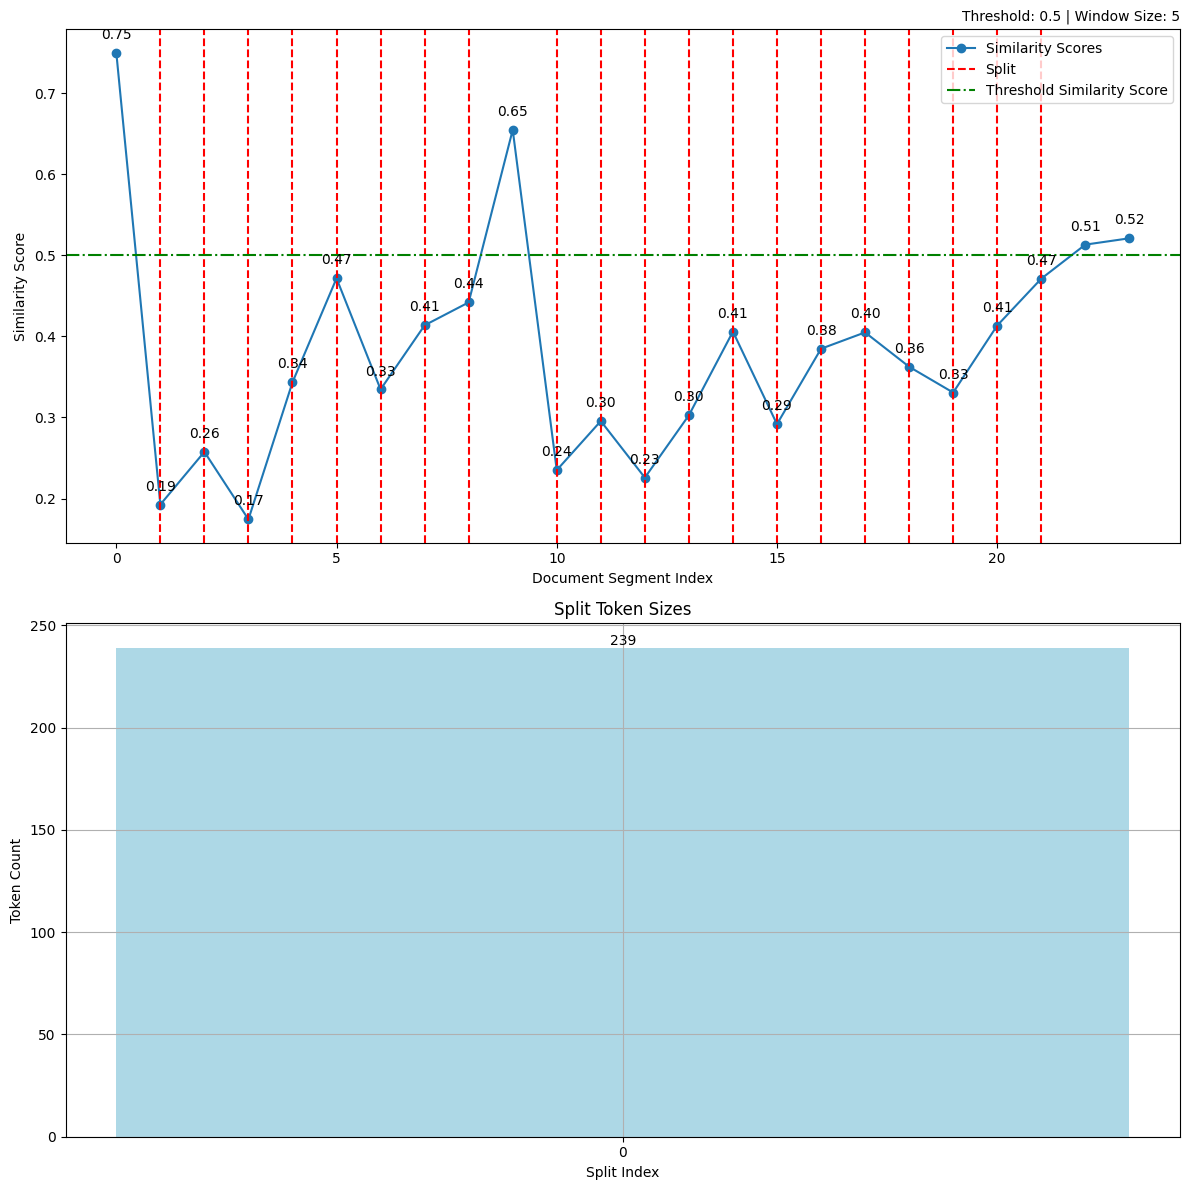

Splitting Statistics:
  - Total Documents: 25
  - Total Splits: 1
  - Splits by Threshold: 0
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 239
  - Maximum Token Size of Split: 239
  - Similarity Split Ratio: 0.00
section_33.txt


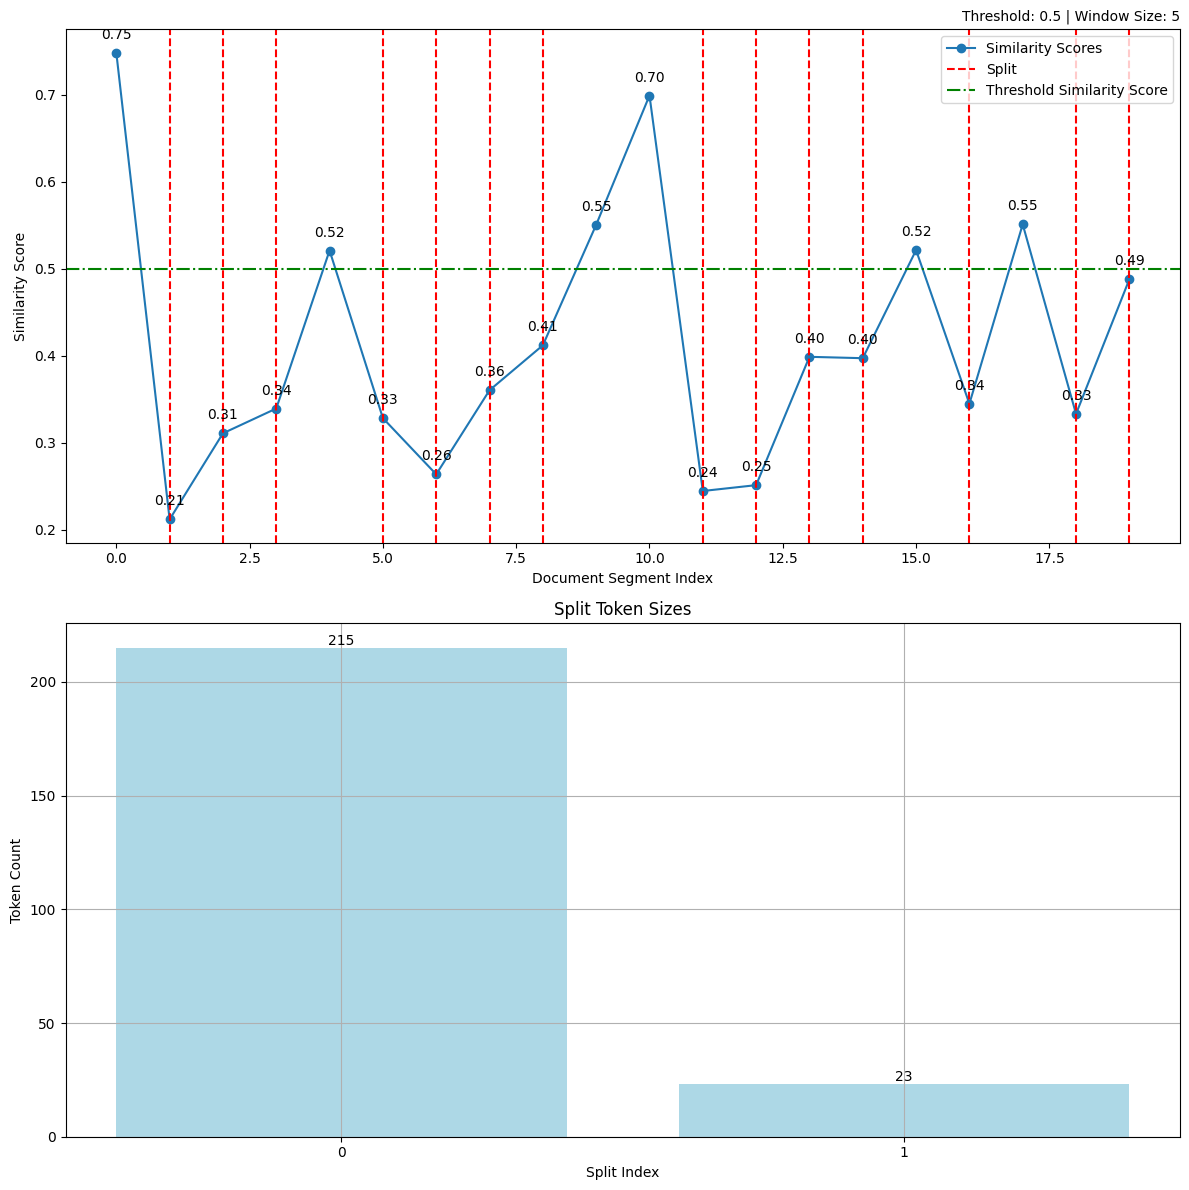

Splitting Statistics:
  - Total Documents: 21
  - Total Splits: 2
  - Splits by Threshold: 1
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 23
  - Maximum Token Size of Split: 215
  - Similarity Split Ratio: 0.50
section_15.txt


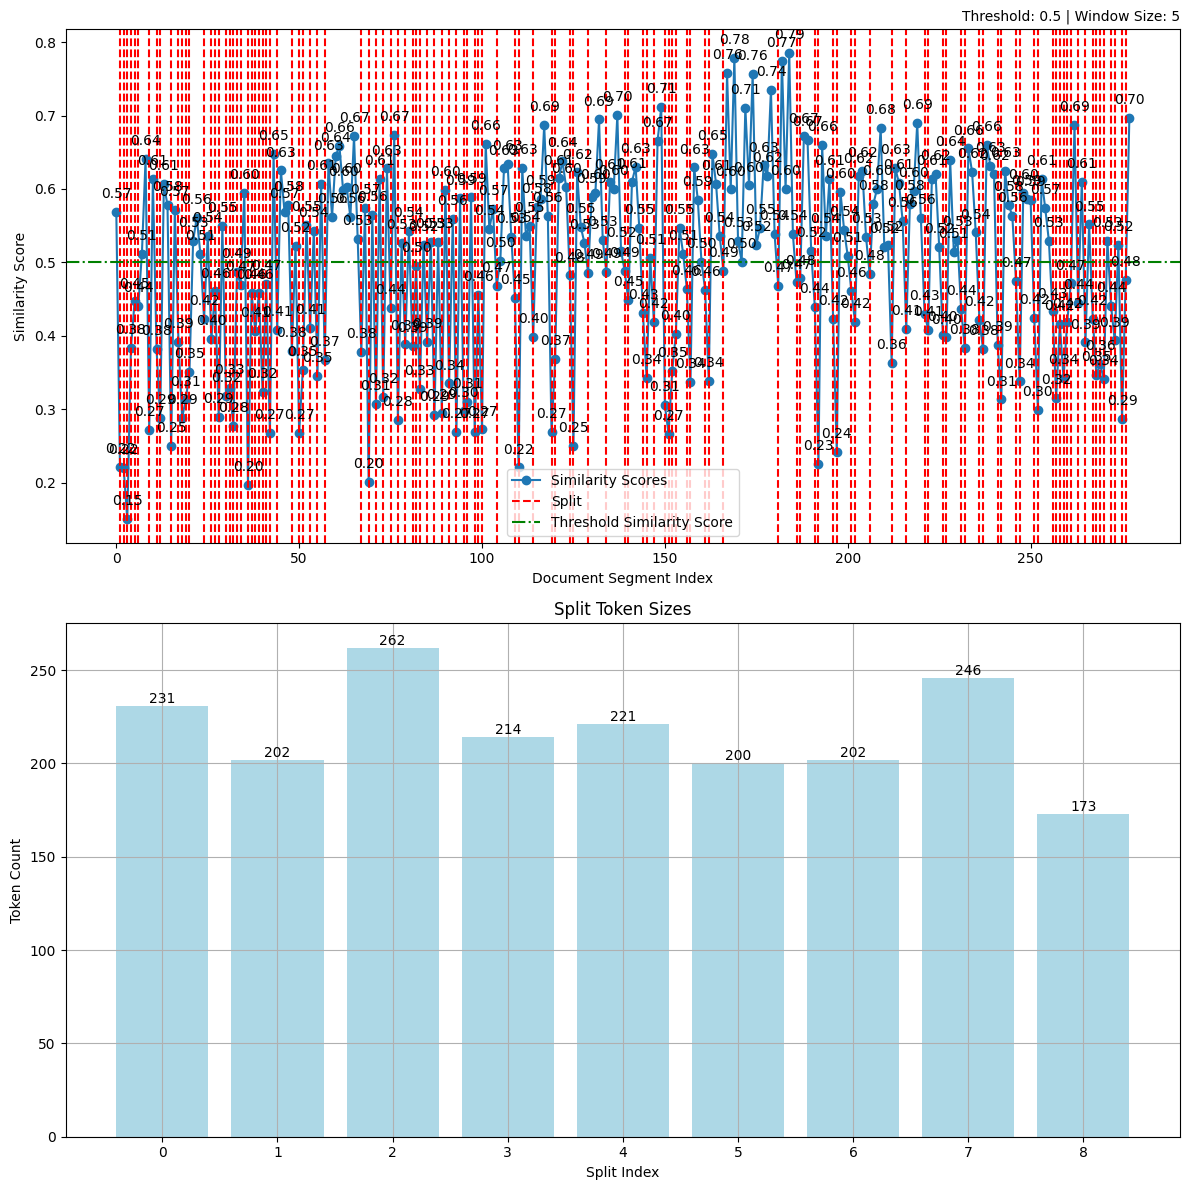

Splitting Statistics:
  - Total Documents: 279
  - Total Splits: 9
  - Splits by Threshold: 8
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 173
  - Maximum Token Size of Split: 262
  - Similarity Split Ratio: 0.89
section_31.txt


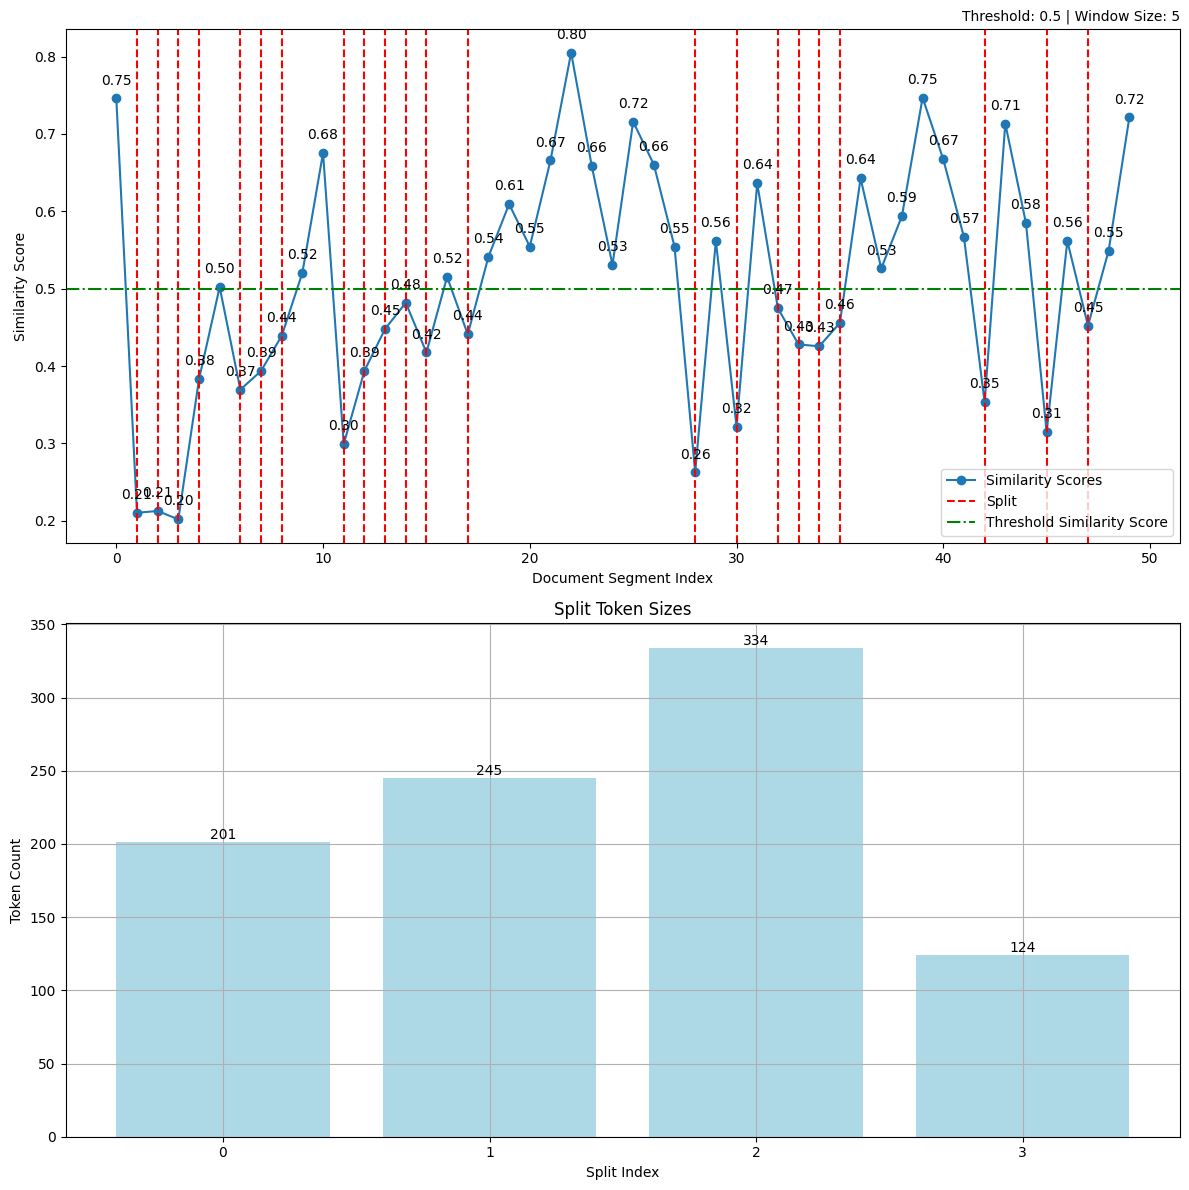

Splitting Statistics:
  - Total Documents: 51
  - Total Splits: 4
  - Splits by Threshold: 3
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 124
  - Maximum Token Size of Split: 334
  - Similarity Split Ratio: 0.75
section_21.txt


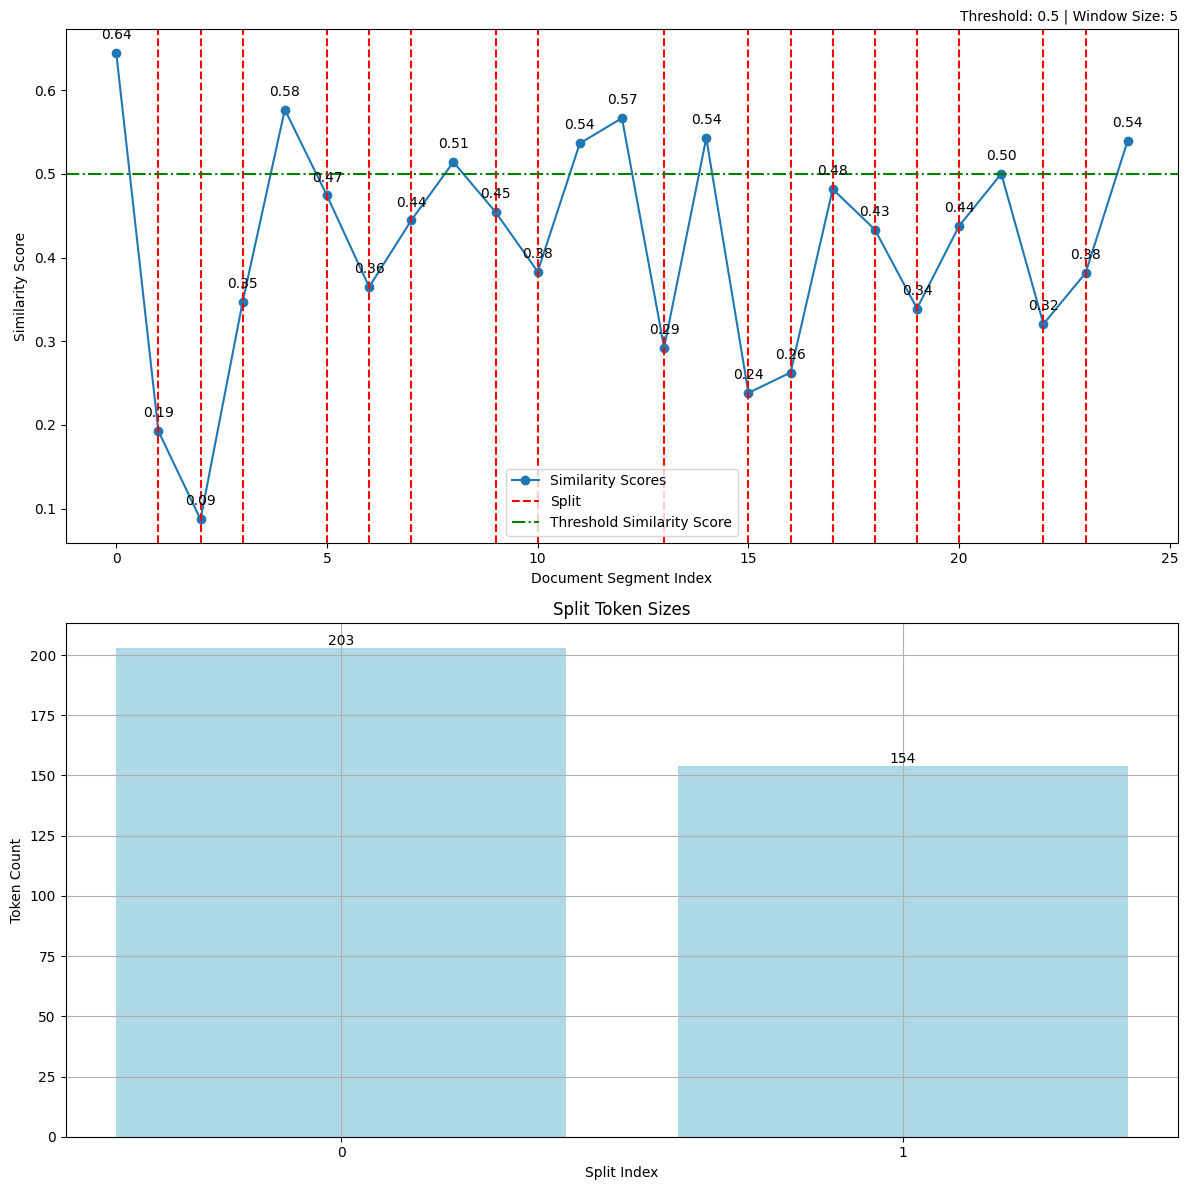

Splitting Statistics:
  - Total Documents: 26
  - Total Splits: 2
  - Splits by Threshold: 1
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 154
  - Maximum Token Size of Split: 203
  - Similarity Split Ratio: 0.50
section_87.txt


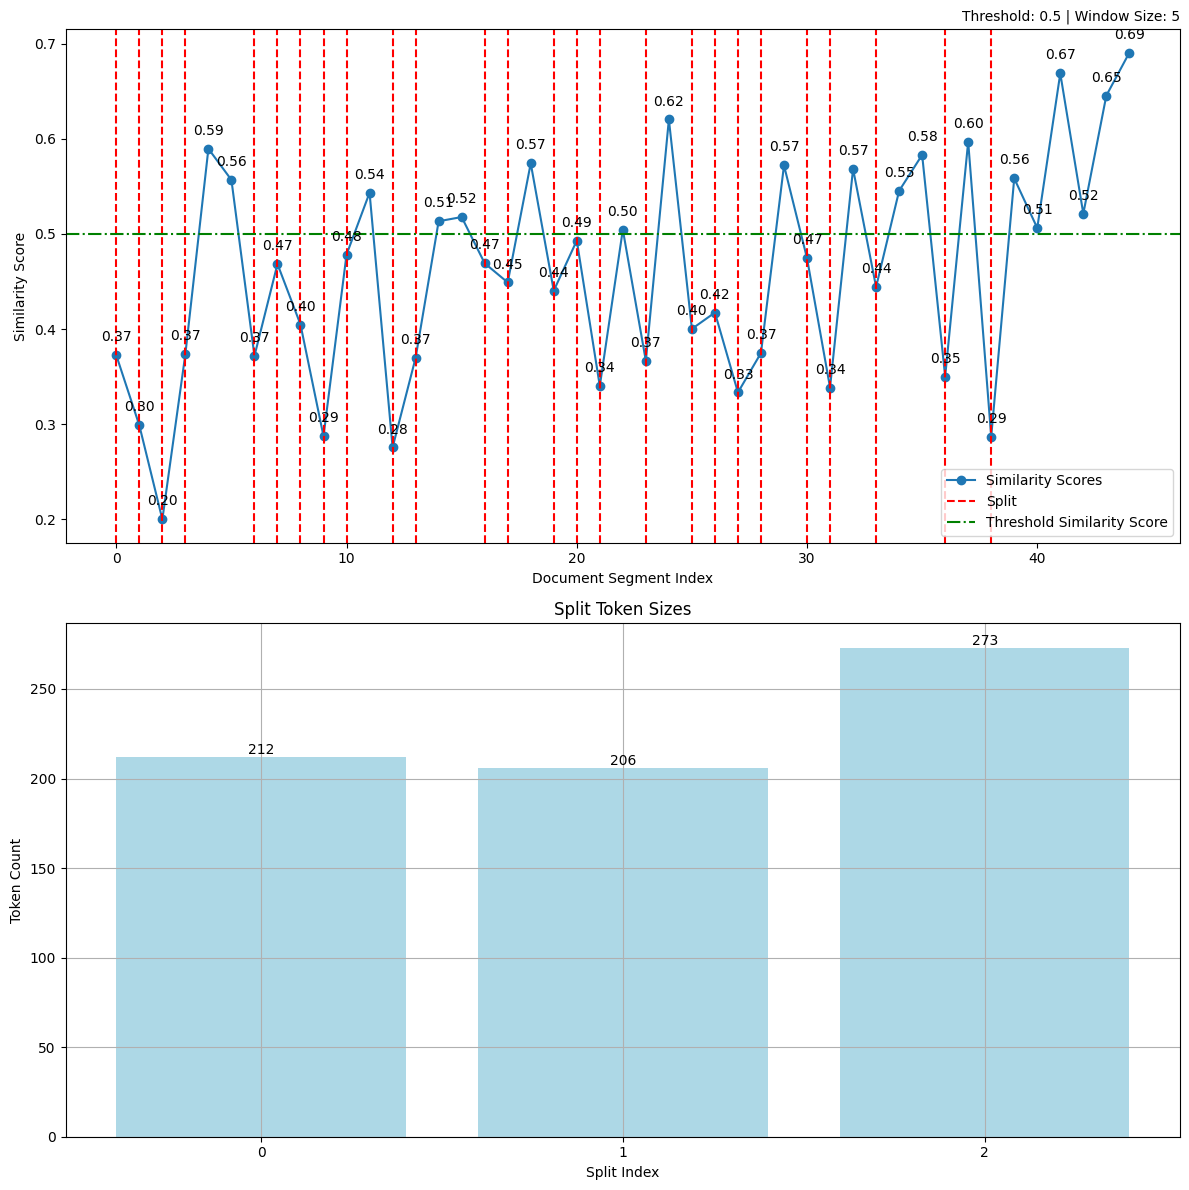

Splitting Statistics:
  - Total Documents: 46
  - Total Splits: 3
  - Splits by Threshold: 2
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 206
  - Maximum Token Size of Split: 273
  - Similarity Split Ratio: 0.67
section_229.txt


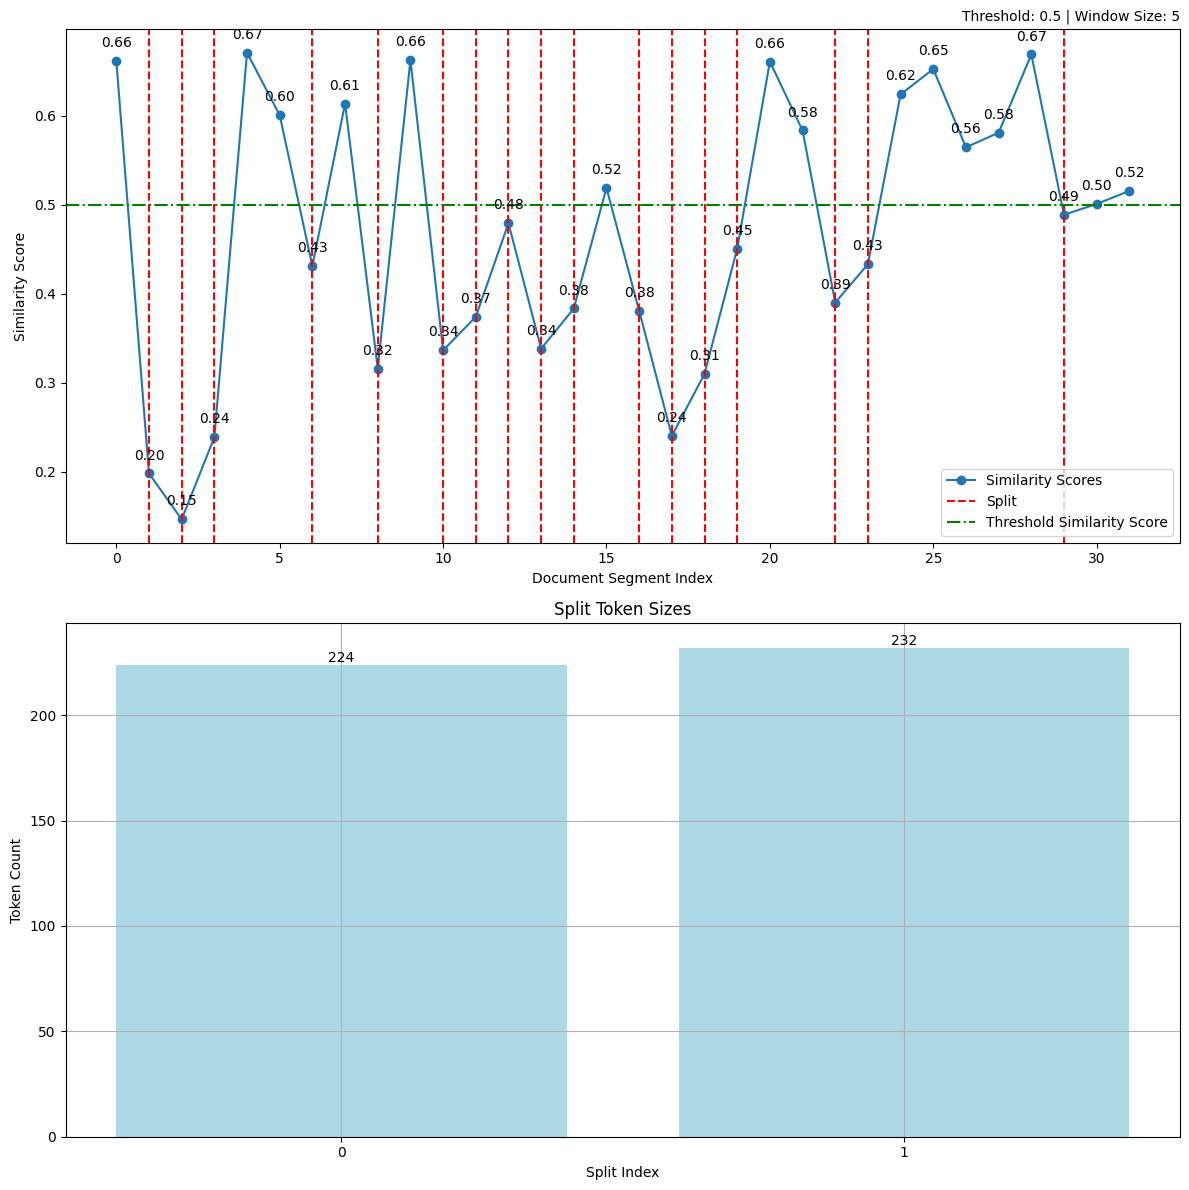

Splitting Statistics:
  - Total Documents: 33
  - Total Splits: 2
  - Splits by Threshold: 1
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 224
  - Maximum Token Size of Split: 232
  - Similarity Split Ratio: 0.50
section_28.txt


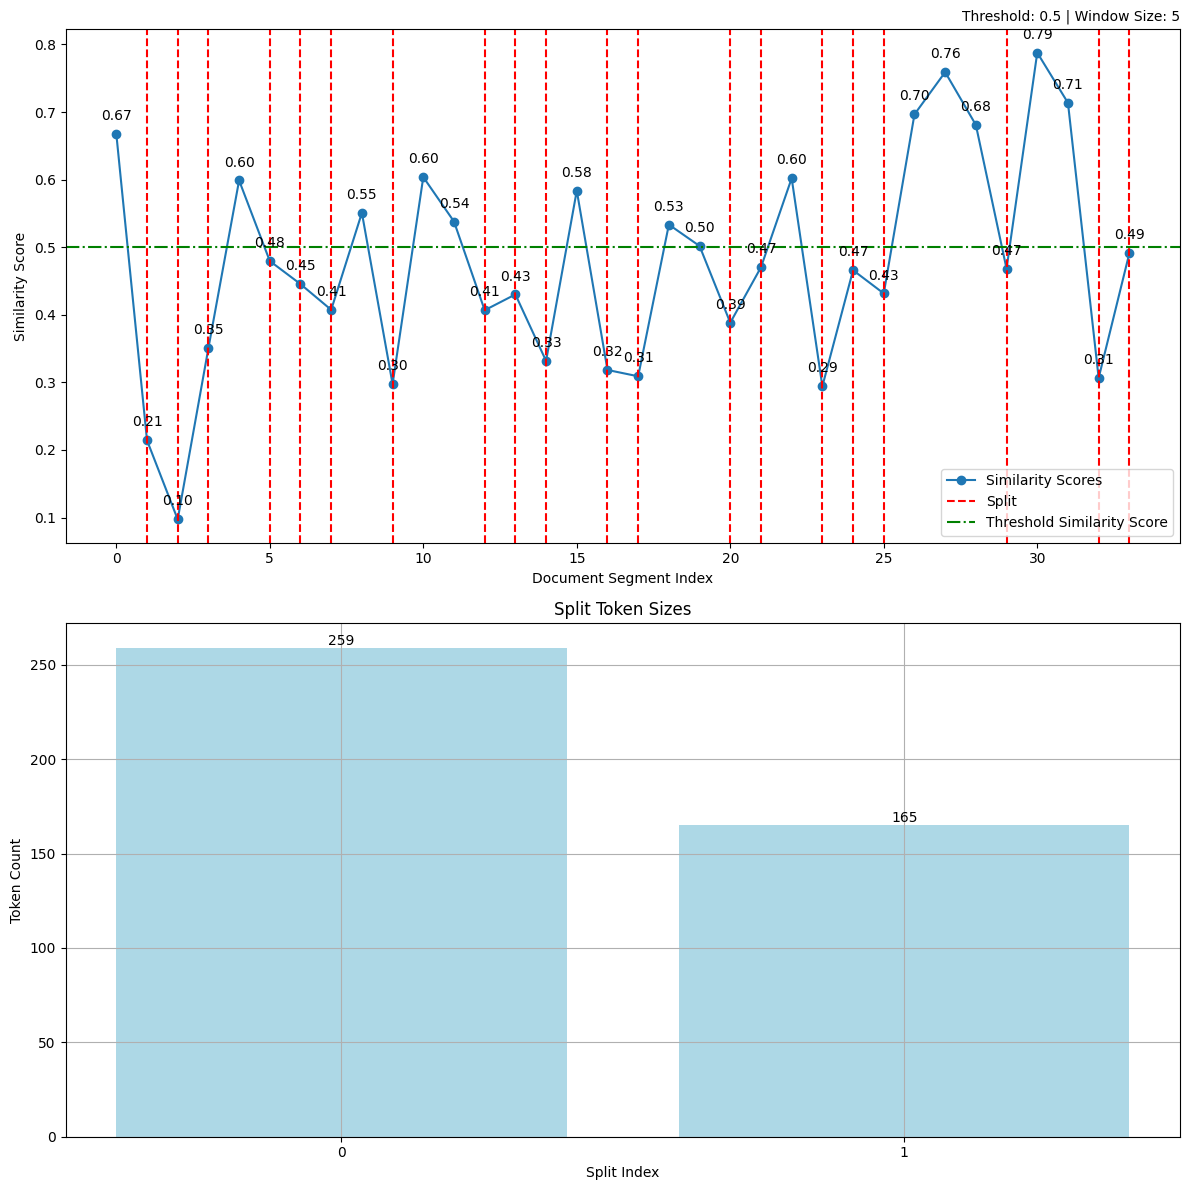

Splitting Statistics:
  - Total Documents: 35
  - Total Splits: 2
  - Splits by Threshold: 1
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 165
  - Maximum Token Size of Split: 259
  - Similarity Split Ratio: 0.50
section_192.txt


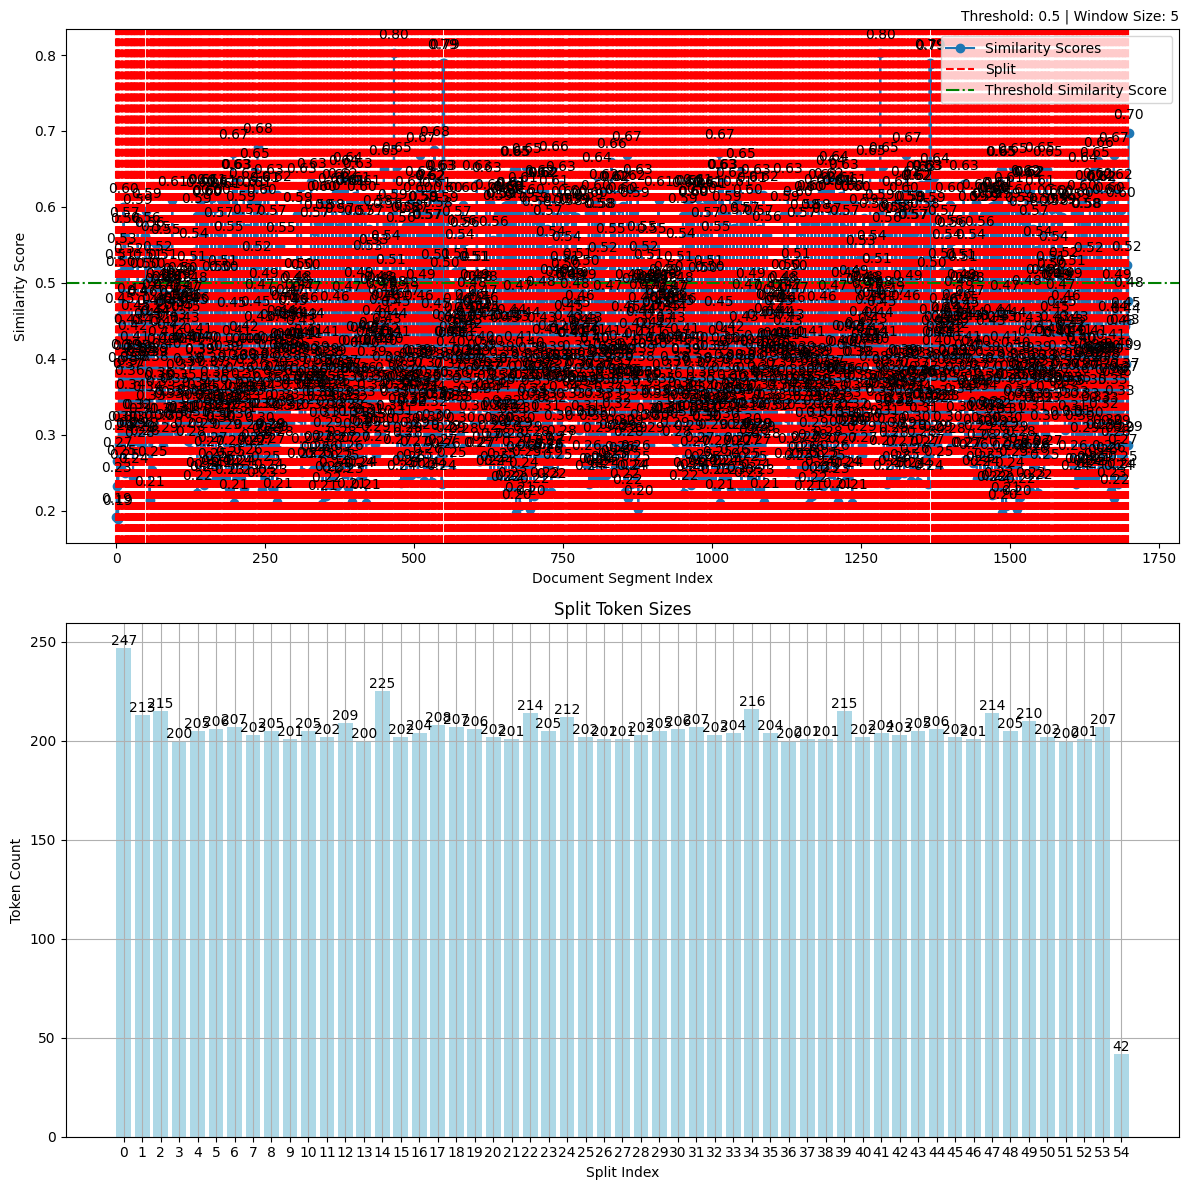

Splitting Statistics:
  - Total Documents: 1701
  - Total Splits: 55
  - Splits by Threshold: 54
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 42
  - Maximum Token Size of Split: 247
  - Similarity Split Ratio: 0.98
section_122.txt


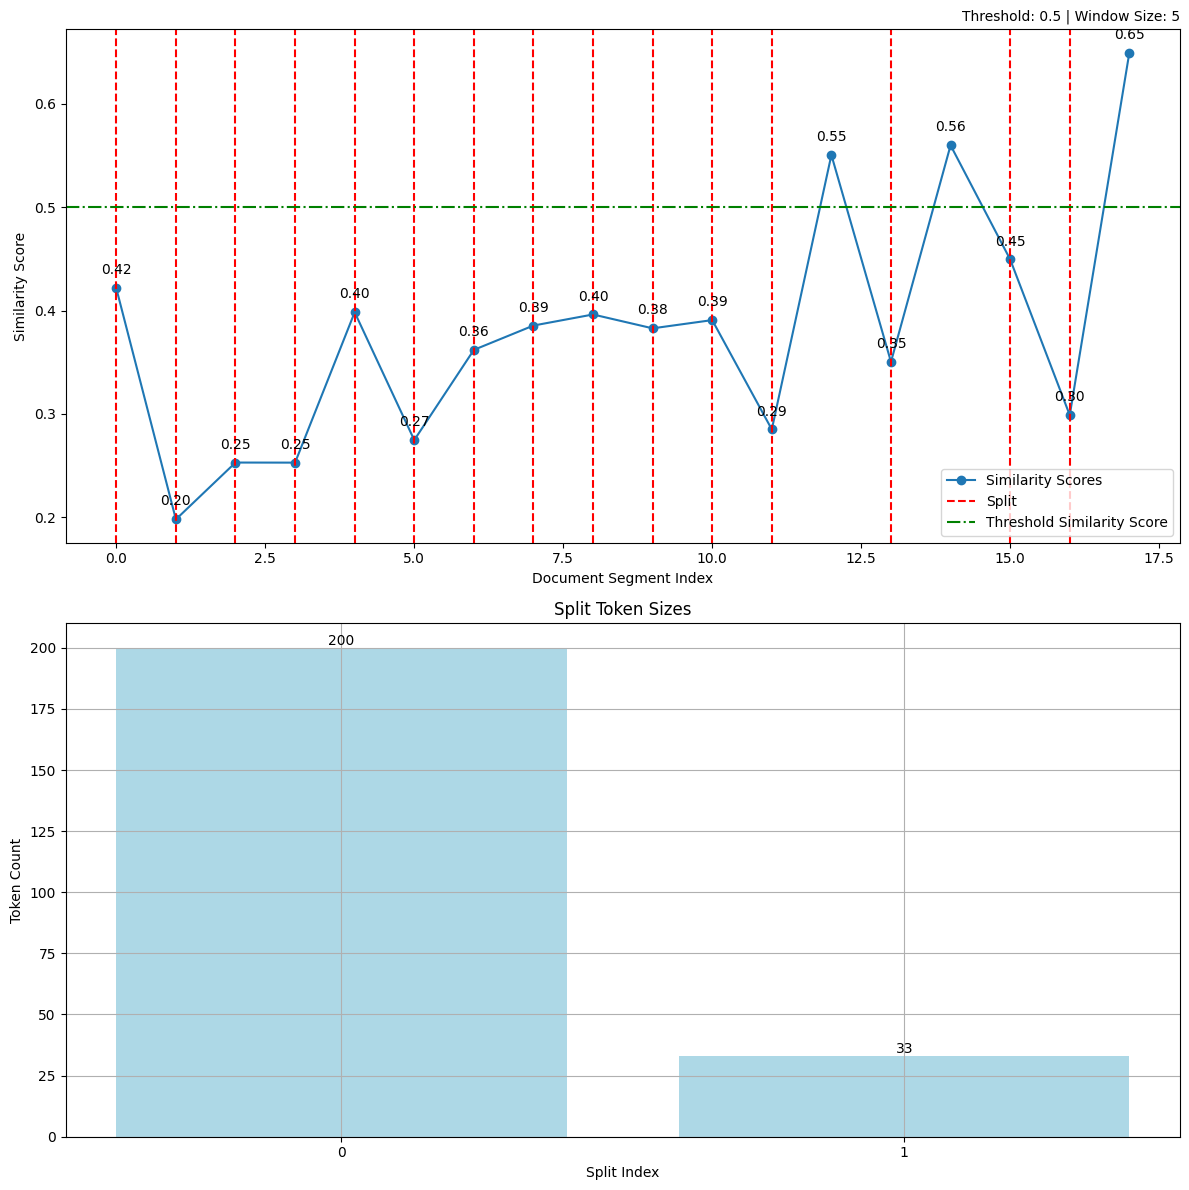

Splitting Statistics:
  - Total Documents: 19
  - Total Splits: 2
  - Splits by Threshold: 1
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 33
  - Maximum Token Size of Split: 200
  - Similarity Split Ratio: 0.50
section_1.txt


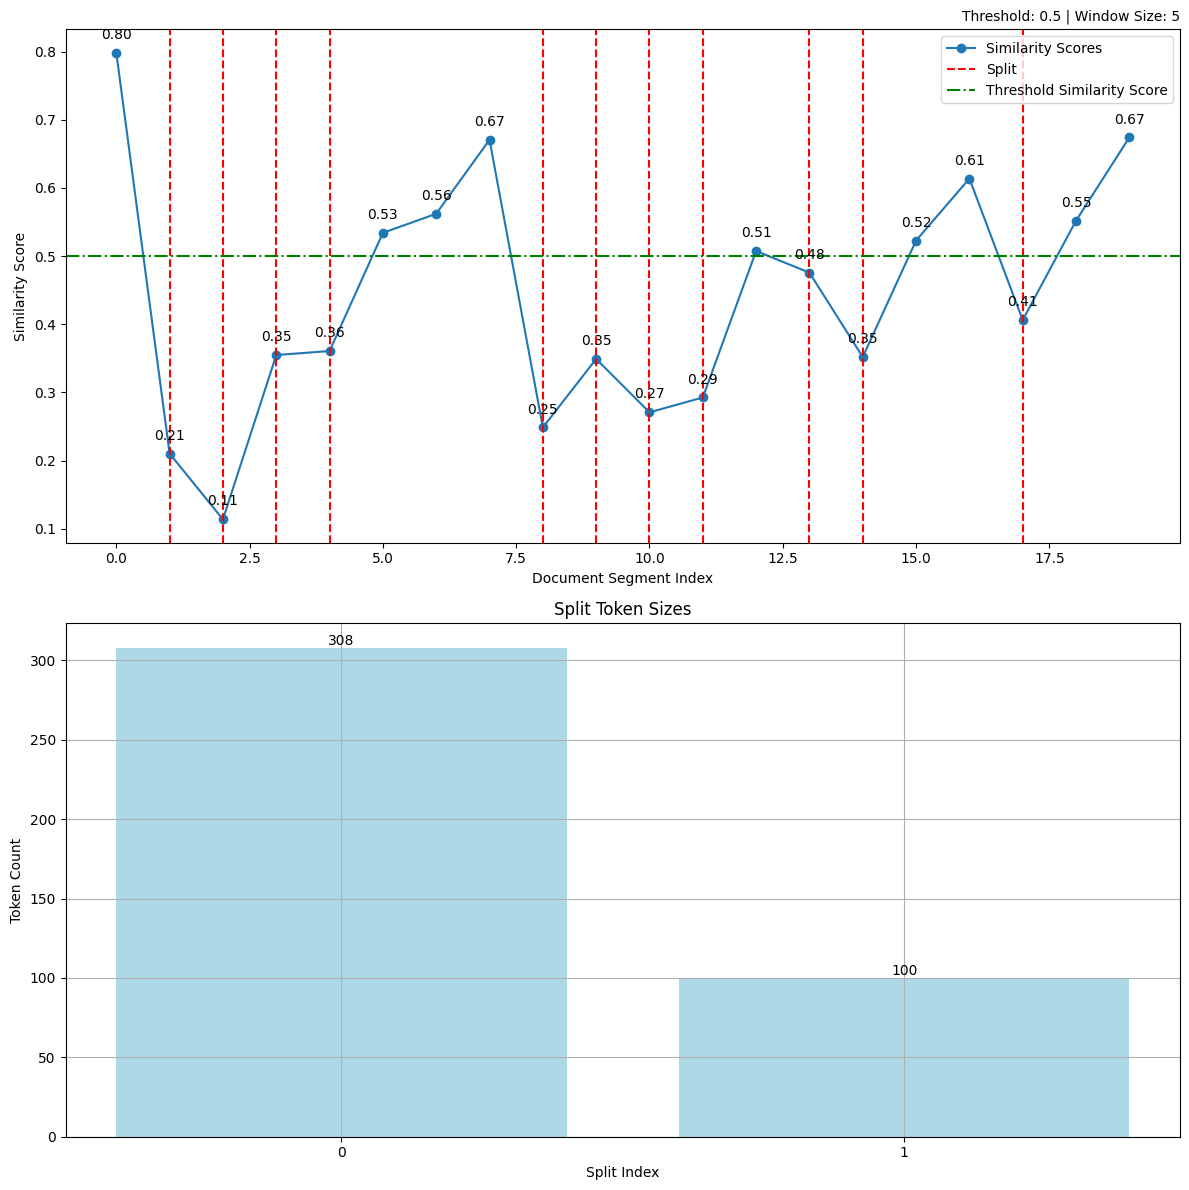

Splitting Statistics:
  - Total Documents: 21
  - Total Splits: 2
  - Splits by Threshold: 1
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 100
  - Maximum Token Size of Split: 308
  - Similarity Split Ratio: 0.50
section_9.txt


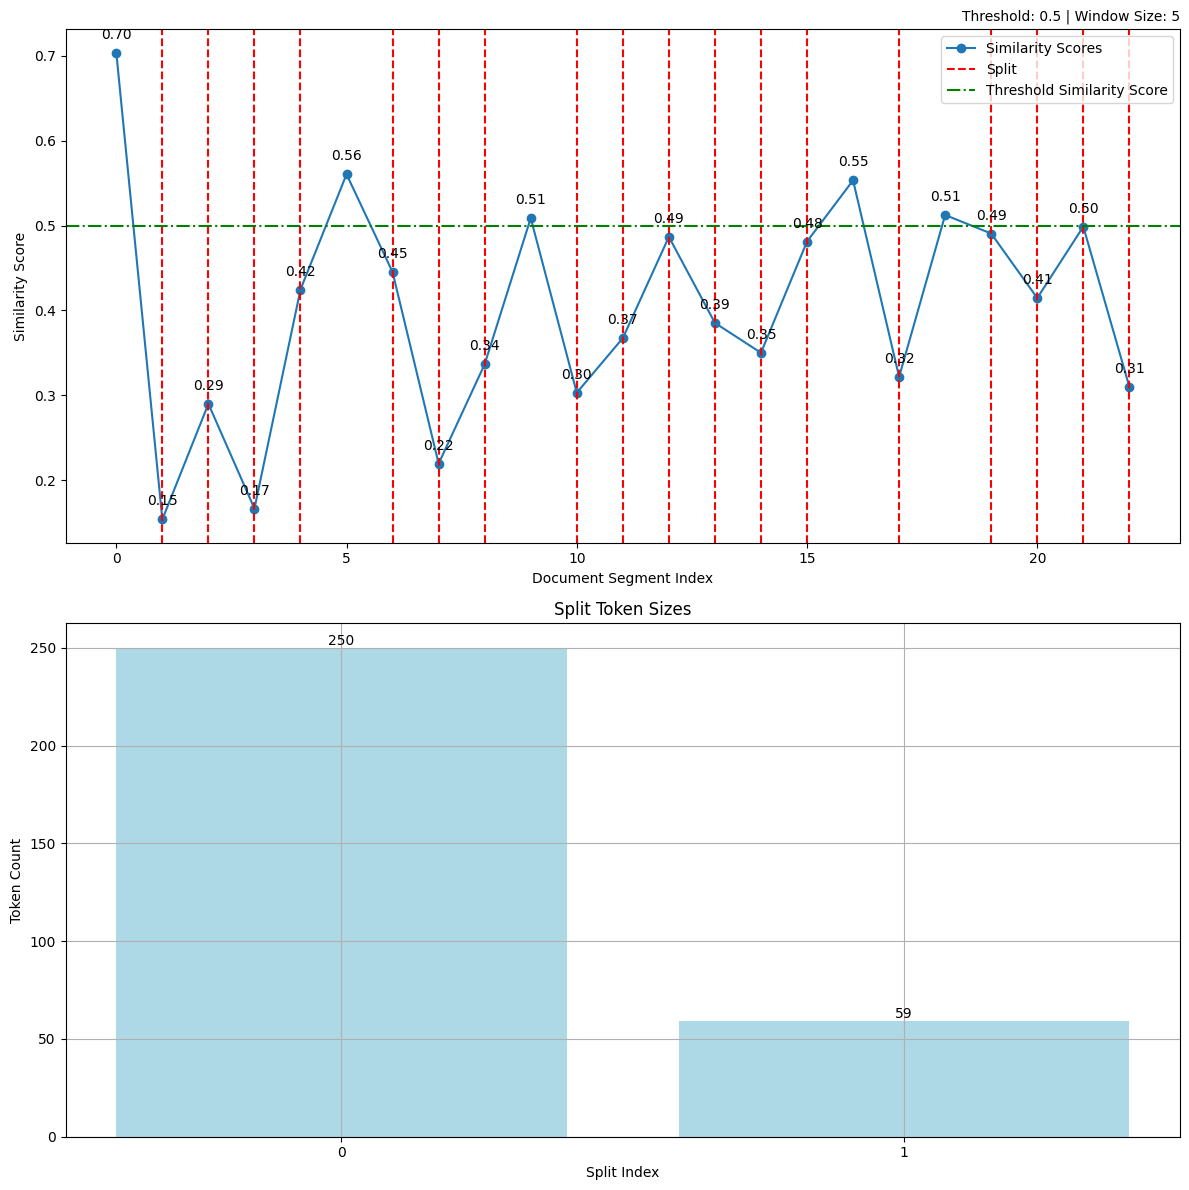

Splitting Statistics:
  - Total Documents: 24
  - Total Splits: 2
  - Splits by Threshold: 1
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 59
  - Maximum Token Size of Split: 250
  - Similarity Split Ratio: 0.50
section_11.txt


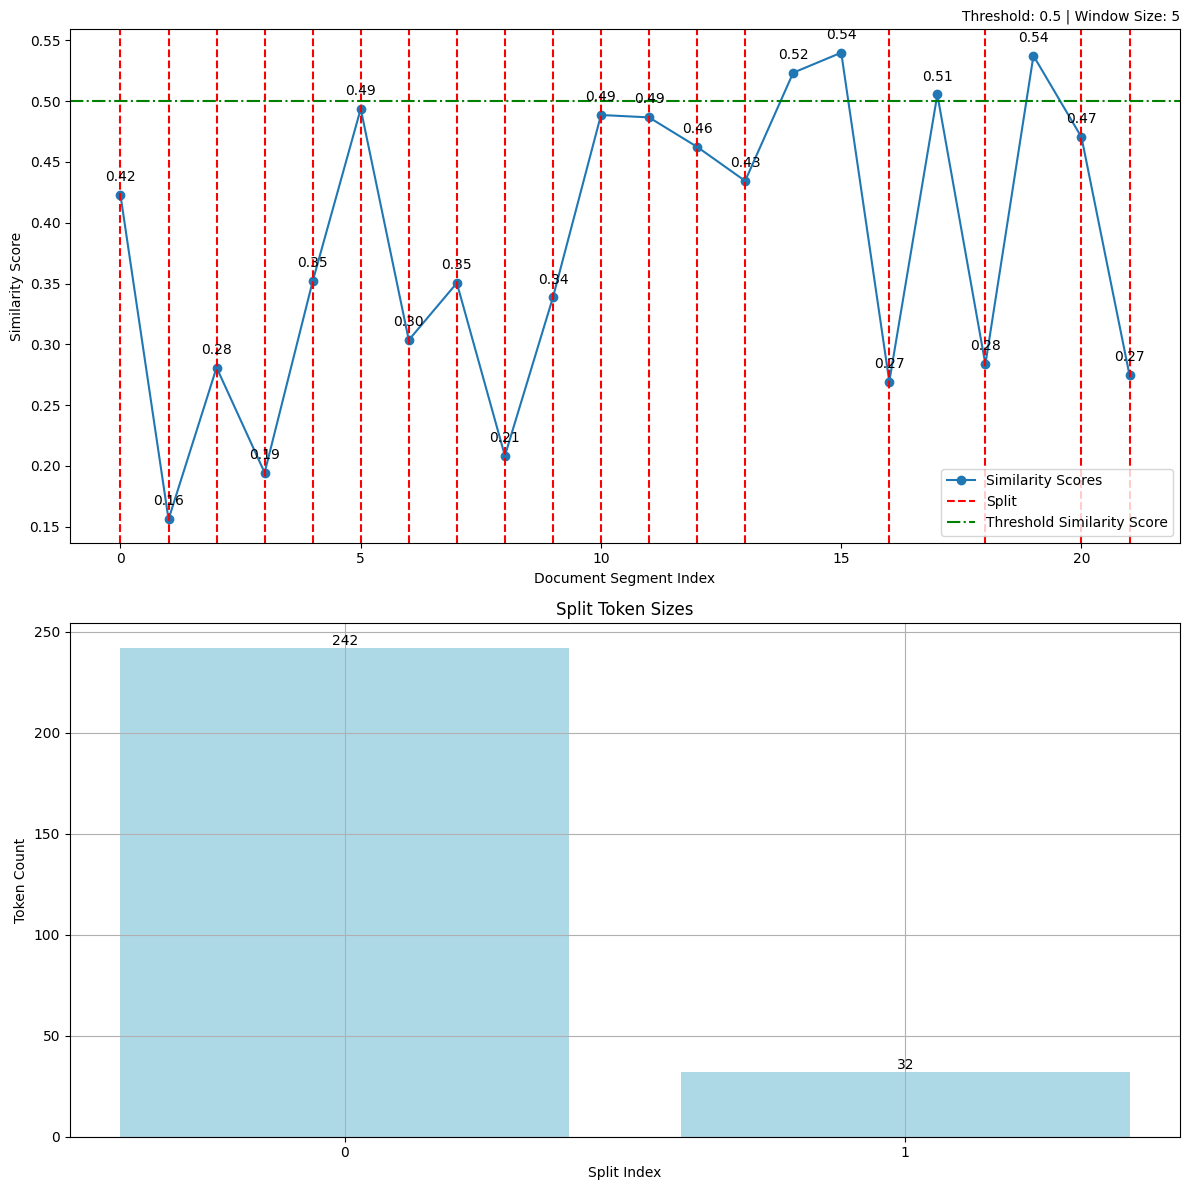

Splitting Statistics:
  - Total Documents: 23
  - Total Splits: 2
  - Splits by Threshold: 1
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 32
  - Maximum Token Size of Split: 242
  - Similarity Split Ratio: 0.50
section_17.txt


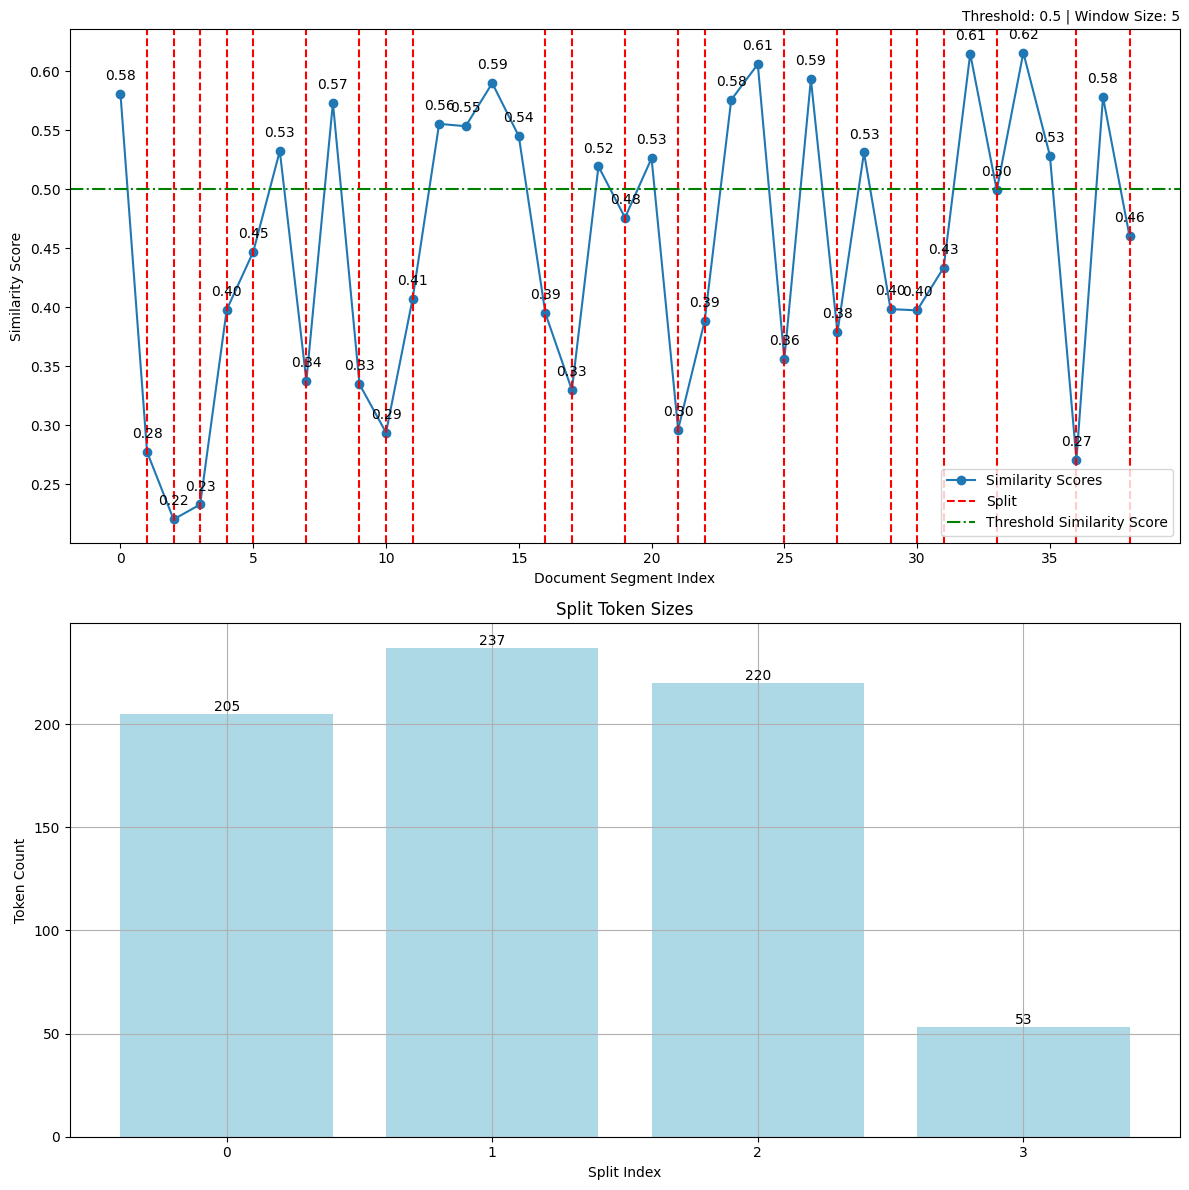

Splitting Statistics:
  - Total Documents: 40
  - Total Splits: 4
  - Splits by Threshold: 3
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 53
  - Maximum Token Size of Split: 237
  - Similarity Split Ratio: 0.75
section_137.txt


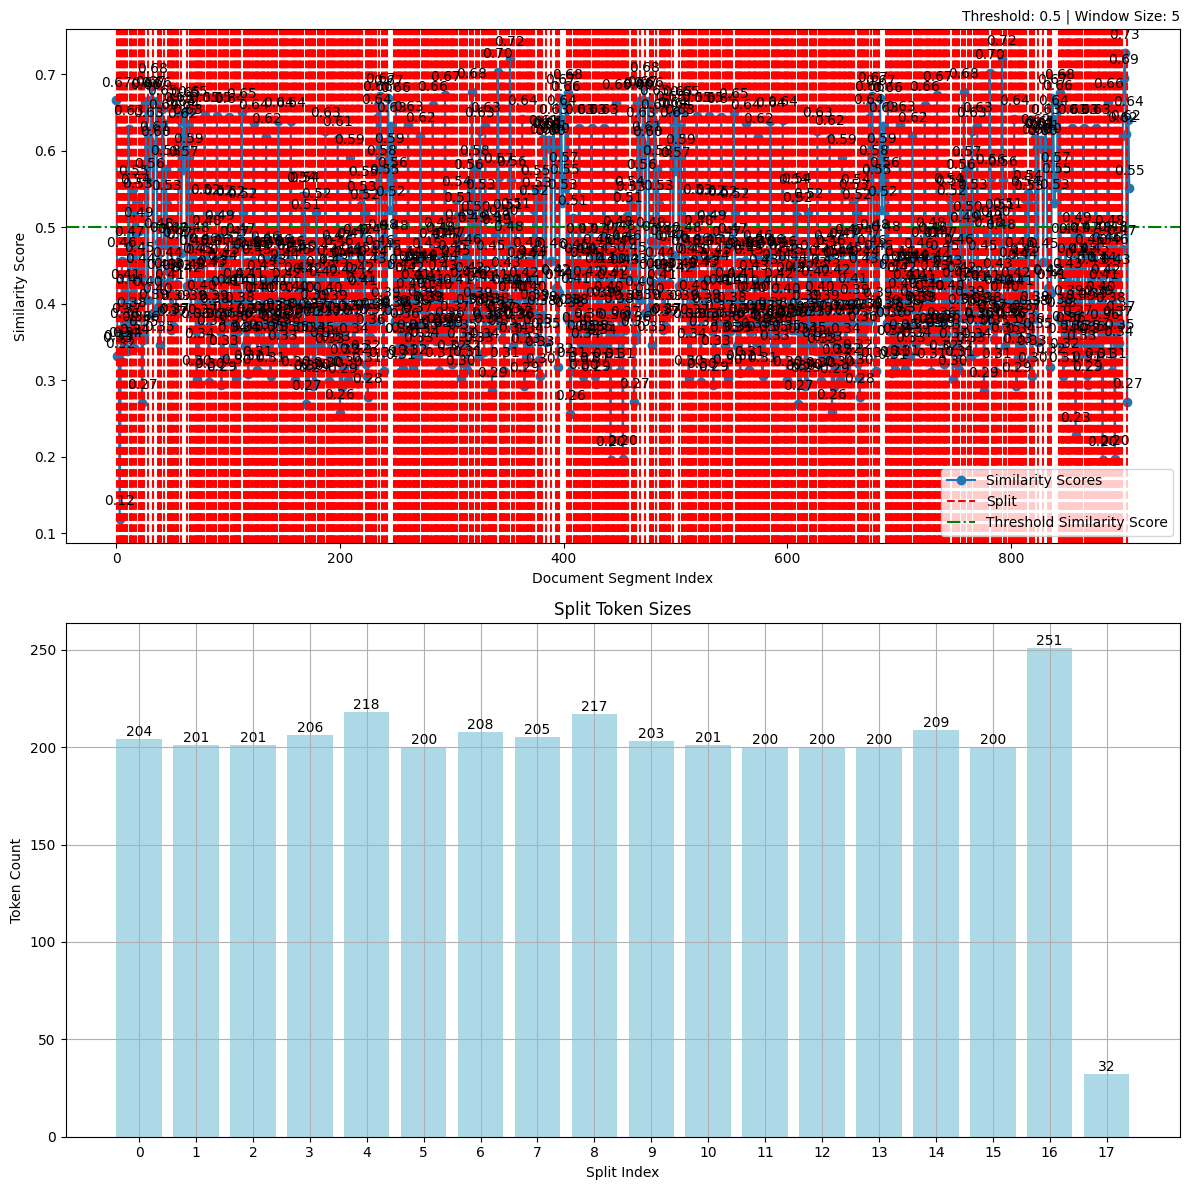

Splitting Statistics:
  - Total Documents: 908
  - Total Splits: 18
  - Splits by Threshold: 17
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 32
  - Maximum Token Size of Split: 251
  - Similarity Split Ratio: 0.94
section_38.txt


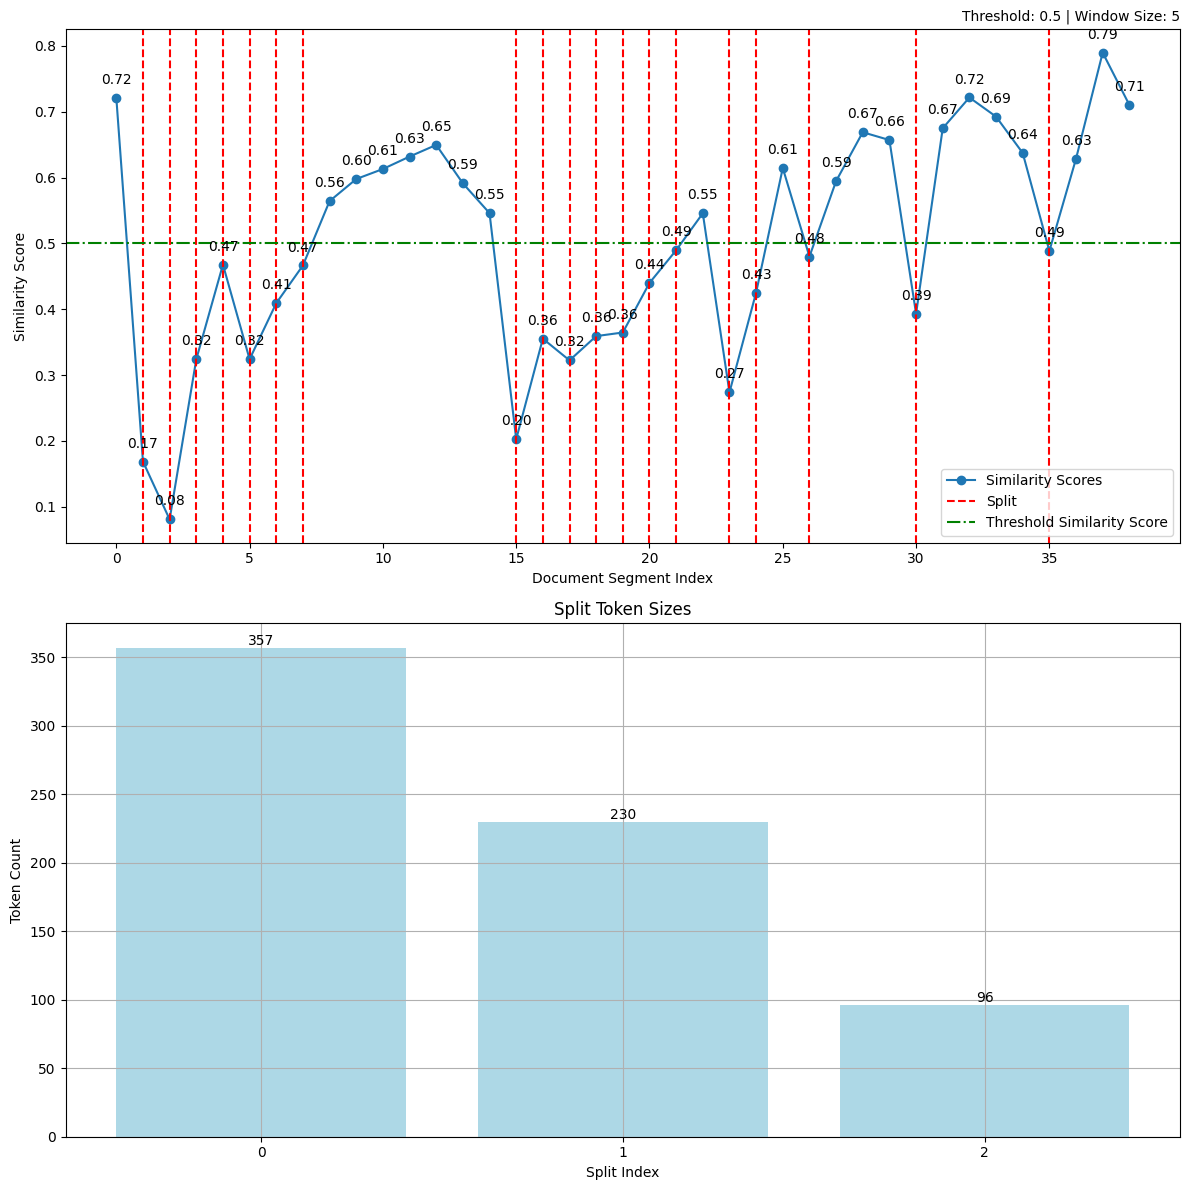

Splitting Statistics:
  - Total Documents: 40
  - Total Splits: 3
  - Splits by Threshold: 2
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 96
  - Maximum Token Size of Split: 357
  - Similarity Split Ratio: 0.67
section_3.txt


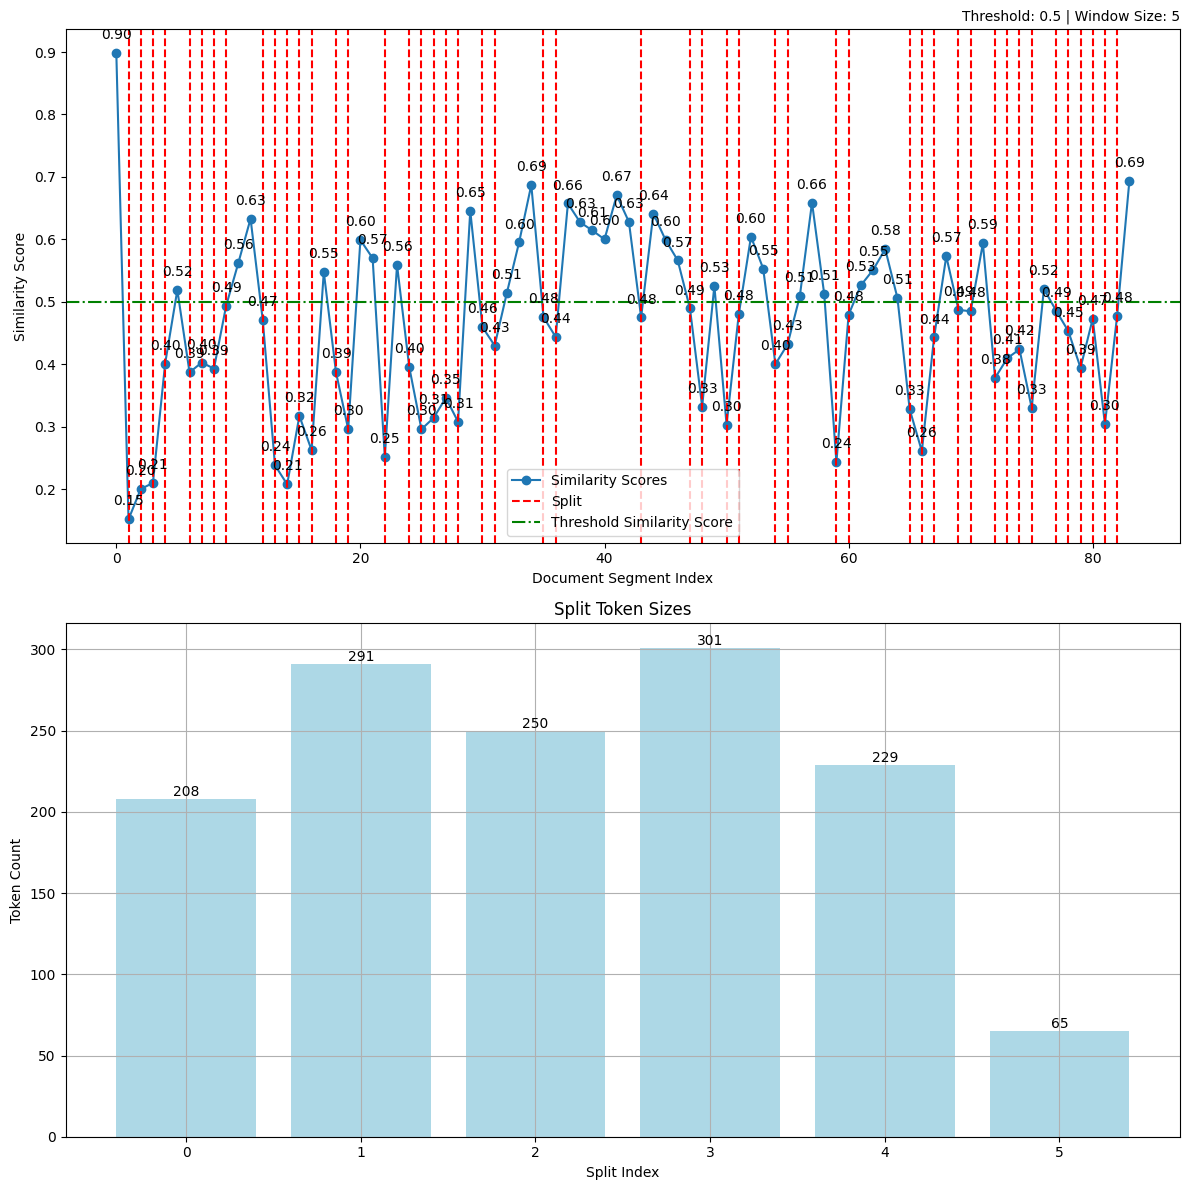

Splitting Statistics:
  - Total Documents: 85
  - Total Splits: 6
  - Splits by Threshold: 5
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 65
  - Maximum Token Size of Split: 301
  - Similarity Split Ratio: 0.83
section_29.txt


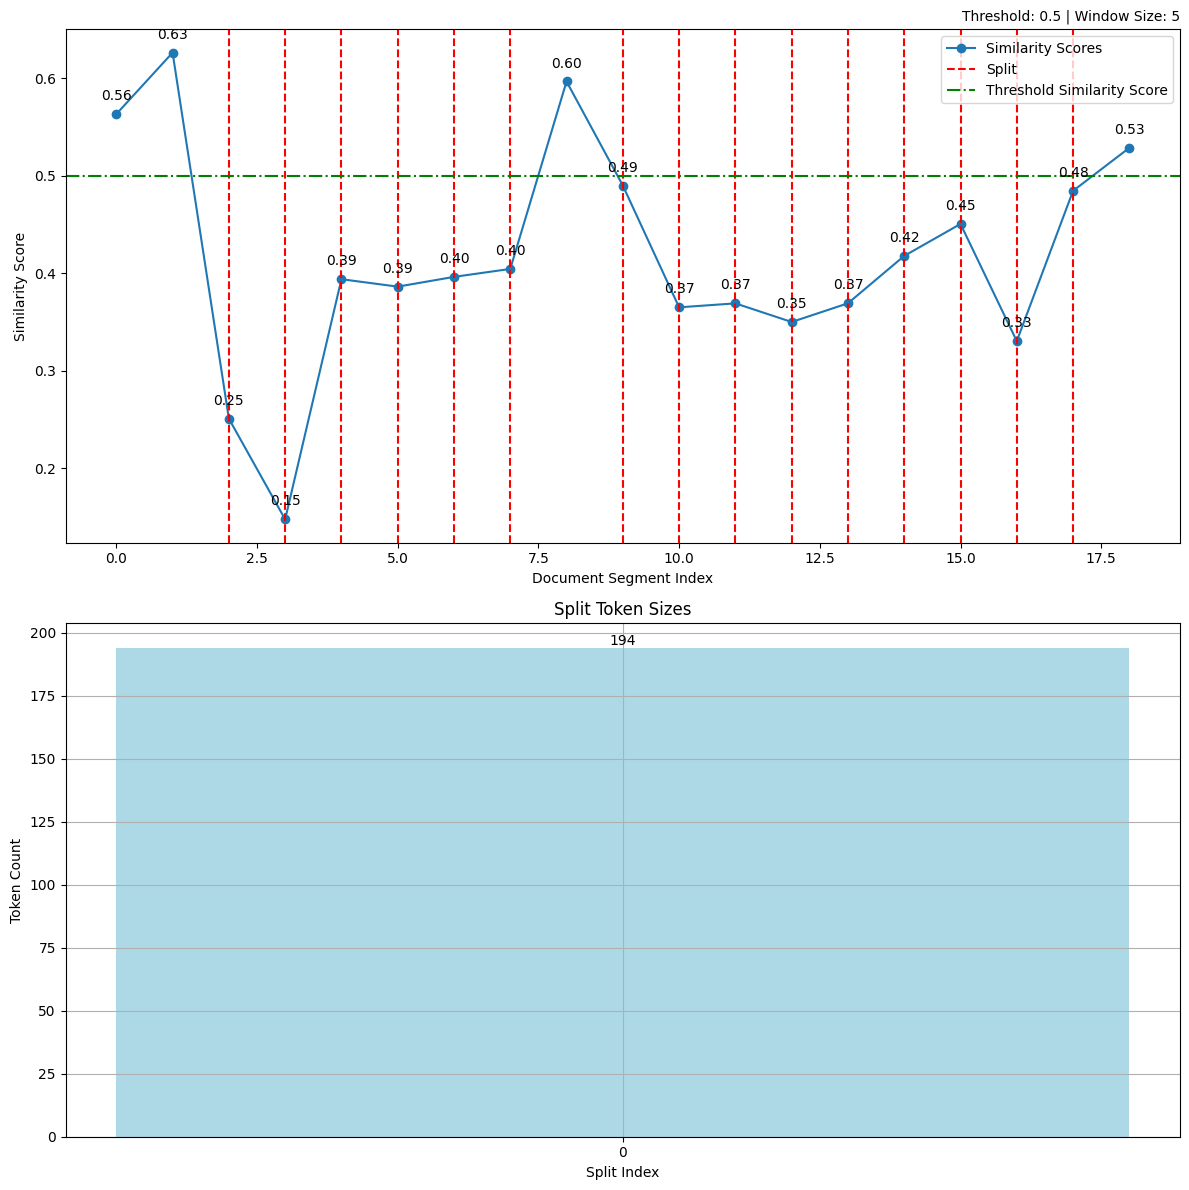

Splitting Statistics:
  - Total Documents: 20
  - Total Splits: 1
  - Splits by Threshold: 0
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 194
  - Maximum Token Size of Split: 194
  - Similarity Split Ratio: 0.00
section_176.txt


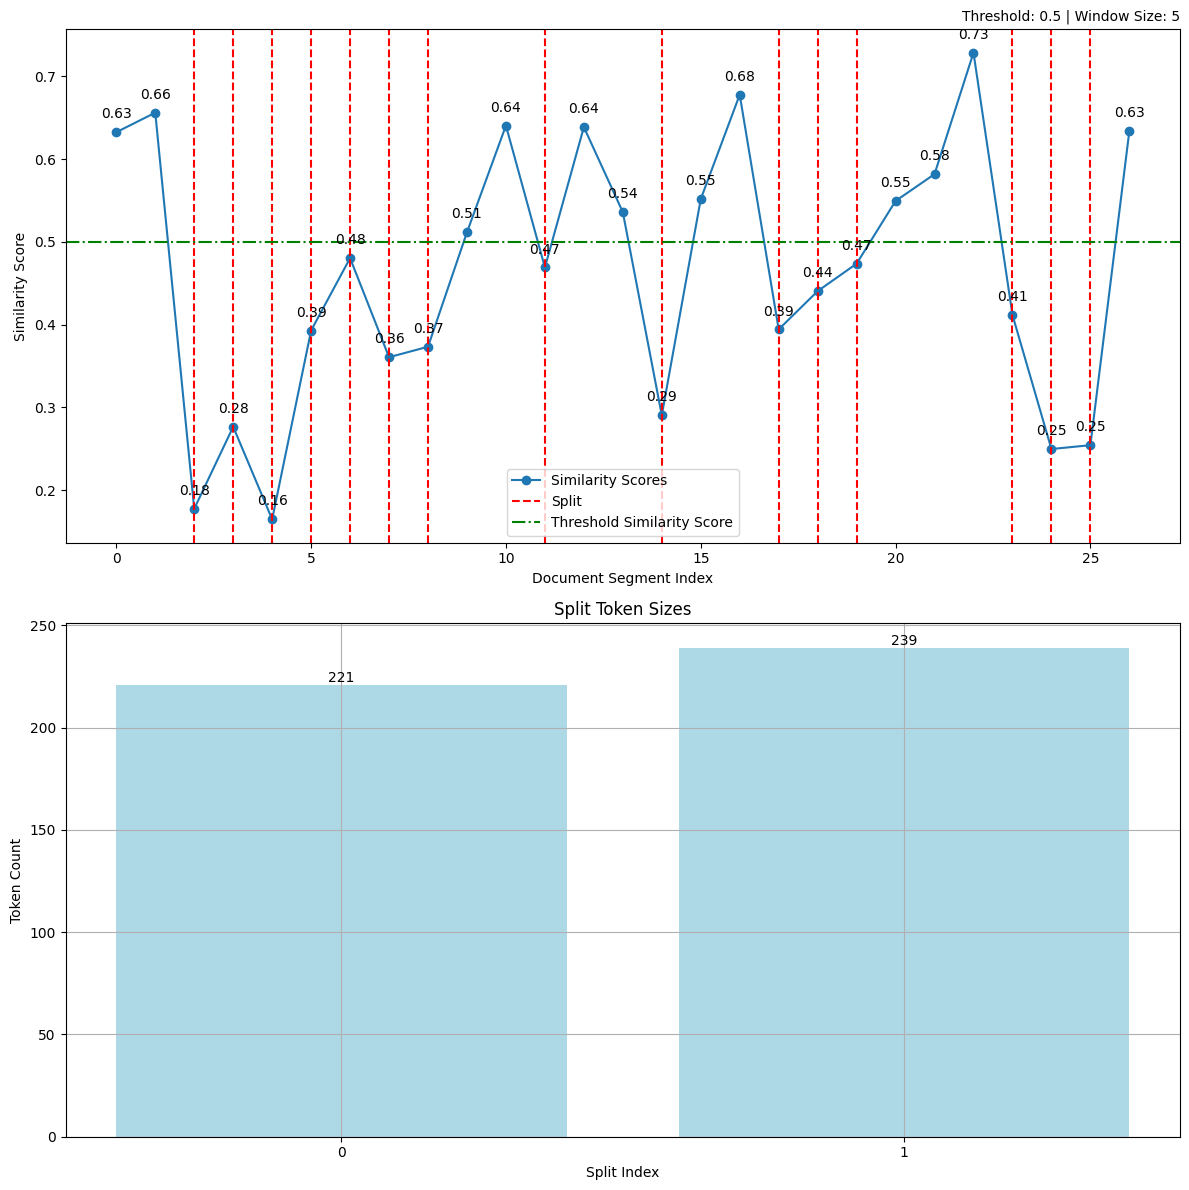

Splitting Statistics:
  - Total Documents: 28
  - Total Splits: 2
  - Splits by Threshold: 1
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 221
  - Maximum Token Size of Split: 239
  - Similarity Split Ratio: 0.50
section_18.txt


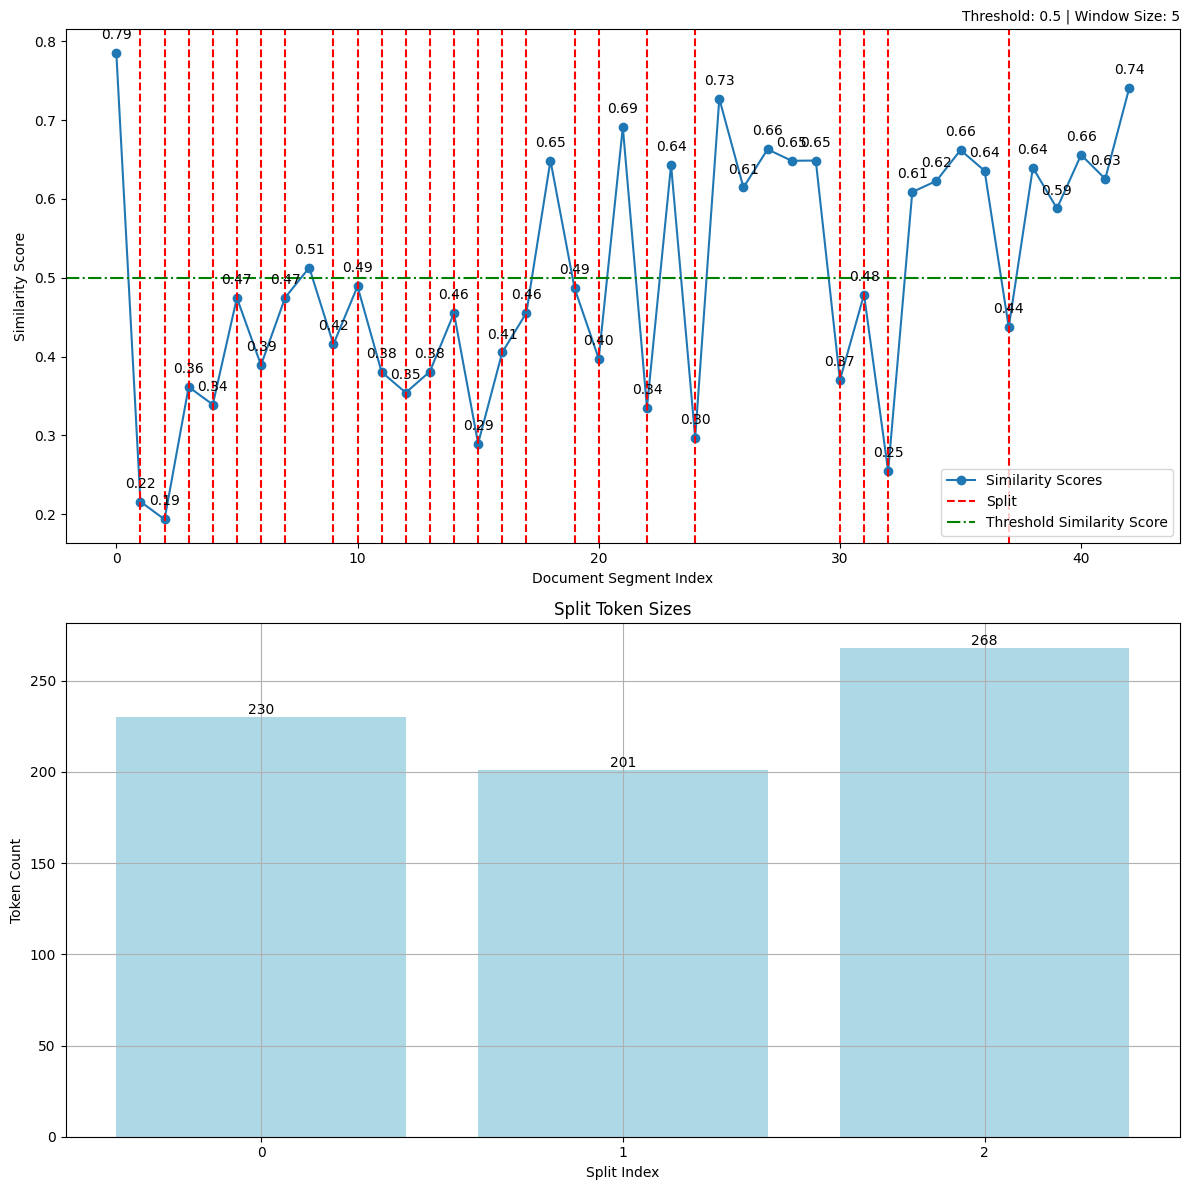

Splitting Statistics:
  - Total Documents: 44
  - Total Splits: 3
  - Splits by Threshold: 2
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 201
  - Maximum Token Size of Split: 268
  - Similarity Split Ratio: 0.67
section_39.txt


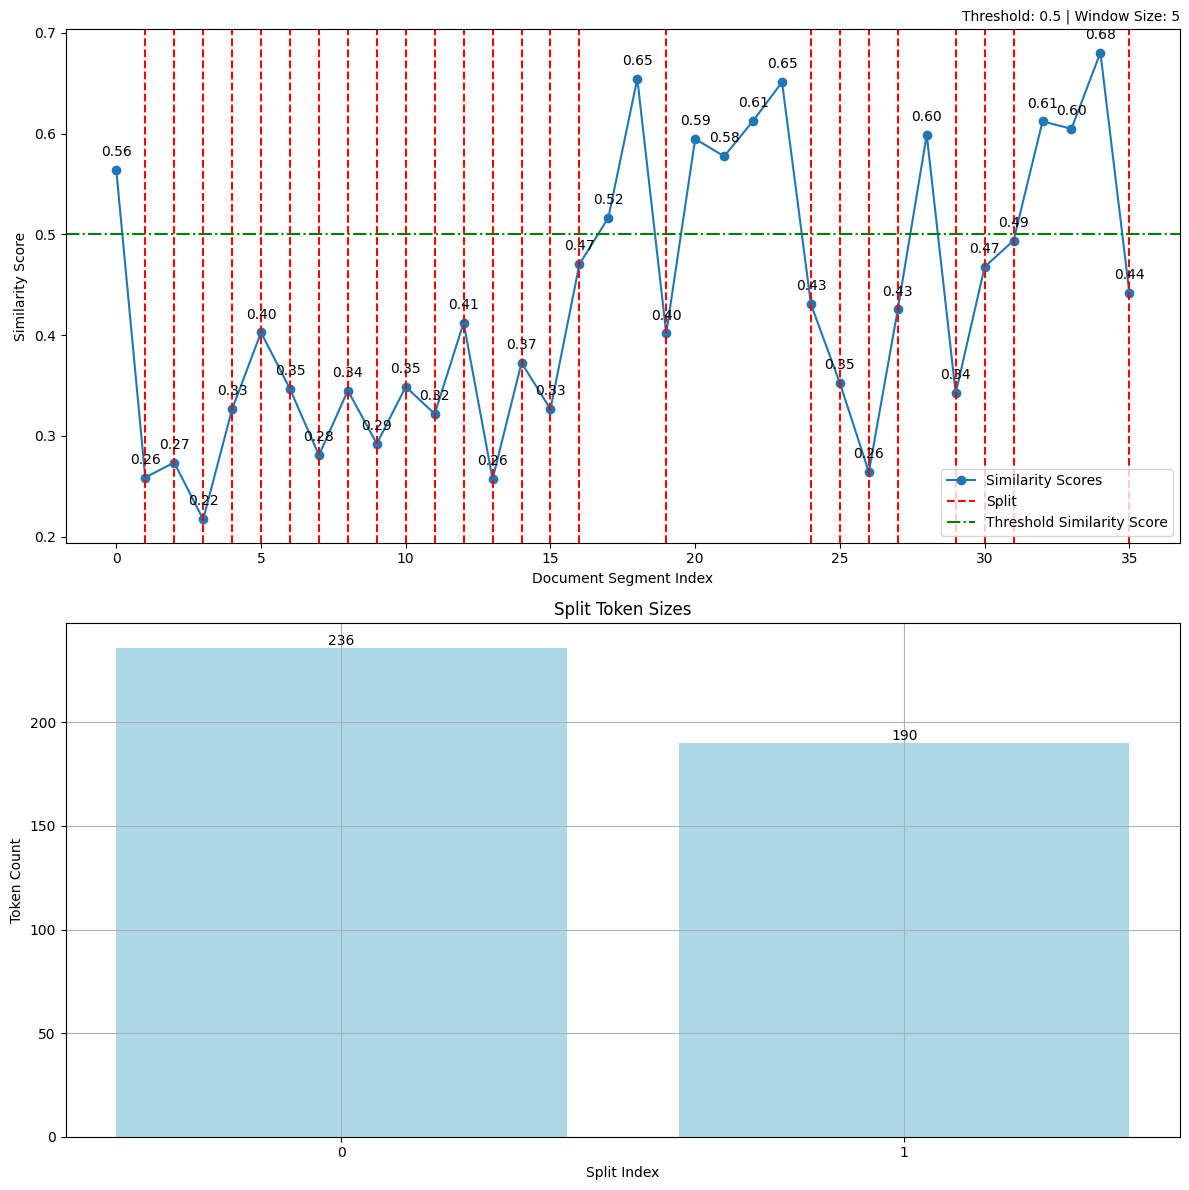

Splitting Statistics:
  - Total Documents: 37
  - Total Splits: 2
  - Splits by Threshold: 1
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 190
  - Maximum Token Size of Split: 236
  - Similarity Split Ratio: 0.50
section_32.txt


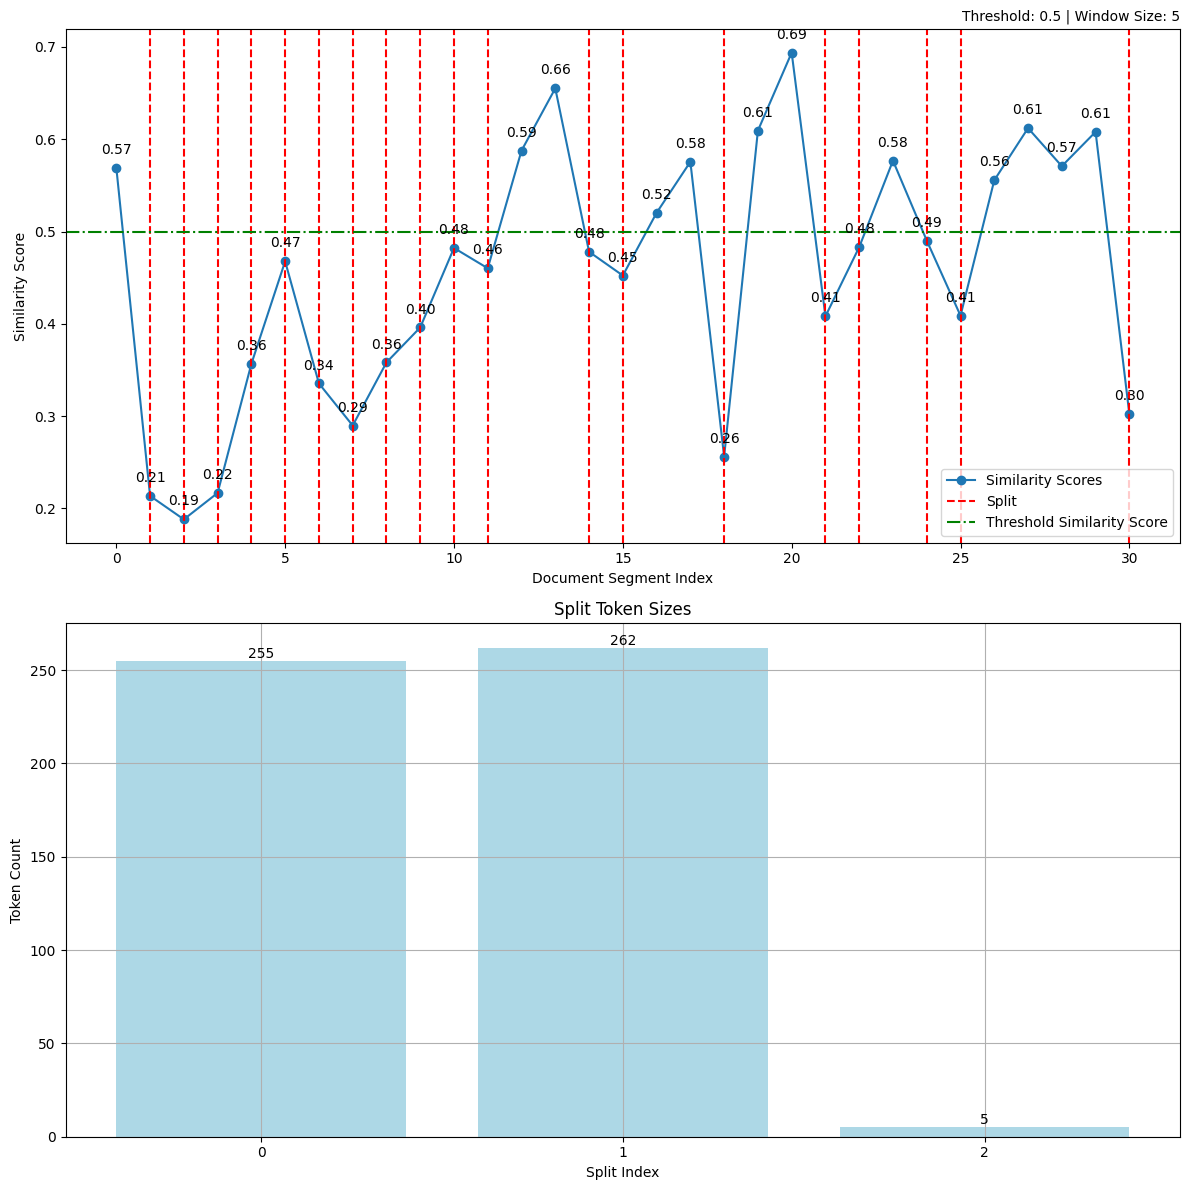

Splitting Statistics:
  - Total Documents: 32
  - Total Splits: 3
  - Splits by Threshold: 2
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 5
  - Maximum Token Size of Split: 262
  - Similarity Split Ratio: 0.67
section_16.txt


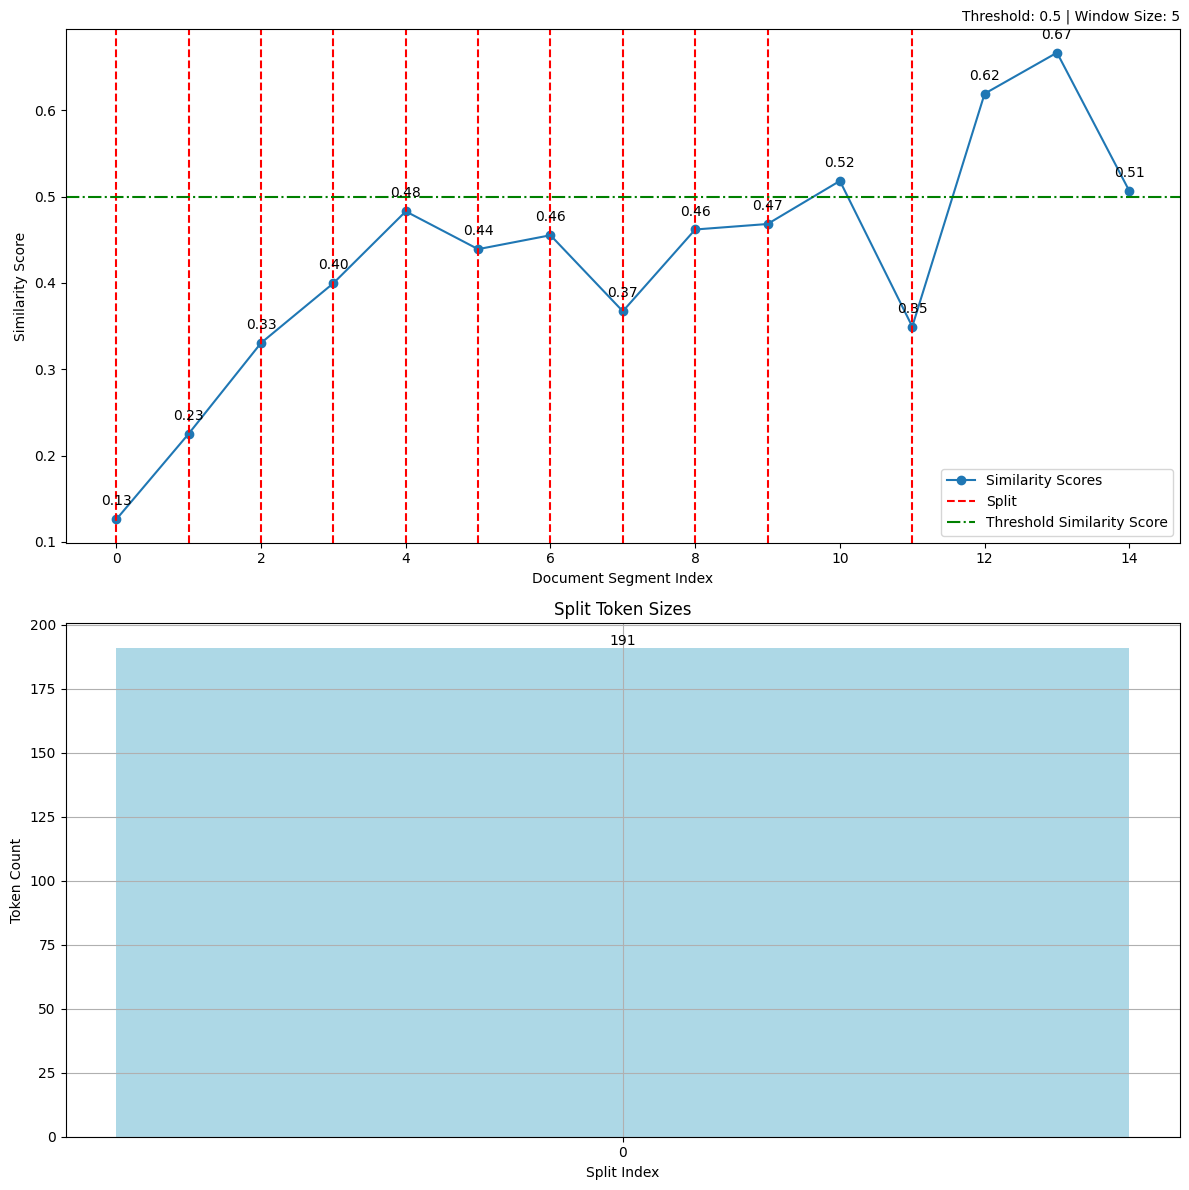

Splitting Statistics:
  - Total Documents: 16
  - Total Splits: 1
  - Splits by Threshold: 0
  - Splits by Max Chunk Size: 0
  - Last Split: 1
  - Minimum Token Size of Split: 191
  - Maximum Token Size of Split: 191
  - Similarity Split Ratio: 0.00


InsertManyResult([ObjectId('671ab21795f3044a90a3a5dc'), ObjectId('671ab21795f3044a90a3a5dd'), ObjectId('671ab21795f3044a90a3a5de'), ObjectId('671ab21795f3044a90a3a5df'), ObjectId('671ab21795f3044a90a3a5e0'), ObjectId('671ab21795f3044a90a3a5e1'), ObjectId('671ab21795f3044a90a3a5e2'), ObjectId('671ab21795f3044a90a3a5e3'), ObjectId('671ab21795f3044a90a3a5e4'), ObjectId('671ab21795f3044a90a3a5e5'), ObjectId('671ab21795f3044a90a3a5e6'), ObjectId('671ab21795f3044a90a3a5e7'), ObjectId('671ab21795f3044a90a3a5e8'), ObjectId('671ab21795f3044a90a3a5e9'), ObjectId('671ab21795f3044a90a3a5ea'), ObjectId('671ab21795f3044a90a3a5eb'), ObjectId('671ab21795f3044a90a3a5ec'), ObjectId('671ab21795f3044a90a3a5ed'), ObjectId('671ab21795f3044a90a3a5ee'), ObjectId('671ab21795f3044a90a3a5ef'), ObjectId('671ab21795f3044a90a3a5f0'), ObjectId('671ab21795f3044a90a3a5f1'), ObjectId('671ab21795f3044a90a3a5f2'), ObjectId('671ab21795f3044a90a3a5f3'), ObjectId('671ab21795f3044a90a3a5f4'), ObjectId('671ab21795f3044a90a3a5

In [50]:
handler = DBHandler(org_id='maccabi_emb3', user_id='evaluator')
chunks = create_chunks(CohereEncoder(), 'data/docs', 0.5, model='models/embedding-001')
handler.update('embeddings', chunks)